##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/video/video_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/video/video_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Video classification with a 3D convolutional neural network

This tutorial demonstrates training a 3D convolutional neural network (CNN) for video classification using the [UCF101](https://www.crcv.ucf.edu/data/UCF101.php) action recognition dataset. A 3D CNN uses a three-dimensional filter to perform convolutions. The kernel is able to slide in three directions, whereas in a 2D CNN it can slide in two dimensions. The model is based on the work published in [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017).  In this tutorial, you will:

* Build an input pipeline
* Build a 3D convolutional neural network model with residual connections using Keras functional API
* Train the model
* Evaluate and test the model

This video classification tutorial is the second part in a series of TensorFlow video tutorials. Here are the other three tutorials:

- [Load video data](https://www.tensorflow.org/tutorials/load_data/video): This tutorial explains much of the code used in this document.
- [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet): Get familiar with the MoViNet models that are available on TF Hub.
- [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet): This tutorial explains how to use a pre-trained video classification model trained on a different dataset with the UCF-101 dataset.

## Setup

Begin by installing and importing some necessary libraries, including:
[remotezip](https://github.com/gtsystem/python-remotezip) to inspect the contents of a ZIP file, [tqdm](https://github.com/tqdm/tqdm) to use a progress bar, [OpenCV](https://opencv.org/) to process video files, [einops](https://github.com/arogozhnikov/einops/tree/master/docs) for performing more complex tensor operations, and [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs) for embedding data in a Jupyter notebook.

**Note**: Use TensorFlow 2.10 to run this tutorial. Versions above TensorFlow 2.10 may not run successfully.

In [2]:
!pip install remotezip tqdm opencv-python einops 
# Install TensorFlow 2.10
!pip install tensorflow==2.10.0

  Preparing metadata (setup.py) ... -

 done


  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/34/7c/8a5043f362b0a55f07812a0db3f86092cdbd0fe41b933d7bc6fce3ab6c15/opencv_python-4.8.0.74-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata


  Using cached tabulate-0.9.0-py3-none-any.whl (35 kB)


 \

 done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7933 sha256=18c76ab20e8d4cf71a74850678c4c3cd1bdc0943393780f873a8ea97bdf08bb1
  Stored in directory: /home/kbuilder/.cache/pip/wheels/60/74/6c/b12b4c8fb4b7ab08f495ce17e88f1e98835268af7a8ad5588f
Successfully built remotezip


  Attempting uninstall: keras


    Found existing installation: keras 2.13.1


    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1


  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0


  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1


  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.0rc2
    Uninstalling protobuf-4.24.0rc2:
      Successfully uninstalled protobuf-4.24.0rc2


  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.0.0
    Uninstalling google-auth-oauthlib-1.0.0:
      Successfully uninstalled google-auth-oauthlib-1.0.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.13.0
    Uninstalling tensorboard-2.13.0:


      Successfully uninstalled tensorboard-2.13.0


  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.13.0


    Uninstalling tensorflow-2.13.0:


      Successfully uninstalled tensorflow-2.13.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-datasets 4.9.2 requires protobuf>=3.20, but you have protobuf 3.19.6 which is incompatible.
tensorflow-metadata 1.13.1 requires protobuf<5,>=3.20.3, but you have protobuf 3.19.6 which is incompatible.


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import cv2
import einops
import numpy as np
import remotezip as rz
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers

2023-07-27 03:27:28.073979: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-07-27 03:27:28.699476: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-27 03:27:28.699587: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /tmpfs/src/tf_docs_env/lib/python3.9/site-packages/cv2/../../lib64:
2023-07-27 03:27:28.699596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## Load and preprocess video data

The hidden cell below defines helper functions to download a slice of data from the UCF-101 dataset, and load it into a `tf.data.Dataset`. You can learn more about the specific preprocessing steps in the [Loading video data tutorial](../load_data/video.ipynb), which walks you through this code in more detail.

The `FrameGenerator` class at the end of the hidden block is the most important utility here. It creates an iterable object that can feed data into the TensorFlow data pipeline. Specifically, this class contains a Python generator that loads the video frames along with its encoded label. The generator (`__call__`) function yields the frame array produced by `frames_from_video_file` and a one-hot encoded vector of the label associated with the set of frames.

In [4]:
#@title

def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped. 

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(URL) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class. 

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test. 

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [5]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL, 
                        num_classes = 10, 
                        splits = {"train": 30, "val": 10, "test": 10},
                        download_dir = download_dir)

train :


  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:00<01:48,  2.74it/s]

  1%|          | 2/300 [00:01<04:37,  1.07it/s]

  1%|          | 3/300 [00:02<03:26,  1.44it/s]

  1%|▏         | 4/300 [00:02<02:40,  1.84it/s]

  2%|▏         | 5/300 [00:02<02:16,  2.16it/s]

  2%|▏         | 7/300 [00:03<01:33,  3.14it/s]

  3%|▎         | 9/300 [00:03<01:01,  4.74it/s]

  4%|▎         | 11/300 [00:03<00:44,  6.45it/s]

  4%|▍         | 13/300 [00:03<00:35,  8.12it/s]

  5%|▌         | 15/300 [00:04<00:55,  5.18it/s]

  6%|▌         | 17/300 [00:04<00:51,  5.53it/s]

  6%|▋         | 19/300 [00:04<00:44,  6.37it/s]

  7%|▋         | 21/300 [00:04<00:39,  7.14it/s]

  8%|▊         | 23/300 [00:04<00:31,  8.79it/s]

  8%|▊         | 25/300 [00:05<00:41,  6.59it/s]

  9%|▉         | 27/300 [00:05<00:34,  7.99it/s]

 10%|▉         | 29/300 [00:05<00:29,  9.05it/s]

 10%|█         | 31/300 [00:06<00:33,  8.01it/s]

 11%|█         | 33/300 [00:06<00:38,  6.95it/s]

 12%|█▏        | 35/300 [00:06<00:31,  8.46it/s]

 12%|█▏        | 37/300 [00:06<00:32,  8.20it/s]

 13%|█▎        | 39/300 [00:07<00:33,  7.88it/s]

 14%|█▎        | 41/300 [00:07<00:27,  9.42it/s]

 14%|█▍        | 43/300 [00:07<00:30,  8.35it/s]

 15%|█▌        | 45/300 [00:07<00:25,  9.81it/s]

 16%|█▌        | 47/300 [00:07<00:24, 10.33it/s]

 16%|█▋        | 49/300 [00:07<00:22, 11.05it/s]

 17%|█▋        | 51/300 [00:08<00:20, 12.36it/s]

 18%|█▊        | 53/300 [00:08<00:18, 13.29it/s]

 18%|█▊        | 55/300 [00:08<00:17, 13.96it/s]

 19%|█▉        | 57/300 [00:08<00:16, 14.78it/s]

 20%|█▉        | 59/300 [00:08<00:15, 15.57it/s]

 20%|██        | 61/300 [00:08<00:22, 10.77it/s]

 21%|██        | 63/300 [00:09<00:42,  5.60it/s]

 22%|██▏       | 65/300 [00:09<00:40,  5.79it/s]

 22%|██▏       | 66/300 [00:10<00:45,  5.11it/s]

 22%|██▏       | 67/300 [00:10<00:47,  4.87it/s]

 23%|██▎       | 68/300 [00:10<01:00,  3.81it/s]

 23%|██▎       | 69/300 [00:11<01:03,  3.62it/s]

 23%|██▎       | 70/300 [00:11<01:04,  3.58it/s]

 24%|██▎       | 71/300 [00:11<01:11,  3.22it/s]

 24%|██▍       | 72/300 [00:12<01:11,  3.17it/s]

 25%|██▍       | 74/300 [00:12<00:48,  4.71it/s]

 25%|██▌       | 75/300 [00:13<01:07,  3.34it/s]

 26%|██▌       | 77/300 [00:13<00:57,  3.86it/s]

 26%|██▌       | 78/300 [00:13<00:57,  3.89it/s]

 27%|██▋       | 80/300 [00:13<00:45,  4.81it/s]

 27%|██▋       | 81/300 [00:14<00:47,  4.63it/s]

 27%|██▋       | 82/300 [00:14<00:51,  4.22it/s]

 28%|██▊       | 83/300 [00:14<00:44,  4.90it/s]

 28%|██▊       | 85/300 [00:14<00:38,  5.64it/s]

 29%|██▉       | 87/300 [00:15<00:29,  7.13it/s]

 30%|██▉       | 89/300 [00:15<00:28,  7.39it/s]

 30%|███       | 90/300 [00:15<00:33,  6.26it/s]

 30%|███       | 91/300 [00:15<00:38,  5.44it/s]

 31%|███       | 92/300 [00:16<00:40,  5.10it/s]

 31%|███       | 93/300 [00:16<00:42,  4.87it/s]

 32%|███▏      | 95/300 [00:16<00:37,  5.47it/s]

 32%|███▏      | 96/300 [00:16<00:38,  5.26it/s]

 32%|███▏      | 97/300 [00:16<00:34,  5.93it/s]

 33%|███▎      | 98/300 [00:17<00:37,  5.37it/s]

 33%|███▎      | 99/300 [00:17<00:45,  4.41it/s]

 34%|███▎      | 101/300 [00:17<00:33,  5.95it/s]

 34%|███▍      | 103/300 [00:17<00:31,  6.30it/s]

 35%|███▌      | 105/300 [00:18<00:24,  7.92it/s]

 36%|███▌      | 107/300 [00:18<00:20,  9.31it/s]

 36%|███▋      | 109/300 [00:18<00:22,  8.46it/s]

 37%|███▋      | 111/300 [00:18<00:18, 10.02it/s]

 38%|███▊      | 113/300 [00:18<00:21,  8.56it/s]

 38%|███▊      | 115/300 [00:19<00:22,  8.16it/s]

 39%|███▉      | 117/300 [00:19<00:19,  9.40it/s]

 40%|███▉      | 119/300 [00:19<00:19,  9.25it/s]

 40%|████      | 121/300 [00:19<00:22,  7.99it/s]

 41%|████      | 122/300 [00:20<00:25,  6.95it/s]

 41%|████      | 123/300 [00:20<00:29,  6.04it/s]

 41%|████▏     | 124/300 [00:20<00:33,  5.29it/s]

 42%|████▏     | 126/300 [00:20<00:29,  5.94it/s]

 42%|████▏     | 127/300 [00:21<00:31,  5.44it/s]

 43%|████▎     | 129/300 [00:21<00:24,  6.87it/s]

 43%|████▎     | 130/300 [00:21<00:27,  6.25it/s]

 44%|████▍     | 132/300 [00:21<00:20,  8.20it/s]

 45%|████▍     | 134/300 [00:21<00:16, 10.05it/s]

 45%|████▌     | 136/300 [00:21<00:14, 11.35it/s]

 46%|████▌     | 138/300 [00:22<00:12, 12.46it/s]

 47%|████▋     | 140/300 [00:22<00:16,  9.85it/s]

 47%|████▋     | 142/300 [00:22<00:17,  8.90it/s]

 48%|████▊     | 144/300 [00:22<00:15, 10.33it/s]

 49%|████▊     | 146/300 [00:22<00:13, 11.58it/s]

 49%|████▉     | 148/300 [00:23<00:16,  9.44it/s]

 50%|█████     | 150/300 [00:23<00:13, 10.79it/s]

 51%|█████     | 152/300 [00:23<00:23,  6.30it/s]

 51%|█████     | 153/300 [00:24<00:30,  4.83it/s]

 51%|█████▏    | 154/300 [00:24<00:40,  3.59it/s]

 52%|█████▏    | 155/300 [00:25<00:40,  3.62it/s]

 52%|█████▏    | 157/300 [00:25<00:32,  4.39it/s]

 53%|█████▎    | 158/300 [00:25<00:37,  3.75it/s]

 53%|█████▎    | 159/300 [00:26<00:38,  3.65it/s]

 53%|█████▎    | 160/300 [00:26<00:40,  3.46it/s]

 54%|█████▎    | 161/300 [00:26<00:37,  3.72it/s]

 54%|█████▍    | 162/300 [00:26<00:37,  3.72it/s]

 54%|█████▍    | 163/300 [00:27<00:40,  3.37it/s]

 55%|█████▍    | 164/300 [00:27<00:37,  3.63it/s]

 55%|█████▌    | 165/300 [00:27<00:35,  3.84it/s]

 56%|█████▌    | 167/300 [00:28<00:34,  3.83it/s]

 56%|█████▌    | 168/300 [00:28<00:33,  4.00it/s]

 56%|█████▋    | 169/300 [00:28<00:30,  4.31it/s]

 57%|█████▋    | 171/300 [00:28<00:21,  6.03it/s]

 57%|█████▋    | 172/300 [00:29<00:37,  3.39it/s]

 58%|█████▊    | 174/300 [00:29<00:32,  3.83it/s]

 59%|█████▊    | 176/300 [00:30<00:23,  5.21it/s]

 59%|█████▉    | 177/300 [00:31<00:52,  2.36it/s]

 59%|█████▉    | 178/300 [00:31<00:49,  2.46it/s]

 60%|██████    | 180/300 [00:32<00:37,  3.22it/s]

 60%|██████    | 181/300 [00:32<00:39,  3.05it/s]

 61%|██████    | 182/300 [00:32<00:39,  2.97it/s]

 61%|██████    | 183/300 [00:33<00:40,  2.90it/s]

 61%|██████▏   | 184/300 [00:33<00:36,  3.21it/s]

 62%|██████▏   | 186/300 [00:33<00:24,  4.72it/s]

 63%|██████▎   | 188/300 [00:33<00:20,  5.47it/s]

 63%|██████▎   | 189/300 [00:34<00:24,  4.52it/s]

 64%|██████▎   | 191/300 [00:34<00:17,  6.17it/s]

 64%|██████▍   | 192/300 [00:34<00:20,  5.19it/s]

 65%|██████▍   | 194/300 [00:34<00:15,  6.98it/s]

 65%|██████▌   | 196/300 [00:34<00:11,  8.77it/s]

 66%|██████▌   | 198/300 [00:35<00:21,  4.74it/s]

 67%|██████▋   | 200/300 [00:35<00:17,  5.86it/s]

 67%|██████▋   | 202/300 [00:36<00:13,  7.27it/s]

 68%|██████▊   | 204/300 [00:36<00:10,  8.89it/s]

 69%|██████▊   | 206/300 [00:36<00:10,  9.21it/s]

 69%|██████▉   | 208/300 [00:36<00:08, 10.32it/s]

 70%|███████   | 210/300 [00:36<00:08, 10.84it/s]

 71%|███████   | 212/300 [00:37<00:12,  6.80it/s]

 71%|███████   | 213/300 [00:37<00:14,  6.06it/s]

 71%|███████▏  | 214/300 [00:37<00:15,  5.40it/s]

 72%|███████▏  | 216/300 [00:37<00:12,  6.94it/s]

 72%|███████▏  | 217/300 [00:38<00:13,  6.03it/s]

 73%|███████▎  | 218/300 [00:38<00:14,  5.70it/s]

 73%|███████▎  | 220/300 [00:38<00:10,  7.61it/s]

 74%|███████▍  | 222/300 [00:38<00:10,  7.55it/s]

 75%|███████▍  | 224/300 [00:38<00:08,  9.30it/s]

 75%|███████▌  | 226/300 [00:38<00:06, 10.67it/s]

 76%|███████▌  | 228/300 [00:39<00:05, 12.13it/s]

 77%|███████▋  | 230/300 [00:39<00:05, 12.86it/s]

 77%|███████▋  | 232/300 [00:39<00:10,  6.80it/s]

 78%|███████▊  | 234/300 [00:40<00:12,  5.12it/s]

 79%|███████▊  | 236/300 [00:40<00:09,  6.46it/s]

 79%|███████▉  | 238/300 [00:40<00:07,  7.93it/s]

 80%|████████  | 240/300 [00:40<00:06,  9.13it/s]

 81%|████████  | 242/300 [00:41<00:08,  6.62it/s]

 81%|████████▏ | 244/300 [00:41<00:09,  5.72it/s]

 82%|████████▏ | 245/300 [00:42<00:11,  4.81it/s]

 82%|████████▏ | 247/300 [00:42<00:08,  6.24it/s]

 83%|████████▎ | 248/300 [00:42<00:09,  5.20it/s]

 83%|████████▎ | 250/300 [00:42<00:07,  6.57it/s]

 84%|████████▎ | 251/300 [00:43<00:08,  5.94it/s]

 84%|████████▍ | 253/300 [00:43<00:06,  7.81it/s]

 85%|████████▌ | 255/300 [00:43<00:04,  9.30it/s]

 86%|████████▌ | 257/300 [00:43<00:04, 10.63it/s]

 86%|████████▋ | 259/300 [00:43<00:04,  8.61it/s]

 87%|████████▋ | 261/300 [00:43<00:03, 10.06it/s]

 88%|████████▊ | 263/300 [00:44<00:04,  8.73it/s]

 88%|████████▊ | 265/300 [00:44<00:04,  8.09it/s]

 89%|████████▉ | 267/300 [00:44<00:03,  9.49it/s]

 90%|████████▉ | 269/300 [00:44<00:02, 10.92it/s]

 90%|█████████ | 271/300 [00:45<00:04,  6.39it/s]

 91%|█████████ | 273/300 [00:45<00:04,  5.46it/s]

 92%|█████████▏| 275/300 [00:46<00:05,  4.74it/s]

 92%|█████████▏| 276/300 [00:46<00:05,  4.72it/s]

 92%|█████████▏| 277/300 [00:46<00:05,  4.49it/s]

 93%|█████████▎| 279/300 [00:47<00:04,  4.94it/s]

 94%|█████████▎| 281/300 [00:47<00:03,  6.24it/s]

 94%|█████████▍| 282/300 [00:47<00:03,  5.04it/s]

 94%|█████████▍| 283/300 [00:47<00:03,  4.69it/s]

 95%|█████████▌| 285/300 [00:48<00:02,  5.45it/s]

 96%|█████████▌| 287/300 [00:48<00:01,  7.00it/s]

 96%|█████████▋| 289/300 [00:48<00:01,  8.18it/s]

 97%|█████████▋| 290/300 [00:48<00:01,  6.93it/s]

 97%|█████████▋| 291/300 [00:48<00:01,  6.39it/s]

 98%|█████████▊| 293/300 [00:49<00:01,  5.64it/s]

 98%|█████████▊| 294/300 [00:49<00:00,  6.19it/s]

 99%|█████████▊| 296/300 [00:49<00:00,  8.11it/s]

 99%|█████████▉| 298/300 [00:49<00:00,  6.54it/s]

100%|█████████▉| 299/300 [00:50<00:00,  6.68it/s]

100%|██████████| 300/300 [00:50<00:00,  5.98it/s]

val :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:15,  6.35it/s]

  2%|▏         | 2/100 [00:00<00:12,  7.99it/s]

  3%|▎         | 3/100 [00:00<00:22,  4.28it/s]

  5%|▌         | 5/100 [00:00<00:13,  7.16it/s]

  7%|▋         | 7/100 [00:00<00:11,  7.98it/s]

  8%|▊         | 8/100 [00:01<00:12,  7.56it/s]

 10%|█         | 10/100 [00:01<00:11,  7.94it/s]

 11%|█         | 11/100 [00:01<00:11,  7.60it/s]

 12%|█▏        | 12/100 [00:01<00:12,  7.17it/s]

 13%|█▎        | 13/100 [00:01<00:11,  7.64it/s]

 15%|█▌        | 15/100 [00:01<00:09,  8.76it/s]

 16%|█▌        | 16/100 [00:02<00:09,  8.41it/s]

 17%|█▋        | 17/100 [00:02<00:09,  8.59it/s]

 19%|█▉        | 19/100 [00:02<00:07, 10.80it/s]

 21%|██        | 21/100 [00:02<00:07, 10.16it/s]

 23%|██▎       | 23/100 [00:03<00:13,  5.87it/s]

 24%|██▍       | 24/100 [00:03<00:12,  6.15it/s]

 25%|██▌       | 25/100 [00:03<00:11,  6.41it/s]

 26%|██▌       | 26/100 [00:03<00:10,  6.77it/s]

 27%|██▋       | 27/100 [00:03<00:10,  7.11it/s]

 28%|██▊       | 28/100 [00:03<00:09,  7.36it/s]

 29%|██▉       | 29/100 [00:03<00:10,  6.68it/s]

 30%|███       | 30/100 [00:04<00:09,  7.31it/s]

 31%|███       | 31/100 [00:04<00:09,  7.34it/s]

 32%|███▏      | 32/100 [00:04<00:09,  7.43it/s]

 34%|███▍      | 34/100 [00:04<00:07,  8.40it/s]

 35%|███▌      | 35/100 [00:04<00:07,  8.64it/s]

 36%|███▌      | 36/100 [00:04<00:07,  8.42it/s]

 38%|███▊      | 38/100 [00:05<00:08,  7.22it/s]

 40%|████      | 40/100 [00:05<00:08,  6.78it/s]

 41%|████      | 41/100 [00:05<00:08,  7.23it/s]

 43%|████▎     | 43/100 [00:05<00:07,  7.65it/s]

 44%|████▍     | 44/100 [00:05<00:07,  7.79it/s]

 45%|████▌     | 45/100 [00:06<00:07,  7.22it/s]

 46%|████▌     | 46/100 [00:06<00:07,  7.68it/s]

 47%|████▋     | 47/100 [00:06<00:07,  7.02it/s]

 48%|████▊     | 48/100 [00:06<00:07,  7.18it/s]

 50%|█████     | 50/100 [00:06<00:05,  8.73it/s]

 51%|█████     | 51/100 [00:06<00:07,  6.58it/s]

 52%|█████▏    | 52/100 [00:07<00:10,  4.38it/s]

 53%|█████▎    | 53/100 [00:07<00:10,  4.31it/s]

 54%|█████▍    | 54/100 [00:07<00:09,  4.85it/s]

 55%|█████▌    | 55/100 [00:07<00:09,  4.74it/s]

 57%|█████▋    | 57/100 [00:08<00:06,  6.21it/s]

 58%|█████▊    | 58/100 [00:08<00:07,  5.46it/s]

 60%|██████    | 60/100 [00:08<00:08,  4.60it/s]

 62%|██████▏   | 62/100 [00:09<00:06,  5.71it/s]

 63%|██████▎   | 63/100 [00:09<00:06,  5.98it/s]

 64%|██████▍   | 64/100 [00:09<00:06,  5.99it/s]

 65%|██████▌   | 65/100 [00:09<00:05,  6.50it/s]

 67%|██████▋   | 67/100 [00:09<00:04,  7.35it/s]

 68%|██████▊   | 68/100 [00:09<00:04,  7.75it/s]

 69%|██████▉   | 69/100 [00:10<00:04,  7.15it/s]

 70%|███████   | 70/100 [00:10<00:04,  7.50it/s]

 71%|███████   | 71/100 [00:10<00:03,  7.97it/s]

 72%|███████▏  | 72/100 [00:10<00:04,  6.60it/s]

 74%|███████▍  | 74/100 [00:10<00:03,  8.14it/s]

 76%|███████▌  | 76/100 [00:10<00:02,  8.32it/s]

 78%|███████▊  | 78/100 [00:11<00:02, 10.21it/s]

 80%|████████  | 80/100 [00:11<00:02,  9.24it/s]

 82%|████████▏ | 82/100 [00:11<00:02,  8.82it/s]

 83%|████████▎ | 83/100 [00:11<00:01,  8.72it/s]

 84%|████████▍ | 84/100 [00:11<00:02,  7.89it/s]

 85%|████████▌ | 85/100 [00:11<00:01,  7.86it/s]

 86%|████████▌ | 86/100 [00:12<00:01,  8.22it/s]

 88%|████████▊ | 88/100 [00:12<00:01, 10.10it/s]

 90%|█████████ | 90/100 [00:12<00:00, 11.82it/s]

 92%|█████████▏| 92/100 [00:12<00:00, 10.55it/s]

 94%|█████████▍| 94/100 [00:12<00:00,  8.46it/s]

 95%|█████████▌| 95/100 [00:12<00:00,  8.64it/s]

 96%|█████████▌| 96/100 [00:13<00:00,  8.78it/s]

 97%|█████████▋| 97/100 [00:13<00:00,  8.97it/s]

 99%|█████████▉| 99/100 [00:13<00:00,  9.40it/s]

100%|██████████| 100/100 [00:13<00:00,  7.44it/s]

test :


  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:11,  8.97it/s]

  3%|▎         | 3/100 [00:00<00:09,  9.92it/s]

  5%|▌         | 5/100 [00:00<00:11,  8.15it/s]

  6%|▌         | 6/100 [00:00<00:12,  7.26it/s]

  8%|▊         | 8/100 [00:00<00:09,  9.31it/s]

 10%|█         | 10/100 [00:01<00:09,  9.69it/s]

 12%|█▏        | 12/100 [00:01<00:08, 10.01it/s]

 14%|█▍        | 14/100 [00:01<00:07, 11.38it/s]

 16%|█▌        | 16/100 [00:01<00:07, 11.43it/s]

 18%|█▊        | 18/100 [00:01<00:08,  9.25it/s]

 20%|██        | 20/100 [00:02<00:08,  9.33it/s]

 21%|██        | 21/100 [00:02<00:08,  9.08it/s]

 23%|██▎       | 23/100 [00:02<00:08,  9.54it/s]

 24%|██▍       | 24/100 [00:02<00:07,  9.57it/s]

 25%|██▌       | 25/100 [00:02<00:08,  8.54it/s]

 26%|██▌       | 26/100 [00:02<00:10,  7.21it/s]

 27%|██▋       | 27/100 [00:02<00:09,  7.66it/s]

 28%|██▊       | 28/100 [00:03<00:09,  7.56it/s]

 29%|██▉       | 29/100 [00:03<00:09,  7.88it/s]

 30%|███       | 30/100 [00:03<00:10,  6.72it/s]

 31%|███       | 31/100 [00:03<00:10,  6.64it/s]

 32%|███▏      | 32/100 [00:03<00:10,  6.25it/s]

 33%|███▎      | 33/100 [00:03<00:10,  6.56it/s]

 34%|███▍      | 34/100 [00:04<00:09,  6.94it/s]

 35%|███▌      | 35/100 [00:04<00:09,  6.62it/s]

 36%|███▌      | 36/100 [00:04<00:08,  7.25it/s]

 38%|███▊      | 38/100 [00:04<00:10,  6.16it/s]

 40%|████      | 40/100 [00:04<00:07,  7.60it/s]

 42%|████▏     | 42/100 [00:05<00:07,  7.82it/s]

 44%|████▍     | 44/100 [00:05<00:06,  8.64it/s]

 46%|████▌     | 46/100 [00:05<00:05, 10.11it/s]

 48%|████▊     | 48/100 [00:05<00:05,  9.73it/s]

 50%|█████     | 50/100 [00:05<00:05,  9.25it/s]

 52%|█████▏    | 52/100 [00:06<00:05,  8.98it/s]

 53%|█████▎    | 53/100 [00:06<00:05,  8.41it/s]

 54%|█████▍    | 54/100 [00:06<00:05,  8.43it/s]

 55%|█████▌    | 55/100 [00:06<00:06,  6.76it/s]

 56%|█████▌    | 56/100 [00:06<00:08,  5.41it/s]

 57%|█████▋    | 57/100 [00:07<00:07,  5.77it/s]

 58%|█████▊    | 58/100 [00:07<00:06,  6.30it/s]

 60%|██████    | 60/100 [00:07<00:05,  7.12it/s]

 62%|██████▏   | 62/100 [00:07<00:05,  7.05it/s]

 64%|██████▍   | 64/100 [00:07<00:04,  7.32it/s]

 66%|██████▌   | 66/100 [00:08<00:04,  8.16it/s]

 68%|██████▊   | 68/100 [00:08<00:03,  8.60it/s]

 70%|███████   | 70/100 [00:08<00:02, 10.16it/s]

 72%|███████▏  | 72/100 [00:08<00:02,  9.83it/s]

 74%|███████▍  | 74/100 [00:08<00:02, 10.85it/s]

 76%|███████▌  | 76/100 [00:09<00:02, 10.15it/s]

 78%|███████▊  | 78/100 [00:09<00:02, 10.52it/s]

 80%|████████  | 80/100 [00:09<00:02,  9.99it/s]

 82%|████████▏ | 82/100 [00:09<00:01,  9.41it/s]

 83%|████████▎ | 83/100 [00:09<00:01,  9.39it/s]

 84%|████████▍ | 84/100 [00:09<00:01,  8.83it/s]

 85%|████████▌ | 85/100 [00:10<00:01,  8.84it/s]

 87%|████████▋ | 87/100 [00:10<00:01,  9.08it/s]

 89%|████████▉ | 89/100 [00:10<00:01,  9.97it/s]

 91%|█████████ | 91/100 [00:10<00:00,  9.49it/s]

 92%|█████████▏| 92/100 [00:10<00:00,  8.76it/s]

 93%|█████████▎| 93/100 [00:10<00:00,  8.61it/s]

 95%|█████████▌| 95/100 [00:11<00:00, 10.06it/s]

 97%|█████████▋| 97/100 [00:11<00:00,  8.87it/s]

 98%|█████████▊| 98/100 [00:11<00:00,  8.98it/s]

 99%|█████████▉| 99/100 [00:11<00:00,  9.00it/s]

100%|██████████| 100/100 [00:11<00:00,  7.34it/s]

100%|██████████| 100/100 [00:11<00:00,  8.47it/s]

Create the training, validation, and test sets (`train_ds`, `val_ds`, and `test_ds`).

In [6]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size)

## Create the model

The following 3D convolutional neural network model is based off the paper [A Closer Look at Spatiotemporal Convolutions for Action Recognition](https://arxiv.org/abs/1711.11248v3) by D. Tran et al. (2017). The paper compares several versions of 3D ResNets. Instead of operating on a single image with dimensions `(height, width)`, like standard ResNets, these operate on video volume `(time, height, width)`. The most obvious approach to this problem would be replace each 2D convolution (`layers.Conv2D`) with a 3D convolution (`layers.Conv3D`).

This tutorial uses a (2 + 1)D convolution with [residual connections](https://arxiv.org/abs/1512.03385). The (2 + 1)D convolution allows for the decomposition of the spatial and temporal dimensions, therefore creating two separate steps. An advantage of this approach is that factorizing the convolutions into spatial and temporal dimensions saves parameters. 

For each output location a 3D convolution combines all the vectors from a 3D patch of the volume to create one vector in the output volume.

![3D convolutions](https://www.tensorflow.org/images/tutorials/video/3DCNN.png)

This operation is takes `time * height * width * channels` inputs and produces `channels` outputs (assuming the number of input and output channels are the same. So a 3D convolution layer with a kernel size of `(3 x 3 x 3)` would need a weight-matrix with `27 * channels ** 2` entries. The reference paper found that a more effective & efficient approach was to factorize the convolution. Instead of a single 3D convolution to process the time and space dimensions, they proposed a \"(2+1)D\" convolution which processes the space and time dimensions separately. The figure below shows the factored spatial and temporal convolutions of a (2 + 1)D convolution.

![(2+1)D convolutions](https://www.tensorflow.org/images/tutorials/video/2plus1CNN.png)

The main advantage of this approach is that it reduces the number of parameters. In the (2 + 1)D convolution the spatial convolution takes in data of the shape `(1, width, height)`, while the temporal convolution takes in data of the shape `(time, 1, 1)`. For example, a (2 + 1)D convolution with kernel size `(3 x 3 x 3)` would need weight matrices of size `(9 * channels**2) + (3 * channels**2)`, less than half as many as the full 3D convolution. This tutorial implements (2 + 1)D ResNet18, where each convolution in the resnet is replaced by a (2+1)D convolution.

In [7]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [8]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])
  
  def call(self, x):
    return self.seq(x)

A ResNet model is made from a sequence of residual blocks.
A residual block has two branches. The main branch performs the calculation, but is difficult for gradients to flow through.
The residual branch bypasses the main calculation and mostly just adds the input to the output of the main branch.
Gradients flow easily through this branch.
Therefore, an easy path from the loss function to any of the residual block's main branch will be present.
This avoids the vanishing gradient problem.

Create the main branch of the residual block with the following class. In contrast to the standard ResNet structure this uses the custom `Conv2Plus1D` layer instead of `layers.Conv2D`.

In [9]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])
    
  def call(self, x):
    return self.seq(x)

To add the residual branch to the main branch it needs to have the same size. The `Project` layer below deals with cases where the number of channels is changed on the branch. In particular, a sequence of densely-connected layer followed by normalization is added.  

In [10]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def call(self, x):
    return self.seq(x)

Use `add_residual_block` to introduce a skip connection between the layers of the model.

In [11]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

Resizing the video is necessary to perform downsampling of the data. In particular, downsampling the video frames allow for the model to examine specific parts of frames to detect patterns that may be specific to a certain action. Through downsampling, non-essential information can be discarded. Moreoever, resizing the video will allow for dimensionality reduction and therefore faster processing through the model.

In [12]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

Use the [Keras functional API](https://www.tensorflow.org/guide/keras/functional) to build the residual network.

In [13]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

# Block 1
x = add_residual_block(x, 16, (3, 3, 3))
x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

# Block 2
x = add_residual_block(x, 32, (3, 3, 3))
x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

# Block 3
x = add_residual_block(x, 64, (3, 3, 3))
x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

# Block 4
x = add_residual_block(x, 128, (3, 3, 3))

x = layers.GlobalAveragePooling3D()(x)
x = layers.Flatten()(x)
x = layers.Dense(10)(x)

model = keras.Model(input, x)

In [14]:
frames, label = next(iter(train_ds))
model.build(frames)

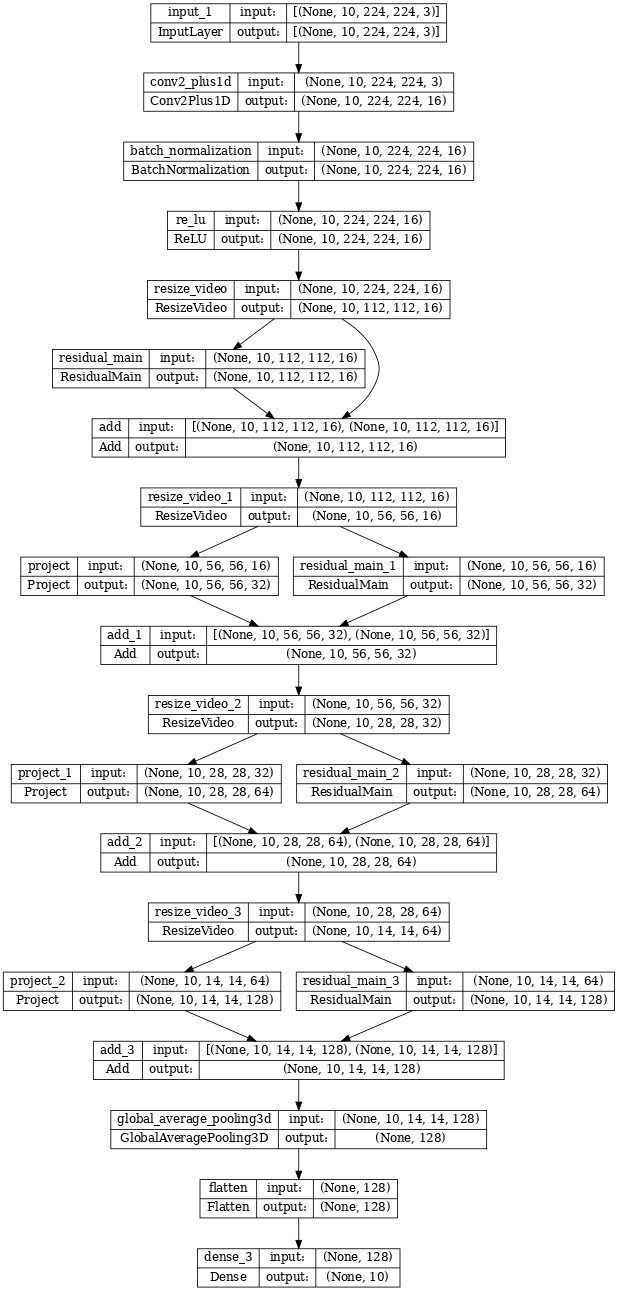

In [15]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

## Train the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and the `tf.keras.losses.SparseCategoricalCrossentropy` loss function. Use the `metrics` argument to the view the accuracy of the model performance at every step.

In [16]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

Train the model for 50 epoches with the Keras `Model.fit` method.

Note: This example model is trained on fewer data points (300 training and 100 validation examples) to keep training time reasonable for this tutorial. Moreover, this example model may take over one hour to train.

In [17]:
history = model.fit(x = train_ds,
                    epochs = 50, 
                    validation_data = val_ds)

Epoch 1/50


      1/Unknown - 7s 7s/step - loss: 3.8656 - accuracy: 0.0000e+00

      2/Unknown - 8s 1s/step - loss: 3.6818 - accuracy: 0.0000e+00

      3/Unknown - 9s 1s/step - loss: 3.4049 - accuracy: 0.0000e+00

      4/Unknown - 11s 1s/step - loss: 3.3011 - accuracy: 0.0312   

      5/Unknown - 12s 1s/step - loss: 3.1188 - accuracy: 0.0750

      6/Unknown - 13s 1s/step - loss: 3.0160 - accuracy: 0.0833

      7/Unknown - 14s 1s/step - loss: 2.8974 - accuracy: 0.0714

      8/Unknown - 16s 1s/step - loss: 2.9100 - accuracy: 0.0625

      9/Unknown - 17s 1s/step - loss: 2.9148 - accuracy: 0.0556

     10/Unknown - 18s 1s/step - loss: 2.8590 - accuracy: 0.0625

     11/Unknown - 19s 1s/step - loss: 2.7828 - accuracy: 0.0909

     12/Unknown - 21s 1s/step - loss: 2.8168 - accuracy: 0.1042

     13/Unknown - 22s 1s/step - loss: 2.7993 - accuracy: 0.1058

     14/Unknown - 23s 1s/step - loss: 2.7635 - accuracy: 0.1071

     15/Unknown - 24s 1s/step - loss: 2.7221 - accuracy: 0.1250

     16/Unknown - 26s 1s/step - loss: 2.7015 - accuracy: 0.1328

     17/Unknown - 27s 1s/step - loss: 2.6960 - accuracy: 0.1250

     18/Unknown - 28s 1s/step - loss: 2.6961 - accuracy: 0.1181

     19/Unknown - 29s 1s/step - loss: 2.6840 - accuracy: 0.1118

     20/Unknown - 31s 1s/step - loss: 2.6575 - accuracy: 0.1063

     21/Unknown - 32s 1s/step - loss: 2.6300 - accuracy: 0.1131

     22/Unknown - 33s 1s/step - loss: 2.6124 - accuracy: 0.1136

     23/Unknown - 35s 1s/step - loss: 2.6075 - accuracy: 0.1087

     24/Unknown - 36s 1s/step - loss: 2.6042 - accuracy: 0.1042

     25/Unknown - 37s 1s/step - loss: 2.6069 - accuracy: 0.1050

     26/Unknown - 38s 1s/step - loss: 2.6051 - accuracy: 0.1010

     27/Unknown - 39s 1s/step - loss: 2.5889 - accuracy: 0.1019

     28/Unknown - 41s 1s/step - loss: 2.5780 - accuracy: 0.0982

     29/Unknown - 42s 1s/step - loss: 2.5789 - accuracy: 0.0948

     30/Unknown - 43s 1s/step - loss: 2.5854 - accuracy: 0.0917

     31/Unknown - 44s 1s/step - loss: 2.5834 - accuracy: 0.0968

     32/Unknown - 46s 1s/step - loss: 2.5684 - accuracy: 0.0977

     33/Unknown - 47s 1s/step - loss: 2.5627 - accuracy: 0.0947

     34/Unknown - 48s 1s/step - loss: 2.5452 - accuracy: 0.0993

     35/Unknown - 49s 1s/step - loss: 2.5402 - accuracy: 0.0964

     36/Unknown - 50s 1s/step - loss: 2.5358 - accuracy: 0.0972

     37/Unknown - 52s 1s/step - loss: 2.5248 - accuracy: 0.0980

     38/Unknown - 53s 1s/step - loss: 2.5287 - accuracy: 0.0967

38/38 [==============================] - 66s 2s/step - loss: 2.5287 - accuracy: 0.0967 - val_loss: 2.4516 - val_accuracy: 0.1000


Epoch 2/50


 1/38 [..............................] - ETA: 46s - loss: 2.4158 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 44s - loss: 2.2486 - accuracy: 0.1875

 3/38 [=>............................] - ETA: 44s - loss: 2.1506 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 41s - loss: 2.1480 - accuracy: 0.1250

 5/38 [==>...........................] - ETA: 40s - loss: 2.1654 - accuracy: 0.1000

 6/38 [===>..........................] - ETA: 38s - loss: 2.2350 - accuracy: 0.1042

 7/38 [====>.........................] - ETA: 37s - loss: 2.1755 - accuracy: 0.1607

 8/38 [=====>........................] - ETA: 36s - loss: 2.2236 - accuracy: 0.1406

 9/38 [======>.......................] - ETA: 34s - loss: 2.2189 - accuracy: 0.1389

10/38 [======>.......................] - ETA: 33s - loss: 2.2110 - accuracy: 0.1625

11/38 [=======>......................] - ETA: 32s - loss: 2.2302 - accuracy: 0.1477

12/38 [========>.....................] - ETA: 31s - loss: 2.2350 - accuracy: 0.1458

13/38 [=========>....................] - ETA: 30s - loss: 2.2430 - accuracy: 0.1442

14/38 [==========>...................] - ETA: 28s - loss: 2.2168 - accuracy: 0.1429

15/38 [==========>...................] - ETA: 27s - loss: 2.2389 - accuracy: 0.1417

16/38 [===========>..................] - ETA: 26s - loss: 2.2208 - accuracy: 0.1484

17/38 [============>.................] - ETA: 25s - loss: 2.2509 - accuracy: 0.1397

18/38 [=============>................] - ETA: 24s - loss: 2.2605 - accuracy: 0.1389

19/38 [==============>...............] - ETA: 23s - loss: 2.2636 - accuracy: 0.1447

20/38 [==============>...............] - ETA: 22s - loss: 2.2708 - accuracy: 0.1375

21/38 [===============>..............] - ETA: 20s - loss: 2.2780 - accuracy: 0.1310

22/38 [================>.............] - ETA: 19s - loss: 2.2839 - accuracy: 0.1364

23/38 [=================>............] - ETA: 18s - loss: 2.2736 - accuracy: 0.1359

24/38 [=================>............] - ETA: 17s - loss: 2.2844 - accuracy: 0.1354

25/38 [==================>...........] - ETA: 15s - loss: 2.2971 - accuracy: 0.1350

26/38 [===================>..........] - ETA: 14s - loss: 2.2994 - accuracy: 0.1346

27/38 [====================>.........] - ETA: 13s - loss: 2.2872 - accuracy: 0.1343

28/38 [=====================>........] - ETA: 12s - loss: 2.2966 - accuracy: 0.1384

29/38 [=====================>........] - ETA: 10s - loss: 2.2870 - accuracy: 0.1466

30/38 [======================>.......] - ETA: 9s - loss: 2.2897 - accuracy: 0.1458 

31/38 [=======================>......] - ETA: 8s - loss: 2.2923 - accuracy: 0.1452

32/38 [========================>.....] - ETA: 7s - loss: 2.2894 - accuracy: 0.1406

33/38 [=========================>....] - ETA: 6s - loss: 2.2902 - accuracy: 0.1439

34/38 [=========================>....] - ETA: 4s - loss: 2.2753 - accuracy: 0.1544

35/38 [==========================>...] - ETA: 3s - loss: 2.2804 - accuracy: 0.1571

36/38 [===========================>..] - ETA: 2s - loss: 2.2832 - accuracy: 0.1597

37/38 [============================>.] - ETA: 1s - loss: 2.2810 - accuracy: 0.1588

38/38 [==============================] - ETA: 0s - loss: 2.2794 - accuracy: 0.1600

38/38 [==============================] - 58s 2s/step - loss: 2.2794 - accuracy: 0.1600 - val_loss: 2.3682 - val_accuracy: 0.1500


Epoch 3/50


 1/38 [..............................] - ETA: 43s - loss: 1.9319 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 44s - loss: 1.9905 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 43s - loss: 2.0723 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 40s - loss: 2.2624 - accuracy: 0.2188

 5/38 [==>...........................] - ETA: 38s - loss: 2.2098 - accuracy: 0.1750

 6/38 [===>..........................] - ETA: 38s - loss: 2.2174 - accuracy: 0.1667

 7/38 [====>.........................] - ETA: 36s - loss: 2.1967 - accuracy: 0.1964

 8/38 [=====>........................] - ETA: 34s - loss: 2.1789 - accuracy: 0.1719

 9/38 [======>.......................] - ETA: 34s - loss: 2.2137 - accuracy: 0.1528

10/38 [======>.......................] - ETA: 33s - loss: 2.1959 - accuracy: 0.1375

11/38 [=======>......................] - ETA: 32s - loss: 2.1651 - accuracy: 0.1591

12/38 [========>.....................] - ETA: 31s - loss: 2.1560 - accuracy: 0.1771

13/38 [=========>....................] - ETA: 30s - loss: 2.1756 - accuracy: 0.1827

14/38 [==========>...................] - ETA: 29s - loss: 2.1759 - accuracy: 0.1786

15/38 [==========>...................] - ETA: 27s - loss: 2.1813 - accuracy: 0.1833

16/38 [===========>..................] - ETA: 26s - loss: 2.2036 - accuracy: 0.1719

17/38 [============>.................] - ETA: 25s - loss: 2.1929 - accuracy: 0.1912

18/38 [=============>................] - ETA: 24s - loss: 2.1995 - accuracy: 0.1944

19/38 [==============>...............] - ETA: 22s - loss: 2.1854 - accuracy: 0.2039

20/38 [==============>...............] - ETA: 21s - loss: 2.1989 - accuracy: 0.1937

21/38 [===============>..............] - ETA: 20s - loss: 2.2007 - accuracy: 0.1845

22/38 [================>.............] - ETA: 19s - loss: 2.1823 - accuracy: 0.2045

23/38 [=================>............] - ETA: 18s - loss: 2.1710 - accuracy: 0.2174

24/38 [=================>............] - ETA: 16s - loss: 2.1601 - accuracy: 0.2188

25/38 [==================>...........] - ETA: 15s - loss: 2.1425 - accuracy: 0.2200

26/38 [===================>..........] - ETA: 14s - loss: 2.1406 - accuracy: 0.2163

27/38 [====================>.........] - ETA: 13s - loss: 2.1450 - accuracy: 0.2222

28/38 [=====================>........] - ETA: 12s - loss: 2.1632 - accuracy: 0.2143

29/38 [=====================>........] - ETA: 11s - loss: 2.1540 - accuracy: 0.2198

30/38 [======================>.......] - ETA: 9s - loss: 2.1472 - accuracy: 0.2250 

31/38 [=======================>......] - ETA: 8s - loss: 2.1508 - accuracy: 0.2339

32/38 [========================>.....] - ETA: 7s - loss: 2.1397 - accuracy: 0.2422

33/38 [=========================>....] - ETA: 6s - loss: 2.1489 - accuracy: 0.2386

34/38 [=========================>....] - ETA: 4s - loss: 2.1518 - accuracy: 0.2390

35/38 [==========================>...] - ETA: 3s - loss: 2.1594 - accuracy: 0.2357

36/38 [===========================>..] - ETA: 2s - loss: 2.1480 - accuracy: 0.2431

37/38 [============================>.] - ETA: 1s - loss: 2.1450 - accuracy: 0.2399

38/38 [==============================] - ETA: 0s - loss: 2.1431 - accuracy: 0.2367

38/38 [==============================] - 58s 2s/step - loss: 2.1431 - accuracy: 0.2367 - val_loss: 2.1290 - val_accuracy: 0.1600


Epoch 4/50


 1/38 [..............................] - ETA: 44s - loss: 1.7306 - accuracy: 0.3750

 2/38 [>.............................] - ETA: 44s - loss: 1.8474 - accuracy: 0.3125

 3/38 [=>............................] - ETA: 45s - loss: 1.8360 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 42s - loss: 1.9502 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 39s - loss: 1.9307 - accuracy: 0.2500

 6/38 [===>..........................] - ETA: 38s - loss: 2.0049 - accuracy: 0.2083

 7/38 [====>.........................] - ETA: 36s - loss: 1.9433 - accuracy: 0.2321

 8/38 [=====>........................] - ETA: 35s - loss: 1.9768 - accuracy: 0.2344

 9/38 [======>.......................] - ETA: 34s - loss: 1.9764 - accuracy: 0.2361

10/38 [======>.......................] - ETA: 33s - loss: 2.0001 - accuracy: 0.2250

11/38 [=======>......................] - ETA: 32s - loss: 2.0356 - accuracy: 0.2045

12/38 [========>.....................] - ETA: 31s - loss: 2.0162 - accuracy: 0.2083

13/38 [=========>....................] - ETA: 29s - loss: 2.0005 - accuracy: 0.2019

14/38 [==========>...................] - ETA: 28s - loss: 1.9793 - accuracy: 0.2232

15/38 [==========>...................] - ETA: 27s - loss: 1.9417 - accuracy: 0.2500

16/38 [===========>..................] - ETA: 26s - loss: 1.9642 - accuracy: 0.2422

17/38 [============>.................] - ETA: 25s - loss: 1.9775 - accuracy: 0.2353

18/38 [=============>................] - ETA: 23s - loss: 1.9510 - accuracy: 0.2569

19/38 [==============>...............] - ETA: 22s - loss: 1.9706 - accuracy: 0.2500

20/38 [==============>...............] - ETA: 21s - loss: 1.9603 - accuracy: 0.2625

21/38 [===============>..............] - ETA: 20s - loss: 1.9557 - accuracy: 0.2679

22/38 [================>.............] - ETA: 19s - loss: 1.9571 - accuracy: 0.2670

23/38 [=================>............] - ETA: 18s - loss: 1.9460 - accuracy: 0.2717

24/38 [=================>............] - ETA: 16s - loss: 1.9560 - accuracy: 0.2708

25/38 [==================>...........] - ETA: 15s - loss: 1.9530 - accuracy: 0.2700

26/38 [===================>..........] - ETA: 14s - loss: 1.9506 - accuracy: 0.2692

27/38 [====================>.........] - ETA: 13s - loss: 1.9756 - accuracy: 0.2593

28/38 [=====================>........] - ETA: 12s - loss: 1.9709 - accuracy: 0.2679

29/38 [=====================>........] - ETA: 10s - loss: 1.9696 - accuracy: 0.2716

30/38 [======================>.......] - ETA: 9s - loss: 1.9662 - accuracy: 0.2750 

31/38 [=======================>......] - ETA: 8s - loss: 1.9550 - accuracy: 0.2823

32/38 [========================>.....] - ETA: 7s - loss: 1.9474 - accuracy: 0.2812

33/38 [=========================>....] - ETA: 6s - loss: 1.9452 - accuracy: 0.2841

34/38 [=========================>....] - ETA: 4s - loss: 1.9450 - accuracy: 0.2831

35/38 [==========================>...] - ETA: 3s - loss: 1.9485 - accuracy: 0.2786

36/38 [===========================>..] - ETA: 2s - loss: 1.9764 - accuracy: 0.2778

37/38 [============================>.] - ETA: 1s - loss: 1.9668 - accuracy: 0.2838

38/38 [==============================] - ETA: 0s - loss: 1.9739 - accuracy: 0.2867

38/38 [==============================] - 57s 2s/step - loss: 1.9739 - accuracy: 0.2867 - val_loss: 2.1153 - val_accuracy: 0.1700


Epoch 5/50


 1/38 [..............................] - ETA: 41s - loss: 1.8505 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 43s - loss: 1.9576 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 41s - loss: 1.9947 - accuracy: 0.2500

 4/38 [==>...........................] - ETA: 40s - loss: 2.0909 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 38s - loss: 2.0644 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 37s - loss: 2.0590 - accuracy: 0.2917

 7/38 [====>.........................] - ETA: 36s - loss: 2.0278 - accuracy: 0.2857

 8/38 [=====>........................] - ETA: 35s - loss: 2.0672 - accuracy: 0.2812

 9/38 [======>.......................] - ETA: 34s - loss: 2.0749 - accuracy: 0.2500

10/38 [======>.......................] - ETA: 33s - loss: 2.0784 - accuracy: 0.2375

11/38 [=======>......................] - ETA: 32s - loss: 2.0823 - accuracy: 0.2273

12/38 [========>.....................] - ETA: 30s - loss: 2.0864 - accuracy: 0.2083

13/38 [=========>....................] - ETA: 29s - loss: 2.0856 - accuracy: 0.2019

14/38 [==========>...................] - ETA: 28s - loss: 2.0459 - accuracy: 0.2143

15/38 [==========>...................] - ETA: 27s - loss: 2.0071 - accuracy: 0.2333

16/38 [===========>..................] - ETA: 26s - loss: 1.9991 - accuracy: 0.2344

17/38 [============>.................] - ETA: 25s - loss: 1.9997 - accuracy: 0.2206

18/38 [=============>................] - ETA: 23s - loss: 1.9934 - accuracy: 0.2153

19/38 [==============>...............] - ETA: 22s - loss: 2.0100 - accuracy: 0.2039

20/38 [==============>...............] - ETA: 21s - loss: 2.0238 - accuracy: 0.2062

21/38 [===============>..............] - ETA: 20s - loss: 2.0150 - accuracy: 0.2202

22/38 [================>.............] - ETA: 19s - loss: 2.0116 - accuracy: 0.2330

23/38 [=================>............] - ETA: 18s - loss: 1.9980 - accuracy: 0.2337

24/38 [=================>............] - ETA: 16s - loss: 1.9921 - accuracy: 0.2396

25/38 [==================>...........] - ETA: 15s - loss: 1.9886 - accuracy: 0.2350

26/38 [===================>..........] - ETA: 14s - loss: 1.9818 - accuracy: 0.2356

27/38 [====================>.........] - ETA: 13s - loss: 1.9774 - accuracy: 0.2315

28/38 [=====================>........] - ETA: 12s - loss: 1.9751 - accuracy: 0.2366

29/38 [=====================>........] - ETA: 10s - loss: 1.9594 - accuracy: 0.2457

30/38 [======================>.......] - ETA: 9s - loss: 1.9514 - accuracy: 0.2500 

31/38 [=======================>......] - ETA: 8s - loss: 1.9441 - accuracy: 0.2540

32/38 [========================>.....] - ETA: 7s - loss: 1.9529 - accuracy: 0.2500

33/38 [=========================>....] - ETA: 6s - loss: 1.9586 - accuracy: 0.2500

34/38 [=========================>....] - ETA: 4s - loss: 1.9477 - accuracy: 0.2537

35/38 [==========================>...] - ETA: 3s - loss: 1.9258 - accuracy: 0.2679

36/38 [===========================>..] - ETA: 2s - loss: 1.9308 - accuracy: 0.2674

37/38 [============================>.] - ETA: 1s - loss: 1.9392 - accuracy: 0.2601

38/38 [==============================] - ETA: 0s - loss: 1.9335 - accuracy: 0.2633

38/38 [==============================] - 58s 2s/step - loss: 1.9335 - accuracy: 0.2633 - val_loss: 2.2467 - val_accuracy: 0.1500


Epoch 6/50


 1/38 [..............................] - ETA: 50s - loss: 1.7631 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 45s - loss: 1.9978 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 41s - loss: 1.7996 - accuracy: 0.3333

 4/38 [==>...........................] - ETA: 40s - loss: 1.7678 - accuracy: 0.3438

 5/38 [==>...........................] - ETA: 40s - loss: 1.7969 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 39s - loss: 1.7731 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 37s - loss: 1.8702 - accuracy: 0.3036

 8/38 [=====>........................] - ETA: 36s - loss: 1.9006 - accuracy: 0.2812

 9/38 [======>.......................] - ETA: 35s - loss: 1.8567 - accuracy: 0.3056

10/38 [======>.......................] - ETA: 34s - loss: 1.8890 - accuracy: 0.2750

11/38 [=======>......................] - ETA: 33s - loss: 1.8836 - accuracy: 0.2727

12/38 [========>.....................] - ETA: 31s - loss: 1.8793 - accuracy: 0.2917

13/38 [=========>....................] - ETA: 30s - loss: 1.8513 - accuracy: 0.3077

14/38 [==========>...................] - ETA: 29s - loss: 1.8575 - accuracy: 0.2946

15/38 [==========>...................] - ETA: 28s - loss: 1.8369 - accuracy: 0.3000

16/38 [===========>..................] - ETA: 27s - loss: 1.8512 - accuracy: 0.2969

17/38 [============>.................] - ETA: 25s - loss: 1.8472 - accuracy: 0.3015

18/38 [=============>................] - ETA: 24s - loss: 1.8522 - accuracy: 0.2986

19/38 [==============>...............] - ETA: 23s - loss: 1.8507 - accuracy: 0.3026

20/38 [==============>...............] - ETA: 22s - loss: 1.8599 - accuracy: 0.2937

21/38 [===============>..............] - ETA: 20s - loss: 1.8500 - accuracy: 0.3036

22/38 [================>.............] - ETA: 19s - loss: 1.8454 - accuracy: 0.3125

23/38 [=================>............] - ETA: 18s - loss: 1.8634 - accuracy: 0.2989

24/38 [=================>............] - ETA: 17s - loss: 1.8705 - accuracy: 0.2969

25/38 [==================>...........] - ETA: 15s - loss: 1.8647 - accuracy: 0.3000

26/38 [===================>..........] - ETA: 14s - loss: 1.8601 - accuracy: 0.3029

27/38 [====================>.........] - ETA: 13s - loss: 1.8829 - accuracy: 0.3009

28/38 [=====================>........] - ETA: 12s - loss: 1.8937 - accuracy: 0.2946

29/38 [=====================>........] - ETA: 10s - loss: 1.8956 - accuracy: 0.2931

30/38 [======================>.......] - ETA: 9s - loss: 1.8895 - accuracy: 0.2958 

31/38 [=======================>......] - ETA: 8s - loss: 1.8940 - accuracy: 0.2944

32/38 [========================>.....] - ETA: 7s - loss: 1.8935 - accuracy: 0.2891

33/38 [=========================>....] - ETA: 6s - loss: 1.8843 - accuracy: 0.2955

34/38 [=========================>....] - ETA: 4s - loss: 1.8748 - accuracy: 0.2941

35/38 [==========================>...] - ETA: 3s - loss: 1.8651 - accuracy: 0.2964

36/38 [===========================>..] - ETA: 2s - loss: 1.8554 - accuracy: 0.2986

37/38 [============================>.] - ETA: 1s - loss: 1.8510 - accuracy: 0.3041

38/38 [==============================] - ETA: 0s - loss: 1.8482 - accuracy: 0.3067

38/38 [==============================] - 58s 2s/step - loss: 1.8482 - accuracy: 0.3067 - val_loss: 1.9223 - val_accuracy: 0.2900


Epoch 7/50


 1/38 [..............................] - ETA: 45s - loss: 1.3750 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 43s - loss: 1.9165 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 42s - loss: 1.9872 - accuracy: 0.1667

 4/38 [==>...........................] - ETA: 40s - loss: 1.8743 - accuracy: 0.2188

 5/38 [==>...........................] - ETA: 40s - loss: 2.0013 - accuracy: 0.2000

 6/38 [===>..........................] - ETA: 38s - loss: 1.9027 - accuracy: 0.2500

 7/38 [====>.........................] - ETA: 37s - loss: 1.9048 - accuracy: 0.2321

 8/38 [=====>........................] - ETA: 36s - loss: 1.9147 - accuracy: 0.2031

 9/38 [======>.......................] - ETA: 35s - loss: 1.8537 - accuracy: 0.2361

10/38 [======>.......................] - ETA: 34s - loss: 1.8874 - accuracy: 0.2375

11/38 [=======>......................] - ETA: 32s - loss: 1.9095 - accuracy: 0.2386

12/38 [========>.....................] - ETA: 31s - loss: 1.9009 - accuracy: 0.2396

13/38 [=========>....................] - ETA: 30s - loss: 1.8696 - accuracy: 0.2404

14/38 [==========>...................] - ETA: 28s - loss: 1.8697 - accuracy: 0.2321

15/38 [==========>...................] - ETA: 27s - loss: 1.8599 - accuracy: 0.2500

16/38 [===========>..................] - ETA: 26s - loss: 1.8392 - accuracy: 0.2734

17/38 [============>.................] - ETA: 25s - loss: 1.8476 - accuracy: 0.2794

18/38 [=============>................] - ETA: 24s - loss: 1.8370 - accuracy: 0.2778

19/38 [==============>...............] - ETA: 22s - loss: 1.8360 - accuracy: 0.2829

20/38 [==============>...............] - ETA: 21s - loss: 1.8421 - accuracy: 0.2812

21/38 [===============>..............] - ETA: 20s - loss: 1.8419 - accuracy: 0.2798

22/38 [================>.............] - ETA: 19s - loss: 1.8457 - accuracy: 0.2784

23/38 [=================>............] - ETA: 18s - loss: 1.8494 - accuracy: 0.2772

24/38 [=================>............] - ETA: 16s - loss: 1.8611 - accuracy: 0.2656

25/38 [==================>...........] - ETA: 15s - loss: 1.8609 - accuracy: 0.2650

26/38 [===================>..........] - ETA: 14s - loss: 1.8386 - accuracy: 0.2837

27/38 [====================>.........] - ETA: 13s - loss: 1.8277 - accuracy: 0.2778

28/38 [=====================>........] - ETA: 12s - loss: 1.8270 - accuracy: 0.2723

29/38 [=====================>........] - ETA: 10s - loss: 1.8100 - accuracy: 0.2888

30/38 [======================>.......] - ETA: 9s - loss: 1.8250 - accuracy: 0.2792 

31/38 [=======================>......] - ETA: 8s - loss: 1.8080 - accuracy: 0.2863

32/38 [========================>.....] - ETA: 7s - loss: 1.8046 - accuracy: 0.2852

33/38 [=========================>....] - ETA: 6s - loss: 1.8038 - accuracy: 0.2803

34/38 [=========================>....] - ETA: 4s - loss: 1.8082 - accuracy: 0.2757

35/38 [==========================>...] - ETA: 3s - loss: 1.8027 - accuracy: 0.2786

36/38 [===========================>..] - ETA: 2s - loss: 1.7945 - accuracy: 0.2882

37/38 [============================>.] - ETA: 1s - loss: 1.8009 - accuracy: 0.2905

38/38 [==============================] - ETA: 0s - loss: 1.7945 - accuracy: 0.2967

38/38 [==============================] - 57s 2s/step - loss: 1.7945 - accuracy: 0.2967 - val_loss: 1.9064 - val_accuracy: 0.2400


Epoch 8/50


 1/38 [..............................] - ETA: 42s - loss: 1.9465 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 47s - loss: 2.0790 - accuracy: 0.2500

 3/38 [=>............................] - ETA: 45s - loss: 1.9642 - accuracy: 0.2917

 4/38 [==>...........................] - ETA: 41s - loss: 1.8722 - accuracy: 0.2500

 5/38 [==>...........................] - ETA: 40s - loss: 1.7493 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 39s - loss: 1.7537 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 38s - loss: 1.7635 - accuracy: 0.2679

 8/38 [=====>........................] - ETA: 37s - loss: 1.7923 - accuracy: 0.2500

 9/38 [======>.......................] - ETA: 36s - loss: 1.7554 - accuracy: 0.2917

10/38 [======>.......................] - ETA: 34s - loss: 1.8300 - accuracy: 0.2750

11/38 [=======>......................] - ETA: 33s - loss: 1.8379 - accuracy: 0.3068

12/38 [========>.....................] - ETA: 31s - loss: 1.8432 - accuracy: 0.2917

13/38 [=========>....................] - ETA: 30s - loss: 1.7932 - accuracy: 0.2981

14/38 [==========>...................] - ETA: 29s - loss: 1.7845 - accuracy: 0.3214

15/38 [==========>...................] - ETA: 28s - loss: 1.8036 - accuracy: 0.3167

16/38 [===========>..................] - ETA: 27s - loss: 1.7822 - accuracy: 0.3281

17/38 [============>.................] - ETA: 26s - loss: 1.7863 - accuracy: 0.3382

18/38 [=============>................] - ETA: 24s - loss: 1.8167 - accuracy: 0.3333

19/38 [==============>...............] - ETA: 23s - loss: 1.8264 - accuracy: 0.3355

20/38 [==============>...............] - ETA: 22s - loss: 1.8244 - accuracy: 0.3375

21/38 [===============>..............] - ETA: 21s - loss: 1.8188 - accuracy: 0.3512

22/38 [================>.............] - ETA: 19s - loss: 1.8236 - accuracy: 0.3466

23/38 [=================>............] - ETA: 18s - loss: 1.8173 - accuracy: 0.3533

24/38 [=================>............] - ETA: 17s - loss: 1.8150 - accuracy: 0.3542

25/38 [==================>...........] - ETA: 16s - loss: 1.8006 - accuracy: 0.3600

26/38 [===================>..........] - ETA: 14s - loss: 1.8098 - accuracy: 0.3558

27/38 [====================>.........] - ETA: 13s - loss: 1.8079 - accuracy: 0.3519

28/38 [=====================>........] - ETA: 12s - loss: 1.8004 - accuracy: 0.3527

29/38 [=====================>........] - ETA: 11s - loss: 1.7931 - accuracy: 0.3448

30/38 [======================>.......] - ETA: 9s - loss: 1.7910 - accuracy: 0.3458 

31/38 [=======================>......] - ETA: 8s - loss: 1.7981 - accuracy: 0.3387

32/38 [========================>.....] - ETA: 7s - loss: 1.7843 - accuracy: 0.3438

33/38 [=========================>....] - ETA: 6s - loss: 1.8091 - accuracy: 0.3371

34/38 [=========================>....] - ETA: 4s - loss: 1.8180 - accuracy: 0.3346

35/38 [==========================>...] - ETA: 3s - loss: 1.8092 - accuracy: 0.3357

36/38 [===========================>..] - ETA: 2s - loss: 1.8043 - accuracy: 0.3403

37/38 [============================>.] - ETA: 1s - loss: 1.7922 - accuracy: 0.3412

38/38 [==============================] - ETA: 0s - loss: 1.7885 - accuracy: 0.3400

38/38 [==============================] - 58s 2s/step - loss: 1.7885 - accuracy: 0.3400 - val_loss: 1.8131 - val_accuracy: 0.2500


Epoch 9/50


 1/38 [..............................] - ETA: 44s - loss: 1.5663 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 45s - loss: 1.6943 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 43s - loss: 1.5041 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 41s - loss: 1.7219 - accuracy: 0.3750

 5/38 [==>...........................] - ETA: 40s - loss: 1.7609 - accuracy: 0.3500

 6/38 [===>..........................] - ETA: 39s - loss: 1.7062 - accuracy: 0.3542

 7/38 [====>.........................] - ETA: 38s - loss: 1.6734 - accuracy: 0.3750

 8/38 [=====>........................] - ETA: 37s - loss: 1.6835 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 36s - loss: 1.7032 - accuracy: 0.3611

10/38 [======>.......................] - ETA: 34s - loss: 1.6829 - accuracy: 0.3625

11/38 [=======>......................] - ETA: 33s - loss: 1.7137 - accuracy: 0.3636

12/38 [========>.....................] - ETA: 32s - loss: 1.7297 - accuracy: 0.3646

13/38 [=========>....................] - ETA: 30s - loss: 1.7878 - accuracy: 0.3365

14/38 [==========>...................] - ETA: 29s - loss: 1.7908 - accuracy: 0.3393

15/38 [==========>...................] - ETA: 28s - loss: 1.7828 - accuracy: 0.3333

16/38 [===========>..................] - ETA: 27s - loss: 1.7606 - accuracy: 0.3359

17/38 [============>.................] - ETA: 25s - loss: 1.7839 - accuracy: 0.3309

18/38 [=============>................] - ETA: 24s - loss: 1.7583 - accuracy: 0.3333

19/38 [==============>...............] - ETA: 23s - loss: 1.7645 - accuracy: 0.3289

20/38 [==============>...............] - ETA: 22s - loss: 1.7385 - accuracy: 0.3375

21/38 [===============>..............] - ETA: 20s - loss: 1.7359 - accuracy: 0.3393

22/38 [================>.............] - ETA: 19s - loss: 1.7401 - accuracy: 0.3409

23/38 [=================>............] - ETA: 18s - loss: 1.7297 - accuracy: 0.3424

24/38 [=================>............] - ETA: 17s - loss: 1.7259 - accuracy: 0.3438

25/38 [==================>...........] - ETA: 15s - loss: 1.7344 - accuracy: 0.3400

26/38 [===================>..........] - ETA: 14s - loss: 1.7157 - accuracy: 0.3462

27/38 [====================>.........] - ETA: 13s - loss: 1.7213 - accuracy: 0.3426

28/38 [=====================>........] - ETA: 12s - loss: 1.7290 - accuracy: 0.3348

29/38 [=====================>........] - ETA: 10s - loss: 1.7163 - accuracy: 0.3405

30/38 [======================>.......] - ETA: 9s - loss: 1.6981 - accuracy: 0.3500 

31/38 [=======================>......] - ETA: 8s - loss: 1.6988 - accuracy: 0.3548

32/38 [========================>.....] - ETA: 7s - loss: 1.6940 - accuracy: 0.3555

33/38 [=========================>....] - ETA: 6s - loss: 1.6917 - accuracy: 0.3561

34/38 [=========================>....] - ETA: 4s - loss: 1.6825 - accuracy: 0.3640

35/38 [==========================>...] - ETA: 3s - loss: 1.6908 - accuracy: 0.3607

36/38 [===========================>..] - ETA: 2s - loss: 1.6961 - accuracy: 0.3576

37/38 [============================>.] - ETA: 1s - loss: 1.6858 - accuracy: 0.3649

38/38 [==============================] - ETA: 0s - loss: 1.6899 - accuracy: 0.3667

38/38 [==============================] - 57s 2s/step - loss: 1.6899 - accuracy: 0.3667 - val_loss: 2.0749 - val_accuracy: 0.2400


Epoch 10/50


 1/38 [..............................] - ETA: 45s - loss: 1.5057 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 43s - loss: 1.9146 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 44s - loss: 1.9030 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 41s - loss: 1.9025 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 38s - loss: 1.8124 - accuracy: 0.3000

 6/38 [===>..........................] - ETA: 38s - loss: 1.8335 - accuracy: 0.3125

 7/38 [====>.........................] - ETA: 37s - loss: 1.8538 - accuracy: 0.3214

 8/38 [=====>........................] - ETA: 35s - loss: 1.7585 - accuracy: 0.3750

 9/38 [======>.......................] - ETA: 34s - loss: 1.7640 - accuracy: 0.3472

10/38 [======>.......................] - ETA: 33s - loss: 1.7045 - accuracy: 0.3625

11/38 [=======>......................] - ETA: 32s - loss: 1.6761 - accuracy: 0.3750

12/38 [========>.....................] - ETA: 31s - loss: 1.6631 - accuracy: 0.3854

13/38 [=========>....................] - ETA: 30s - loss: 1.6431 - accuracy: 0.3846

14/38 [==========>...................] - ETA: 28s - loss: 1.6493 - accuracy: 0.3750

15/38 [==========>...................] - ETA: 27s - loss: 1.6205 - accuracy: 0.3750

16/38 [===========>..................] - ETA: 26s - loss: 1.6354 - accuracy: 0.3750

17/38 [============>.................] - ETA: 25s - loss: 1.6444 - accuracy: 0.3676

18/38 [=============>................] - ETA: 24s - loss: 1.6481 - accuracy: 0.3681

19/38 [==============>...............] - ETA: 22s - loss: 1.6639 - accuracy: 0.3684

20/38 [==============>...............] - ETA: 21s - loss: 1.6797 - accuracy: 0.3688

21/38 [===============>..............] - ETA: 20s - loss: 1.6830 - accuracy: 0.3631

22/38 [================>.............] - ETA: 19s - loss: 1.6630 - accuracy: 0.3693

23/38 [=================>............] - ETA: 18s - loss: 1.6439 - accuracy: 0.3750

24/38 [=================>............] - ETA: 16s - loss: 1.6282 - accuracy: 0.3802

25/38 [==================>...........] - ETA: 15s - loss: 1.6202 - accuracy: 0.3750

26/38 [===================>..........] - ETA: 14s - loss: 1.6226 - accuracy: 0.3702

27/38 [====================>.........] - ETA: 13s - loss: 1.6380 - accuracy: 0.3750

28/38 [=====================>........] - ETA: 12s - loss: 1.6565 - accuracy: 0.3705

29/38 [=====================>........] - ETA: 11s - loss: 1.6563 - accuracy: 0.3707

30/38 [======================>.......] - ETA: 9s - loss: 1.6552 - accuracy: 0.3667 

31/38 [=======================>......] - ETA: 8s - loss: 1.6545 - accuracy: 0.3629

32/38 [========================>.....] - ETA: 7s - loss: 1.6508 - accuracy: 0.3594

33/38 [=========================>....] - ETA: 6s - loss: 1.6552 - accuracy: 0.3598

34/38 [=========================>....] - ETA: 4s - loss: 1.6453 - accuracy: 0.3640

35/38 [==========================>...] - ETA: 3s - loss: 1.6537 - accuracy: 0.3607

36/38 [===========================>..] - ETA: 2s - loss: 1.6578 - accuracy: 0.3611

37/38 [============================>.] - ETA: 1s - loss: 1.6433 - accuracy: 0.3682

38/38 [==============================] - ETA: 0s - loss: 1.6408 - accuracy: 0.3700

38/38 [==============================] - 58s 2s/step - loss: 1.6408 - accuracy: 0.3700 - val_loss: 1.7212 - val_accuracy: 0.3500


Epoch 11/50


 1/38 [..............................] - ETA: 51s - loss: 1.5483 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 40s - loss: 1.4402 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 41s - loss: 1.4250 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 39s - loss: 1.5250 - accuracy: 0.5000

 5/38 [==>...........................] - ETA: 39s - loss: 1.5219 - accuracy: 0.5250

 6/38 [===>..........................] - ETA: 37s - loss: 1.5507 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 36s - loss: 1.5774 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 35s - loss: 1.6154 - accuracy: 0.4375

 9/38 [======>.......................] - ETA: 34s - loss: 1.6148 - accuracy: 0.4028

10/38 [======>.......................] - ETA: 33s - loss: 1.6001 - accuracy: 0.4000

11/38 [=======>......................] - ETA: 32s - loss: 1.5792 - accuracy: 0.3977

12/38 [========>.....................] - ETA: 31s - loss: 1.5933 - accuracy: 0.4062

13/38 [=========>....................] - ETA: 30s - loss: 1.5609 - accuracy: 0.4327

14/38 [==========>...................] - ETA: 28s - loss: 1.5290 - accuracy: 0.4464

15/38 [==========>...................] - ETA: 27s - loss: 1.5125 - accuracy: 0.4583

16/38 [===========>..................] - ETA: 26s - loss: 1.5265 - accuracy: 0.4609

17/38 [============>.................] - ETA: 25s - loss: 1.5451 - accuracy: 0.4412

18/38 [=============>................] - ETA: 24s - loss: 1.5358 - accuracy: 0.4444

19/38 [==============>...............] - ETA: 22s - loss: 1.5179 - accuracy: 0.4474

20/38 [==============>...............] - ETA: 21s - loss: 1.5027 - accuracy: 0.4625

21/38 [===============>..............] - ETA: 20s - loss: 1.5190 - accuracy: 0.4464

22/38 [================>.............] - ETA: 19s - loss: 1.5144 - accuracy: 0.4432

23/38 [=================>............] - ETA: 18s - loss: 1.5337 - accuracy: 0.4348

24/38 [=================>............] - ETA: 17s - loss: 1.5267 - accuracy: 0.4479

25/38 [==================>...........] - ETA: 15s - loss: 1.5244 - accuracy: 0.4550

26/38 [===================>..........] - ETA: 14s - loss: 1.5284 - accuracy: 0.4567

27/38 [====================>.........] - ETA: 13s - loss: 1.5255 - accuracy: 0.4537

28/38 [=====================>........] - ETA: 12s - loss: 1.5436 - accuracy: 0.4420

29/38 [=====================>........] - ETA: 11s - loss: 1.5515 - accuracy: 0.4397

30/38 [======================>.......] - ETA: 9s - loss: 1.5555 - accuracy: 0.4375 

31/38 [=======================>......] - ETA: 8s - loss: 1.5647 - accuracy: 0.4355

32/38 [========================>.....] - ETA: 7s - loss: 1.5511 - accuracy: 0.4375

33/38 [=========================>....] - ETA: 6s - loss: 1.5718 - accuracy: 0.4242

34/38 [=========================>....] - ETA: 4s - loss: 1.5538 - accuracy: 0.4338

35/38 [==========================>...] - ETA: 3s - loss: 1.5585 - accuracy: 0.4357

36/38 [===========================>..] - ETA: 2s - loss: 1.5571 - accuracy: 0.4375

37/38 [============================>.] - ETA: 1s - loss: 1.5573 - accuracy: 0.4358

38/38 [==============================] - ETA: 0s - loss: 1.5743 - accuracy: 0.4300

38/38 [==============================] - 58s 2s/step - loss: 1.5743 - accuracy: 0.4300 - val_loss: 1.7681 - val_accuracy: 0.3000


Epoch 12/50


 1/38 [..............................] - ETA: 43s - loss: 1.1804 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 46s - loss: 1.3551 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 44s - loss: 1.5788 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 43s - loss: 1.8658 - accuracy: 0.3125

 5/38 [==>...........................] - ETA: 40s - loss: 1.8686 - accuracy: 0.2750

 6/38 [===>..........................] - ETA: 39s - loss: 1.8098 - accuracy: 0.2500

 7/38 [====>.........................] - ETA: 37s - loss: 1.7499 - accuracy: 0.2500

 8/38 [=====>........................] - ETA: 36s - loss: 1.7054 - accuracy: 0.2812

 9/38 [======>.......................] - ETA: 34s - loss: 1.7010 - accuracy: 0.3056

10/38 [======>.......................] - ETA: 33s - loss: 1.6805 - accuracy: 0.3250

11/38 [=======>......................] - ETA: 32s - loss: 1.6358 - accuracy: 0.3523

12/38 [========>.....................] - ETA: 31s - loss: 1.6478 - accuracy: 0.3542

13/38 [=========>....................] - ETA: 29s - loss: 1.5909 - accuracy: 0.3942

14/38 [==========>...................] - ETA: 28s - loss: 1.5573 - accuracy: 0.4286

15/38 [==========>...................] - ETA: 27s - loss: 1.5835 - accuracy: 0.4333

16/38 [===========>..................] - ETA: 26s - loss: 1.5959 - accuracy: 0.4141

17/38 [============>.................] - ETA: 24s - loss: 1.5740 - accuracy: 0.4118

18/38 [=============>................] - ETA: 23s - loss: 1.5635 - accuracy: 0.4097

19/38 [==============>...............] - ETA: 22s - loss: 1.5491 - accuracy: 0.4211

20/38 [==============>...............] - ETA: 21s - loss: 1.5510 - accuracy: 0.4125

21/38 [===============>..............] - ETA: 20s - loss: 1.5709 - accuracy: 0.3988

22/38 [================>.............] - ETA: 19s - loss: 1.5489 - accuracy: 0.4205

23/38 [=================>............] - ETA: 18s - loss: 1.5374 - accuracy: 0.4239

24/38 [=================>............] - ETA: 17s - loss: 1.5213 - accuracy: 0.4323

25/38 [==================>...........] - ETA: 15s - loss: 1.5218 - accuracy: 0.4300

26/38 [===================>..........] - ETA: 14s - loss: 1.5256 - accuracy: 0.4327

27/38 [====================>.........] - ETA: 13s - loss: 1.5234 - accuracy: 0.4306

28/38 [=====================>........] - ETA: 12s - loss: 1.5188 - accuracy: 0.4286

29/38 [=====================>........] - ETA: 11s - loss: 1.5358 - accuracy: 0.4181

30/38 [======================>.......] - ETA: 9s - loss: 1.5263 - accuracy: 0.4250 

31/38 [=======================>......] - ETA: 8s - loss: 1.5188 - accuracy: 0.4274

32/38 [========================>.....] - ETA: 7s - loss: 1.5125 - accuracy: 0.4336

33/38 [=========================>....] - ETA: 6s - loss: 1.5113 - accuracy: 0.4356

34/38 [=========================>....] - ETA: 4s - loss: 1.5115 - accuracy: 0.4338

35/38 [==========================>...] - ETA: 3s - loss: 1.5323 - accuracy: 0.4321

36/38 [===========================>..] - ETA: 2s - loss: 1.5386 - accuracy: 0.4306

37/38 [============================>.] - ETA: 1s - loss: 1.5396 - accuracy: 0.4291

38/38 [==============================] - ETA: 0s - loss: 1.5412 - accuracy: 0.4300

38/38 [==============================] - 58s 2s/step - loss: 1.5412 - accuracy: 0.4300 - val_loss: 1.6751 - val_accuracy: 0.3700


Epoch 13/50


 1/38 [..............................] - ETA: 51s - loss: 1.0856 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 1.3175 - accuracy: 0.5000

 3/38 [=>............................] - ETA: 41s - loss: 1.4284 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 41s - loss: 1.3973 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 42s - loss: 1.4258 - accuracy: 0.4500

 6/38 [===>..........................] - ETA: 39s - loss: 1.4552 - accuracy: 0.4583

 7/38 [====>.........................] - ETA: 38s - loss: 1.5237 - accuracy: 0.4107

 8/38 [=====>........................] - ETA: 36s - loss: 1.4721 - accuracy: 0.4375

 9/38 [======>.......................] - ETA: 35s - loss: 1.4721 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 33s - loss: 1.5293 - accuracy: 0.4375

11/38 [=======>......................] - ETA: 32s - loss: 1.5115 - accuracy: 0.4545

12/38 [========>.....................] - ETA: 31s - loss: 1.5115 - accuracy: 0.4583

13/38 [=========>....................] - ETA: 29s - loss: 1.5535 - accuracy: 0.4519

14/38 [==========>...................] - ETA: 28s - loss: 1.5532 - accuracy: 0.4643

15/38 [==========>...................] - ETA: 27s - loss: 1.5738 - accuracy: 0.4667

16/38 [===========>..................] - ETA: 26s - loss: 1.5753 - accuracy: 0.4609

17/38 [============>.................] - ETA: 25s - loss: 1.5587 - accuracy: 0.4706

18/38 [=============>................] - ETA: 24s - loss: 1.5403 - accuracy: 0.4722

19/38 [==============>...............] - ETA: 23s - loss: 1.5260 - accuracy: 0.4671

20/38 [==============>...............] - ETA: 21s - loss: 1.5467 - accuracy: 0.4688

21/38 [===============>..............] - ETA: 20s - loss: 1.5506 - accuracy: 0.4583

22/38 [================>.............] - ETA: 19s - loss: 1.5485 - accuracy: 0.4545

23/38 [=================>............] - ETA: 18s - loss: 1.5588 - accuracy: 0.4457

24/38 [=================>............] - ETA: 16s - loss: 1.5589 - accuracy: 0.4427

25/38 [==================>...........] - ETA: 15s - loss: 1.5532 - accuracy: 0.4550

26/38 [===================>..........] - ETA: 14s - loss: 1.5552 - accuracy: 0.4471

27/38 [====================>.........] - ETA: 13s - loss: 1.5477 - accuracy: 0.4444

28/38 [=====================>........] - ETA: 12s - loss: 1.5609 - accuracy: 0.4375

29/38 [=====================>........] - ETA: 10s - loss: 1.5579 - accuracy: 0.4267

30/38 [======================>.......] - ETA: 9s - loss: 1.5589 - accuracy: 0.4208 

31/38 [=======================>......] - ETA: 8s - loss: 1.5655 - accuracy: 0.4153

32/38 [========================>.....] - ETA: 7s - loss: 1.5810 - accuracy: 0.4141

33/38 [=========================>....] - ETA: 6s - loss: 1.5729 - accuracy: 0.4129

34/38 [=========================>....] - ETA: 4s - loss: 1.5766 - accuracy: 0.4118

35/38 [==========================>...] - ETA: 3s - loss: 1.5711 - accuracy: 0.4107

36/38 [===========================>..] - ETA: 2s - loss: 1.5795 - accuracy: 0.4062

37/38 [============================>.] - ETA: 1s - loss: 1.5652 - accuracy: 0.4122

38/38 [==============================] - ETA: 0s - loss: 1.5631 - accuracy: 0.4133

38/38 [==============================] - 58s 2s/step - loss: 1.5631 - accuracy: 0.4133 - val_loss: 1.5874 - val_accuracy: 0.4400


Epoch 14/50


 1/38 [..............................] - ETA: 46s - loss: 1.7040 - accuracy: 0.1250

 2/38 [>.............................] - ETA: 47s - loss: 1.3646 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 43s - loss: 1.3804 - accuracy: 0.5000

 4/38 [==>...........................] - ETA: 42s - loss: 1.4680 - accuracy: 0.4375

 5/38 [==>...........................] - ETA: 40s - loss: 1.5802 - accuracy: 0.4000

 6/38 [===>..........................] - ETA: 38s - loss: 1.5277 - accuracy: 0.4167

 7/38 [====>.........................] - ETA: 37s - loss: 1.4993 - accuracy: 0.4286

 8/38 [=====>........................] - ETA: 36s - loss: 1.5482 - accuracy: 0.4062

 9/38 [======>.......................] - ETA: 34s - loss: 1.4571 - accuracy: 0.4722

10/38 [======>.......................] - ETA: 33s - loss: 1.5473 - accuracy: 0.4375

11/38 [=======>......................] - ETA: 32s - loss: 1.5214 - accuracy: 0.4545

12/38 [========>.....................] - ETA: 31s - loss: 1.5300 - accuracy: 0.4479

13/38 [=========>....................] - ETA: 30s - loss: 1.5351 - accuracy: 0.4519

14/38 [==========>...................] - ETA: 28s - loss: 1.5373 - accuracy: 0.4375

15/38 [==========>...................] - ETA: 27s - loss: 1.5322 - accuracy: 0.4333

16/38 [===========>..................] - ETA: 26s - loss: 1.5169 - accuracy: 0.4375

17/38 [============>.................] - ETA: 25s - loss: 1.5292 - accuracy: 0.4338

18/38 [=============>................] - ETA: 24s - loss: 1.5135 - accuracy: 0.4514

19/38 [==============>...............] - ETA: 22s - loss: 1.4947 - accuracy: 0.4539

20/38 [==============>...............] - ETA: 21s - loss: 1.4950 - accuracy: 0.4437

21/38 [===============>..............] - ETA: 20s - loss: 1.4825 - accuracy: 0.4524

22/38 [================>.............] - ETA: 19s - loss: 1.4853 - accuracy: 0.4602

23/38 [=================>............] - ETA: 18s - loss: 1.4966 - accuracy: 0.4457

24/38 [=================>............] - ETA: 17s - loss: 1.4925 - accuracy: 0.4427

25/38 [==================>...........] - ETA: 15s - loss: 1.4922 - accuracy: 0.4450

26/38 [===================>..........] - ETA: 14s - loss: 1.5161 - accuracy: 0.4327

27/38 [====================>.........] - ETA: 13s - loss: 1.5062 - accuracy: 0.4306

28/38 [=====================>........] - ETA: 12s - loss: 1.4870 - accuracy: 0.4420

29/38 [=====================>........] - ETA: 11s - loss: 1.4769 - accuracy: 0.4440

30/38 [======================>.......] - ETA: 9s - loss: 1.4657 - accuracy: 0.4458 

31/38 [=======================>......] - ETA: 8s - loss: 1.4581 - accuracy: 0.4516

32/38 [========================>.....] - ETA: 7s - loss: 1.4570 - accuracy: 0.4570

33/38 [=========================>....] - ETA: 6s - loss: 1.4629 - accuracy: 0.4545

34/38 [=========================>....] - ETA: 4s - loss: 1.4678 - accuracy: 0.4559

35/38 [==========================>...] - ETA: 3s - loss: 1.4566 - accuracy: 0.4679

36/38 [===========================>..] - ETA: 2s - loss: 1.4583 - accuracy: 0.4722

37/38 [============================>.] - ETA: 1s - loss: 1.4607 - accuracy: 0.4730

38/38 [==============================] - ETA: 0s - loss: 1.4662 - accuracy: 0.4700

38/38 [==============================] - 58s 2s/step - loss: 1.4662 - accuracy: 0.4700 - val_loss: 1.5708 - val_accuracy: 0.4100


Epoch 15/50


 1/38 [..............................] - ETA: 42s - loss: 1.0660 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 43s - loss: 1.1771 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 43s - loss: 1.1638 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 41s - loss: 1.1471 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 40s - loss: 1.2477 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 38s - loss: 1.3277 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 37s - loss: 1.3557 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 36s - loss: 1.3567 - accuracy: 0.4688

 9/38 [======>.......................] - ETA: 35s - loss: 1.3745 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 33s - loss: 1.3640 - accuracy: 0.4625

11/38 [=======>......................] - ETA: 32s - loss: 1.3528 - accuracy: 0.4773

12/38 [========>.....................] - ETA: 31s - loss: 1.3206 - accuracy: 0.4792

13/38 [=========>....................] - ETA: 30s - loss: 1.2957 - accuracy: 0.4904

14/38 [==========>...................] - ETA: 29s - loss: 1.2888 - accuracy: 0.4821

15/38 [==========>...................] - ETA: 27s - loss: 1.2825 - accuracy: 0.4917

16/38 [===========>..................] - ETA: 26s - loss: 1.2739 - accuracy: 0.5000

17/38 [============>.................] - ETA: 25s - loss: 1.2584 - accuracy: 0.5147

18/38 [=============>................] - ETA: 24s - loss: 1.2585 - accuracy: 0.5208

19/38 [==============>...............] - ETA: 23s - loss: 1.3102 - accuracy: 0.5000

20/38 [==============>...............] - ETA: 22s - loss: 1.3383 - accuracy: 0.5000

21/38 [===============>..............] - ETA: 20s - loss: 1.3528 - accuracy: 0.4940

22/38 [================>.............] - ETA: 19s - loss: 1.3891 - accuracy: 0.4830

23/38 [=================>............] - ETA: 18s - loss: 1.3994 - accuracy: 0.4783

24/38 [=================>............] - ETA: 17s - loss: 1.3924 - accuracy: 0.4740

25/38 [==================>...........] - ETA: 16s - loss: 1.3907 - accuracy: 0.4750

26/38 [===================>..........] - ETA: 14s - loss: 1.3926 - accuracy: 0.4760

27/38 [====================>.........] - ETA: 13s - loss: 1.3889 - accuracy: 0.4769

28/38 [=====================>........] - ETA: 12s - loss: 1.4054 - accuracy: 0.4688

29/38 [=====================>........] - ETA: 11s - loss: 1.3951 - accuracy: 0.4784

30/38 [======================>.......] - ETA: 9s - loss: 1.4077 - accuracy: 0.4750 

31/38 [=======================>......] - ETA: 8s - loss: 1.4000 - accuracy: 0.4758

32/38 [========================>.....] - ETA: 7s - loss: 1.3903 - accuracy: 0.4766

33/38 [=========================>....] - ETA: 6s - loss: 1.4030 - accuracy: 0.4735

34/38 [=========================>....] - ETA: 4s - loss: 1.4068 - accuracy: 0.4706

35/38 [==========================>...] - ETA: 3s - loss: 1.4026 - accuracy: 0.4714

36/38 [===========================>..] - ETA: 2s - loss: 1.4014 - accuracy: 0.4792

37/38 [============================>.] - ETA: 1s - loss: 1.3989 - accuracy: 0.4764

38/38 [==============================] - ETA: 0s - loss: 1.3913 - accuracy: 0.4800

38/38 [==============================] - 58s 2s/step - loss: 1.3913 - accuracy: 0.4800 - val_loss: 1.6588 - val_accuracy: 0.3600


Epoch 16/50


 1/38 [..............................] - ETA: 42s - loss: 1.2688 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 41s - loss: 1.3791 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 42s - loss: 1.4037 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 41s - loss: 1.4062 - accuracy: 0.4688

 5/38 [==>...........................] - ETA: 39s - loss: 1.4221 - accuracy: 0.4500

 6/38 [===>..........................] - ETA: 38s - loss: 1.3524 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 38s - loss: 1.3461 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 36s - loss: 1.3356 - accuracy: 0.5000

 9/38 [======>.......................] - ETA: 34s - loss: 1.3422 - accuracy: 0.4861

10/38 [======>.......................] - ETA: 33s - loss: 1.4230 - accuracy: 0.4750

11/38 [=======>......................] - ETA: 32s - loss: 1.4322 - accuracy: 0.4659

12/38 [========>.....................] - ETA: 31s - loss: 1.4293 - accuracy: 0.4583

13/38 [=========>....................] - ETA: 30s - loss: 1.4121 - accuracy: 0.4712

14/38 [==========>...................] - ETA: 28s - loss: 1.4225 - accuracy: 0.4643

15/38 [==========>...................] - ETA: 27s - loss: 1.4292 - accuracy: 0.4583

16/38 [===========>..................] - ETA: 26s - loss: 1.3955 - accuracy: 0.4766

17/38 [============>.................] - ETA: 25s - loss: 1.4060 - accuracy: 0.4779

18/38 [=============>................] - ETA: 24s - loss: 1.3915 - accuracy: 0.4931

19/38 [==============>...............] - ETA: 22s - loss: 1.3671 - accuracy: 0.5066

20/38 [==============>...............] - ETA: 21s - loss: 1.3616 - accuracy: 0.5125

21/38 [===============>..............] - ETA: 20s - loss: 1.3538 - accuracy: 0.5238

22/38 [================>.............] - ETA: 19s - loss: 1.3457 - accuracy: 0.5284

23/38 [=================>............] - ETA: 18s - loss: 1.3592 - accuracy: 0.5272

24/38 [=================>............] - ETA: 17s - loss: 1.3557 - accuracy: 0.5260

25/38 [==================>...........] - ETA: 15s - loss: 1.3528 - accuracy: 0.5200

26/38 [===================>..........] - ETA: 14s - loss: 1.3404 - accuracy: 0.5192

27/38 [====================>.........] - ETA: 13s - loss: 1.3448 - accuracy: 0.5139

28/38 [=====================>........] - ETA: 12s - loss: 1.3524 - accuracy: 0.5089

29/38 [=====================>........] - ETA: 11s - loss: 1.3432 - accuracy: 0.5172

30/38 [======================>.......] - ETA: 9s - loss: 1.3412 - accuracy: 0.5208 

31/38 [=======================>......] - ETA: 8s - loss: 1.3583 - accuracy: 0.5202

32/38 [========================>.....] - ETA: 7s - loss: 1.3593 - accuracy: 0.5195

33/38 [=========================>....] - ETA: 6s - loss: 1.3580 - accuracy: 0.5189

34/38 [=========================>....] - ETA: 4s - loss: 1.3767 - accuracy: 0.5074

35/38 [==========================>...] - ETA: 3s - loss: 1.3901 - accuracy: 0.5036

36/38 [===========================>..] - ETA: 2s - loss: 1.3933 - accuracy: 0.5035

37/38 [============================>.] - ETA: 1s - loss: 1.4079 - accuracy: 0.4966

38/38 [==============================] - ETA: 0s - loss: 1.4170 - accuracy: 0.4967

38/38 [==============================] - 58s 2s/step - loss: 1.4170 - accuracy: 0.4967 - val_loss: 1.5524 - val_accuracy: 0.4100


Epoch 17/50


 1/38 [..............................] - ETA: 52s - loss: 1.1698 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 48s - loss: 1.1862 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 45s - loss: 1.2113 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 43s - loss: 1.1880 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 41s - loss: 1.2329 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 40s - loss: 1.2658 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 38s - loss: 1.2877 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 37s - loss: 1.2779 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 36s - loss: 1.2557 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 34s - loss: 1.3264 - accuracy: 0.5625

11/38 [=======>......................] - ETA: 33s - loss: 1.3374 - accuracy: 0.5455

12/38 [========>.....................] - ETA: 32s - loss: 1.3302 - accuracy: 0.5417

13/38 [=========>....................] - ETA: 30s - loss: 1.3614 - accuracy: 0.5192

14/38 [==========>...................] - ETA: 29s - loss: 1.3652 - accuracy: 0.5268

15/38 [==========>...................] - ETA: 27s - loss: 1.3490 - accuracy: 0.5333

16/38 [===========>..................] - ETA: 26s - loss: 1.3661 - accuracy: 0.5234

17/38 [============>.................] - ETA: 25s - loss: 1.3539 - accuracy: 0.5294

18/38 [=============>................] - ETA: 24s - loss: 1.3330 - accuracy: 0.5486

19/38 [==============>...............] - ETA: 23s - loss: 1.3491 - accuracy: 0.5329

20/38 [==============>...............] - ETA: 21s - loss: 1.3310 - accuracy: 0.5375

21/38 [===============>..............] - ETA: 20s - loss: 1.3624 - accuracy: 0.5417

22/38 [================>.............] - ETA: 19s - loss: 1.3470 - accuracy: 0.5455

23/38 [=================>............] - ETA: 18s - loss: 1.3429 - accuracy: 0.5380

24/38 [=================>............] - ETA: 16s - loss: 1.3220 - accuracy: 0.5469

25/38 [==================>...........] - ETA: 15s - loss: 1.3089 - accuracy: 0.5550

26/38 [===================>..........] - ETA: 14s - loss: 1.3046 - accuracy: 0.5577

27/38 [====================>.........] - ETA: 13s - loss: 1.3104 - accuracy: 0.5556

28/38 [=====================>........] - ETA: 12s - loss: 1.3131 - accuracy: 0.5580

29/38 [=====================>........] - ETA: 10s - loss: 1.2922 - accuracy: 0.5647

30/38 [======================>.......] - ETA: 9s - loss: 1.3117 - accuracy: 0.5583 

31/38 [=======================>......] - ETA: 8s - loss: 1.3051 - accuracy: 0.5605

32/38 [========================>.....] - ETA: 7s - loss: 1.3046 - accuracy: 0.5625

33/38 [=========================>....] - ETA: 6s - loss: 1.3090 - accuracy: 0.5530

34/38 [=========================>....] - ETA: 4s - loss: 1.3015 - accuracy: 0.5588

35/38 [==========================>...] - ETA: 3s - loss: 1.2977 - accuracy: 0.5536

36/38 [===========================>..] - ETA: 2s - loss: 1.2916 - accuracy: 0.5556

37/38 [============================>.] - ETA: 1s - loss: 1.2909 - accuracy: 0.5473

38/38 [==============================] - ETA: 0s - loss: 1.2989 - accuracy: 0.5433

38/38 [==============================] - 58s 2s/step - loss: 1.2989 - accuracy: 0.5433 - val_loss: 1.4133 - val_accuracy: 0.4800


Epoch 18/50


 1/38 [..............................] - ETA: 50s - loss: 1.0305 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 0.9088 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 1.0191 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 1.1129 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 41s - loss: 1.2381 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 39s - loss: 1.3211 - accuracy: 0.5000

 7/38 [====>.........................] - ETA: 39s - loss: 1.4157 - accuracy: 0.4821

 8/38 [=====>........................] - ETA: 38s - loss: 1.4406 - accuracy: 0.4844

 9/38 [======>.......................] - ETA: 36s - loss: 1.4727 - accuracy: 0.4583

10/38 [======>.......................] - ETA: 34s - loss: 1.4201 - accuracy: 0.4750

11/38 [=======>......................] - ETA: 33s - loss: 1.4276 - accuracy: 0.4545

12/38 [========>.....................] - ETA: 32s - loss: 1.4740 - accuracy: 0.4479

13/38 [=========>....................] - ETA: 30s - loss: 1.4615 - accuracy: 0.4423

14/38 [==========>...................] - ETA: 29s - loss: 1.4603 - accuracy: 0.4375

15/38 [==========>...................] - ETA: 27s - loss: 1.4479 - accuracy: 0.4333

16/38 [===========>..................] - ETA: 26s - loss: 1.4531 - accuracy: 0.4219

17/38 [============>.................] - ETA: 25s - loss: 1.4388 - accuracy: 0.4338

18/38 [=============>................] - ETA: 24s - loss: 1.4512 - accuracy: 0.4375

19/38 [==============>...............] - ETA: 23s - loss: 1.4593 - accuracy: 0.4408

20/38 [==============>...............] - ETA: 21s - loss: 1.4714 - accuracy: 0.4437

21/38 [===============>..............] - ETA: 20s - loss: 1.4517 - accuracy: 0.4524

22/38 [================>.............] - ETA: 19s - loss: 1.4610 - accuracy: 0.4545

23/38 [=================>............] - ETA: 18s - loss: 1.4773 - accuracy: 0.4457

24/38 [=================>............] - ETA: 17s - loss: 1.4681 - accuracy: 0.4479

25/38 [==================>...........] - ETA: 15s - loss: 1.4857 - accuracy: 0.4450

26/38 [===================>..........] - ETA: 14s - loss: 1.4724 - accuracy: 0.4519

27/38 [====================>.........] - ETA: 13s - loss: 1.4728 - accuracy: 0.4491

28/38 [=====================>........] - ETA: 12s - loss: 1.4799 - accuracy: 0.4375

29/38 [=====================>........] - ETA: 11s - loss: 1.4749 - accuracy: 0.4353

30/38 [======================>.......] - ETA: 9s - loss: 1.4739 - accuracy: 0.4417 

31/38 [=======================>......] - ETA: 8s - loss: 1.4902 - accuracy: 0.4395

32/38 [========================>.....] - ETA: 7s - loss: 1.4708 - accuracy: 0.4531

33/38 [=========================>....] - ETA: 6s - loss: 1.4589 - accuracy: 0.4545

34/38 [=========================>....] - ETA: 4s - loss: 1.4540 - accuracy: 0.4559

35/38 [==========================>...] - ETA: 3s - loss: 1.4486 - accuracy: 0.4571

36/38 [===========================>..] - ETA: 2s - loss: 1.4846 - accuracy: 0.4514

37/38 [============================>.] - ETA: 1s - loss: 1.4899 - accuracy: 0.4527

38/38 [==============================] - ETA: 0s - loss: 1.4843 - accuracy: 0.4533

38/38 [==============================] - 58s 2s/step - loss: 1.4843 - accuracy: 0.4533 - val_loss: 1.4088 - val_accuracy: 0.5100


Epoch 19/50


 1/38 [..............................] - ETA: 46s - loss: 1.4115 - accuracy: 0.2500

 2/38 [>.............................] - ETA: 45s - loss: 1.2464 - accuracy: 0.3750

 3/38 [=>............................] - ETA: 43s - loss: 1.2370 - accuracy: 0.3750

 4/38 [==>...........................] - ETA: 43s - loss: 1.0900 - accuracy: 0.5312

 5/38 [==>...........................] - ETA: 41s - loss: 1.0516 - accuracy: 0.5750

 6/38 [===>..........................] - ETA: 39s - loss: 1.2504 - accuracy: 0.5208

 7/38 [====>.........................] - ETA: 38s - loss: 1.2626 - accuracy: 0.5179

 8/38 [=====>........................] - ETA: 37s - loss: 1.2606 - accuracy: 0.5156

 9/38 [======>.......................] - ETA: 36s - loss: 1.2331 - accuracy: 0.5417

10/38 [======>.......................] - ETA: 35s - loss: 1.2476 - accuracy: 0.5250

11/38 [=======>......................] - ETA: 33s - loss: 1.2723 - accuracy: 0.5227

12/38 [========>.....................] - ETA: 32s - loss: 1.3298 - accuracy: 0.5000

13/38 [=========>....................] - ETA: 30s - loss: 1.3553 - accuracy: 0.4808

14/38 [==========>...................] - ETA: 29s - loss: 1.3352 - accuracy: 0.4911

15/38 [==========>...................] - ETA: 28s - loss: 1.3519 - accuracy: 0.4917

16/38 [===========>..................] - ETA: 26s - loss: 1.3362 - accuracy: 0.4922

17/38 [============>.................] - ETA: 25s - loss: 1.3216 - accuracy: 0.5000

18/38 [=============>................] - ETA: 24s - loss: 1.2928 - accuracy: 0.5208

19/38 [==============>...............] - ETA: 23s - loss: 1.2987 - accuracy: 0.5263

20/38 [==============>...............] - ETA: 22s - loss: 1.3153 - accuracy: 0.5125

21/38 [===============>..............] - ETA: 20s - loss: 1.3123 - accuracy: 0.5119

22/38 [================>.............] - ETA: 19s - loss: 1.3189 - accuracy: 0.5057

23/38 [=================>............] - ETA: 18s - loss: 1.3098 - accuracy: 0.5109

24/38 [=================>............] - ETA: 17s - loss: 1.3140 - accuracy: 0.5156

25/38 [==================>...........] - ETA: 15s - loss: 1.3052 - accuracy: 0.5150

26/38 [===================>..........] - ETA: 14s - loss: 1.3233 - accuracy: 0.5144

27/38 [====================>.........] - ETA: 13s - loss: 1.3305 - accuracy: 0.5185

28/38 [=====================>........] - ETA: 12s - loss: 1.3105 - accuracy: 0.5268

29/38 [=====================>........] - ETA: 10s - loss: 1.2934 - accuracy: 0.5345

30/38 [======================>.......] - ETA: 9s - loss: 1.2866 - accuracy: 0.5333 

31/38 [=======================>......] - ETA: 8s - loss: 1.3008 - accuracy: 0.5242

32/38 [========================>.....] - ETA: 7s - loss: 1.3048 - accuracy: 0.5156

33/38 [=========================>....] - ETA: 6s - loss: 1.2937 - accuracy: 0.5265

34/38 [=========================>....] - ETA: 4s - loss: 1.2866 - accuracy: 0.5294

35/38 [==========================>...] - ETA: 3s - loss: 1.2794 - accuracy: 0.5286

36/38 [===========================>..] - ETA: 2s - loss: 1.2788 - accuracy: 0.5312

37/38 [============================>.] - ETA: 1s - loss: 1.2892 - accuracy: 0.5236

38/38 [==============================] - ETA: 0s - loss: 1.2926 - accuracy: 0.5200

38/38 [==============================] - 58s 2s/step - loss: 1.2926 - accuracy: 0.5200 - val_loss: 1.5144 - val_accuracy: 0.4000


Epoch 20/50


 1/38 [..............................] - ETA: 44s - loss: 1.1485 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 45s - loss: 1.1774 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 41s - loss: 1.1830 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 40s - loss: 1.1172 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 39s - loss: 1.1620 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 38s - loss: 1.1790 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 37s - loss: 1.2209 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 36s - loss: 1.2274 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 35s - loss: 1.1993 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 34s - loss: 1.2243 - accuracy: 0.5750

11/38 [=======>......................] - ETA: 33s - loss: 1.1943 - accuracy: 0.5795

12/38 [========>.....................] - ETA: 31s - loss: 1.1741 - accuracy: 0.5833

13/38 [=========>....................] - ETA: 30s - loss: 1.1844 - accuracy: 0.5673

14/38 [==========>...................] - ETA: 29s - loss: 1.2097 - accuracy: 0.5446

15/38 [==========>...................] - ETA: 28s - loss: 1.2078 - accuracy: 0.5417

16/38 [===========>..................] - ETA: 27s - loss: 1.2070 - accuracy: 0.5547

17/38 [============>.................] - ETA: 25s - loss: 1.1985 - accuracy: 0.5515

18/38 [=============>................] - ETA: 24s - loss: 1.1839 - accuracy: 0.5694

19/38 [==============>...............] - ETA: 23s - loss: 1.1599 - accuracy: 0.5789

20/38 [==============>...............] - ETA: 21s - loss: 1.1425 - accuracy: 0.5750

21/38 [===============>..............] - ETA: 20s - loss: 1.1363 - accuracy: 0.5893

22/38 [================>.............] - ETA: 19s - loss: 1.1193 - accuracy: 0.6023

23/38 [=================>............] - ETA: 18s - loss: 1.1302 - accuracy: 0.5870

24/38 [=================>............] - ETA: 16s - loss: 1.1267 - accuracy: 0.5885

25/38 [==================>...........] - ETA: 15s - loss: 1.1358 - accuracy: 0.5850

26/38 [===================>..........] - ETA: 14s - loss: 1.1352 - accuracy: 0.5721

27/38 [====================>.........] - ETA: 13s - loss: 1.1360 - accuracy: 0.5741

28/38 [=====================>........] - ETA: 12s - loss: 1.1307 - accuracy: 0.5804

29/38 [=====================>........] - ETA: 11s - loss: 1.1274 - accuracy: 0.5776

30/38 [======================>.......] - ETA: 9s - loss: 1.1349 - accuracy: 0.5792 

31/38 [=======================>......] - ETA: 8s - loss: 1.1231 - accuracy: 0.5847

32/38 [========================>.....] - ETA: 7s - loss: 1.1296 - accuracy: 0.5820

33/38 [=========================>....] - ETA: 6s - loss: 1.1323 - accuracy: 0.5833

34/38 [=========================>....] - ETA: 4s - loss: 1.1267 - accuracy: 0.5882

35/38 [==========================>...] - ETA: 3s - loss: 1.1191 - accuracy: 0.5929

36/38 [===========================>..] - ETA: 2s - loss: 1.1187 - accuracy: 0.5938

37/38 [============================>.] - ETA: 1s - loss: 1.1429 - accuracy: 0.5912

38/38 [==============================] - ETA: 0s - loss: 1.1462 - accuracy: 0.5867

38/38 [==============================] - 58s 2s/step - loss: 1.1462 - accuracy: 0.5867 - val_loss: 1.5705 - val_accuracy: 0.4600


Epoch 21/50


 1/38 [..............................] - ETA: 47s - loss: 0.7817 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 44s - loss: 0.8447 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 43s - loss: 0.9718 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.9895 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 40s - loss: 0.9870 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 39s - loss: 0.9218 - accuracy: 0.7083

 7/38 [====>.........................] - ETA: 38s - loss: 0.9104 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 36s - loss: 0.8709 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 35s - loss: 0.8737 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 34s - loss: 0.9263 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 33s - loss: 0.9338 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 31s - loss: 0.9618 - accuracy: 0.6979

13/38 [=========>....................] - ETA: 30s - loss: 1.0021 - accuracy: 0.6731

14/38 [==========>...................] - ETA: 29s - loss: 1.0160 - accuracy: 0.6607

15/38 [==========>...................] - ETA: 28s - loss: 1.0155 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 27s - loss: 1.0219 - accuracy: 0.6484

17/38 [============>.................] - ETA: 25s - loss: 1.0210 - accuracy: 0.6471

18/38 [=============>................] - ETA: 24s - loss: 1.0235 - accuracy: 0.6528

19/38 [==============>...............] - ETA: 23s - loss: 1.0164 - accuracy: 0.6579

20/38 [==============>...............] - ETA: 22s - loss: 1.0298 - accuracy: 0.6562

21/38 [===============>..............] - ETA: 20s - loss: 1.0234 - accuracy: 0.6667

22/38 [================>.............] - ETA: 19s - loss: 1.0203 - accuracy: 0.6648

23/38 [=================>............] - ETA: 18s - loss: 1.0582 - accuracy: 0.6413

24/38 [=================>............] - ETA: 17s - loss: 1.0768 - accuracy: 0.6302

25/38 [==================>...........] - ETA: 15s - loss: 1.0739 - accuracy: 0.6300

26/38 [===================>..........] - ETA: 14s - loss: 1.0834 - accuracy: 0.6298

27/38 [====================>.........] - ETA: 13s - loss: 1.0978 - accuracy: 0.6204

28/38 [=====================>........] - ETA: 12s - loss: 1.0902 - accuracy: 0.6161

29/38 [=====================>........] - ETA: 11s - loss: 1.0883 - accuracy: 0.6121

30/38 [======================>.......] - ETA: 9s - loss: 1.0940 - accuracy: 0.6083 

31/38 [=======================>......] - ETA: 8s - loss: 1.0843 - accuracy: 0.6129

32/38 [========================>.....] - ETA: 7s - loss: 1.0895 - accuracy: 0.6133

33/38 [=========================>....] - ETA: 6s - loss: 1.0956 - accuracy: 0.6098

34/38 [=========================>....] - ETA: 4s - loss: 1.0979 - accuracy: 0.6140

35/38 [==========================>...] - ETA: 3s - loss: 1.1038 - accuracy: 0.6143

36/38 [===========================>..] - ETA: 2s - loss: 1.1125 - accuracy: 0.6111

37/38 [============================>.] - ETA: 1s - loss: 1.1036 - accuracy: 0.6149

38/38 [==============================] - ETA: 0s - loss: 1.0995 - accuracy: 0.6167

38/38 [==============================] - 58s 2s/step - loss: 1.0995 - accuracy: 0.6167 - val_loss: 1.5393 - val_accuracy: 0.4100


Epoch 22/50


 1/38 [..............................] - ETA: 46s - loss: 1.4101 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 47s - loss: 1.1366 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 46s - loss: 1.0383 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 46s - loss: 0.9516 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 43s - loss: 0.9457 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 41s - loss: 1.0375 - accuracy: 0.6667

 7/38 [====>.........................] - ETA: 39s - loss: 1.0497 - accuracy: 0.6607

 8/38 [=====>........................] - ETA: 37s - loss: 1.0200 - accuracy: 0.6406

 9/38 [======>.......................] - ETA: 36s - loss: 1.0532 - accuracy: 0.6389

10/38 [======>.......................] - ETA: 35s - loss: 1.0789 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 34s - loss: 1.1105 - accuracy: 0.6023

12/38 [========>.....................] - ETA: 32s - loss: 1.1054 - accuracy: 0.5938

13/38 [=========>....................] - ETA: 31s - loss: 1.1131 - accuracy: 0.5769

14/38 [==========>...................] - ETA: 29s - loss: 1.1656 - accuracy: 0.5536

15/38 [==========>...................] - ETA: 28s - loss: 1.1571 - accuracy: 0.5500

16/38 [===========>..................] - ETA: 27s - loss: 1.1825 - accuracy: 0.5391

17/38 [============>.................] - ETA: 25s - loss: 1.2038 - accuracy: 0.5221

18/38 [=============>................] - ETA: 24s - loss: 1.2042 - accuracy: 0.5347

19/38 [==============>...............] - ETA: 23s - loss: 1.1934 - accuracy: 0.5461

20/38 [==============>...............] - ETA: 22s - loss: 1.2083 - accuracy: 0.5437

21/38 [===============>..............] - ETA: 20s - loss: 1.1919 - accuracy: 0.5476

22/38 [================>.............] - ETA: 19s - loss: 1.1737 - accuracy: 0.5568

23/38 [=================>............] - ETA: 18s - loss: 1.1673 - accuracy: 0.5543

24/38 [=================>............] - ETA: 17s - loss: 1.1621 - accuracy: 0.5521

25/38 [==================>...........] - ETA: 16s - loss: 1.1577 - accuracy: 0.5550

26/38 [===================>..........] - ETA: 14s - loss: 1.1567 - accuracy: 0.5577

27/38 [====================>.........] - ETA: 13s - loss: 1.1532 - accuracy: 0.5648

28/38 [=====================>........] - ETA: 12s - loss: 1.1545 - accuracy: 0.5670

29/38 [=====================>........] - ETA: 10s - loss: 1.1452 - accuracy: 0.5733

30/38 [======================>.......] - ETA: 9s - loss: 1.1313 - accuracy: 0.5750 

31/38 [=======================>......] - ETA: 8s - loss: 1.1165 - accuracy: 0.5806

32/38 [========================>.....] - ETA: 7s - loss: 1.1142 - accuracy: 0.5742

33/38 [=========================>....] - ETA: 6s - loss: 1.1090 - accuracy: 0.5758

34/38 [=========================>....] - ETA: 4s - loss: 1.1128 - accuracy: 0.5735

35/38 [==========================>...] - ETA: 3s - loss: 1.1303 - accuracy: 0.5643

36/38 [===========================>..] - ETA: 2s - loss: 1.1290 - accuracy: 0.5625

37/38 [============================>.] - ETA: 1s - loss: 1.1210 - accuracy: 0.5676

38/38 [==============================] - ETA: 0s - loss: 1.1186 - accuracy: 0.5700

38/38 [==============================] - 58s 2s/step - loss: 1.1186 - accuracy: 0.5700 - val_loss: 1.5837 - val_accuracy: 0.4400


Epoch 23/50


 1/38 [..............................] - ETA: 44s - loss: 0.9882 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 42s - loss: 1.1264 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 41s - loss: 1.2193 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 40s - loss: 1.1662 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 39s - loss: 1.0915 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 39s - loss: 1.1566 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 37s - loss: 1.2012 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 36s - loss: 1.2012 - accuracy: 0.5938

 9/38 [======>.......................] - ETA: 34s - loss: 1.2492 - accuracy: 0.5694

10/38 [======>.......................] - ETA: 33s - loss: 1.2368 - accuracy: 0.5625

11/38 [=======>......................] - ETA: 32s - loss: 1.1988 - accuracy: 0.5568

12/38 [========>.....................] - ETA: 31s - loss: 1.1864 - accuracy: 0.5625

13/38 [=========>....................] - ETA: 29s - loss: 1.1691 - accuracy: 0.5673

14/38 [==========>...................] - ETA: 28s - loss: 1.1257 - accuracy: 0.5804

15/38 [==========>...................] - ETA: 27s - loss: 1.1213 - accuracy: 0.5833

16/38 [===========>..................] - ETA: 26s - loss: 1.1359 - accuracy: 0.5703

17/38 [============>.................] - ETA: 25s - loss: 1.1264 - accuracy: 0.5735

18/38 [=============>................] - ETA: 24s - loss: 1.1214 - accuracy: 0.5694

19/38 [==============>...............] - ETA: 22s - loss: 1.1226 - accuracy: 0.5526

20/38 [==============>...............] - ETA: 21s - loss: 1.1105 - accuracy: 0.5562

21/38 [===============>..............] - ETA: 20s - loss: 1.1278 - accuracy: 0.5595

22/38 [================>.............] - ETA: 19s - loss: 1.1251 - accuracy: 0.5568

23/38 [=================>............] - ETA: 18s - loss: 1.1289 - accuracy: 0.5543

24/38 [=================>............] - ETA: 16s - loss: 1.1164 - accuracy: 0.5573

25/38 [==================>...........] - ETA: 15s - loss: 1.1271 - accuracy: 0.5600

26/38 [===================>..........] - ETA: 14s - loss: 1.1227 - accuracy: 0.5673

27/38 [====================>.........] - ETA: 13s - loss: 1.1254 - accuracy: 0.5556

28/38 [=====================>........] - ETA: 12s - loss: 1.1276 - accuracy: 0.5625

29/38 [=====================>........] - ETA: 10s - loss: 1.1217 - accuracy: 0.5603

30/38 [======================>.......] - ETA: 9s - loss: 1.1117 - accuracy: 0.5625 

31/38 [=======================>......] - ETA: 8s - loss: 1.1133 - accuracy: 0.5685

32/38 [========================>.....] - ETA: 7s - loss: 1.1077 - accuracy: 0.5703

33/38 [=========================>....] - ETA: 6s - loss: 1.1041 - accuracy: 0.5720

34/38 [=========================>....] - ETA: 4s - loss: 1.1005 - accuracy: 0.5735

35/38 [==========================>...] - ETA: 3s - loss: 1.1039 - accuracy: 0.5750

36/38 [===========================>..] - ETA: 2s - loss: 1.1165 - accuracy: 0.5764

37/38 [============================>.] - ETA: 1s - loss: 1.1085 - accuracy: 0.5811

38/38 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.5767

38/38 [==============================] - 58s 2s/step - loss: 1.1237 - accuracy: 0.5767 - val_loss: 1.2009 - val_accuracy: 0.5900


Epoch 24/50


 1/38 [..............................] - ETA: 45s - loss: 1.1420 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 49s - loss: 1.1339 - accuracy: 0.4375

 3/38 [=>............................] - ETA: 48s - loss: 1.1519 - accuracy: 0.4583

 4/38 [==>...........................] - ETA: 44s - loss: 1.0323 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 42s - loss: 1.1184 - accuracy: 0.5500

 6/38 [===>..........................] - ETA: 40s - loss: 1.0877 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 38s - loss: 1.0617 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 37s - loss: 1.0719 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 36s - loss: 1.0778 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 34s - loss: 1.0534 - accuracy: 0.6250

11/38 [=======>......................] - ETA: 33s - loss: 1.0499 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 31s - loss: 1.0921 - accuracy: 0.6042

13/38 [=========>....................] - ETA: 30s - loss: 1.0895 - accuracy: 0.6058

14/38 [==========>...................] - ETA: 29s - loss: 1.0595 - accuracy: 0.6161

15/38 [==========>...................] - ETA: 28s - loss: 1.0664 - accuracy: 0.6083

16/38 [===========>..................] - ETA: 27s - loss: 1.0532 - accuracy: 0.6016

17/38 [============>.................] - ETA: 25s - loss: 1.0397 - accuracy: 0.6029

18/38 [=============>................] - ETA: 24s - loss: 1.0029 - accuracy: 0.6181

19/38 [==============>...............] - ETA: 23s - loss: 0.9938 - accuracy: 0.6184

20/38 [==============>...............] - ETA: 21s - loss: 1.0064 - accuracy: 0.6062

21/38 [===============>..............] - ETA: 20s - loss: 1.0064 - accuracy: 0.6131

22/38 [================>.............] - ETA: 19s - loss: 1.0220 - accuracy: 0.6080

23/38 [=================>............] - ETA: 18s - loss: 1.0233 - accuracy: 0.6033

24/38 [=================>............] - ETA: 17s - loss: 1.0214 - accuracy: 0.6042

25/38 [==================>...........] - ETA: 15s - loss: 1.0328 - accuracy: 0.6000

26/38 [===================>..........] - ETA: 14s - loss: 1.0455 - accuracy: 0.5962

27/38 [====================>.........] - ETA: 13s - loss: 1.0615 - accuracy: 0.5880

28/38 [=====================>........] - ETA: 12s - loss: 1.0621 - accuracy: 0.5848

29/38 [=====================>........] - ETA: 10s - loss: 1.0801 - accuracy: 0.5690

30/38 [======================>.......] - ETA: 9s - loss: 1.0757 - accuracy: 0.5750 

31/38 [=======================>......] - ETA: 8s - loss: 1.0664 - accuracy: 0.5806

32/38 [========================>.....] - ETA: 7s - loss: 1.0693 - accuracy: 0.5781

33/38 [=========================>....] - ETA: 6s - loss: 1.0757 - accuracy: 0.5795

34/38 [=========================>....] - ETA: 4s - loss: 1.0755 - accuracy: 0.5809

35/38 [==========================>...] - ETA: 3s - loss: 1.0713 - accuracy: 0.5821

36/38 [===========================>..] - ETA: 2s - loss: 1.0685 - accuracy: 0.5868

37/38 [============================>.] - ETA: 1s - loss: 1.0665 - accuracy: 0.5878

38/38 [==============================] - ETA: 0s - loss: 1.0716 - accuracy: 0.5867

38/38 [==============================] - 58s 2s/step - loss: 1.0716 - accuracy: 0.5867 - val_loss: 1.3369 - val_accuracy: 0.5400


Epoch 25/50


 1/38 [..............................] - ETA: 47s - loss: 0.8946 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 38s - loss: 1.0763 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 41s - loss: 0.9642 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 40s - loss: 0.8881 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 38s - loss: 0.9078 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 37s - loss: 0.9527 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 36s - loss: 0.9489 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 35s - loss: 0.9589 - accuracy: 0.6250

 9/38 [======>.......................] - ETA: 34s - loss: 0.9023 - accuracy: 0.6389

10/38 [======>.......................] - ETA: 33s - loss: 0.9101 - accuracy: 0.6500

11/38 [=======>......................] - ETA: 32s - loss: 0.9168 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 31s - loss: 0.9117 - accuracy: 0.6667

13/38 [=========>....................] - ETA: 29s - loss: 0.9372 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 28s - loss: 0.9402 - accuracy: 0.6607

15/38 [==========>...................] - ETA: 27s - loss: 0.9687 - accuracy: 0.6417

16/38 [===========>..................] - ETA: 26s - loss: 0.9831 - accuracy: 0.6250

17/38 [============>.................] - ETA: 25s - loss: 0.9707 - accuracy: 0.6324

18/38 [=============>................] - ETA: 24s - loss: 1.0090 - accuracy: 0.6111

19/38 [==============>...............] - ETA: 22s - loss: 1.0153 - accuracy: 0.6184

20/38 [==============>...............] - ETA: 21s - loss: 1.0118 - accuracy: 0.6187

21/38 [===============>..............] - ETA: 20s - loss: 1.0070 - accuracy: 0.6131

22/38 [================>.............] - ETA: 19s - loss: 1.0031 - accuracy: 0.6136

23/38 [=================>............] - ETA: 18s - loss: 1.0029 - accuracy: 0.6141

24/38 [=================>............] - ETA: 16s - loss: 1.0173 - accuracy: 0.6042

25/38 [==================>...........] - ETA: 15s - loss: 1.0082 - accuracy: 0.6050

26/38 [===================>..........] - ETA: 14s - loss: 1.0111 - accuracy: 0.6058

27/38 [====================>.........] - ETA: 13s - loss: 0.9988 - accuracy: 0.6111

28/38 [=====================>........] - ETA: 12s - loss: 0.9981 - accuracy: 0.6161

29/38 [=====================>........] - ETA: 10s - loss: 0.9942 - accuracy: 0.6164

30/38 [======================>.......] - ETA: 9s - loss: 0.9978 - accuracy: 0.6125 

31/38 [=======================>......] - ETA: 8s - loss: 0.9976 - accuracy: 0.6129

32/38 [========================>.....] - ETA: 7s - loss: 1.0025 - accuracy: 0.6055

33/38 [=========================>....] - ETA: 6s - loss: 0.9986 - accuracy: 0.6061

34/38 [=========================>....] - ETA: 4s - loss: 1.0031 - accuracy: 0.6066

35/38 [==========================>...] - ETA: 3s - loss: 1.0068 - accuracy: 0.6036

36/38 [===========================>..] - ETA: 2s - loss: 1.0185 - accuracy: 0.5972

37/38 [============================>.] - ETA: 1s - loss: 1.0336 - accuracy: 0.5912

38/38 [==============================] - ETA: 0s - loss: 1.0409 - accuracy: 0.5867

38/38 [==============================] - 58s 2s/step - loss: 1.0409 - accuracy: 0.5867 - val_loss: 1.5052 - val_accuracy: 0.4700


Epoch 26/50


 1/38 [..............................] - ETA: 45s - loss: 0.9941 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 47s - loss: 1.1120 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.1393 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 42s - loss: 1.1045 - accuracy: 0.5625

 5/38 [==>...........................] - ETA: 40s - loss: 1.0830 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 39s - loss: 1.0825 - accuracy: 0.6042

 7/38 [====>.........................] - ETA: 38s - loss: 1.1124 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 37s - loss: 1.0972 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 36s - loss: 1.1389 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 34s - loss: 1.1079 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 33s - loss: 1.1524 - accuracy: 0.5795

12/38 [========>.....................] - ETA: 31s - loss: 1.1116 - accuracy: 0.6042

13/38 [=========>....................] - ETA: 30s - loss: 1.0853 - accuracy: 0.6154

14/38 [==========>...................] - ETA: 29s - loss: 1.0647 - accuracy: 0.6339

15/38 [==========>...................] - ETA: 27s - loss: 1.0528 - accuracy: 0.6417

16/38 [===========>..................] - ETA: 26s - loss: 1.0983 - accuracy: 0.6172

17/38 [============>.................] - ETA: 25s - loss: 1.0939 - accuracy: 0.6250

18/38 [=============>................] - ETA: 24s - loss: 1.0908 - accuracy: 0.6181

19/38 [==============>...............] - ETA: 23s - loss: 1.0837 - accuracy: 0.6250

20/38 [==============>...............] - ETA: 21s - loss: 1.0562 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 20s - loss: 1.0414 - accuracy: 0.6429

22/38 [================>.............] - ETA: 19s - loss: 1.0319 - accuracy: 0.6477

23/38 [=================>............] - ETA: 18s - loss: 1.0353 - accuracy: 0.6413

24/38 [=================>............] - ETA: 17s - loss: 1.0344 - accuracy: 0.6354

25/38 [==================>...........] - ETA: 15s - loss: 1.0522 - accuracy: 0.6350

26/38 [===================>..........] - ETA: 14s - loss: 1.0787 - accuracy: 0.6202

27/38 [====================>.........] - ETA: 13s - loss: 1.0815 - accuracy: 0.6157

28/38 [=====================>........] - ETA: 12s - loss: 1.0750 - accuracy: 0.6205

29/38 [=====================>........] - ETA: 11s - loss: 1.0712 - accuracy: 0.6250

30/38 [======================>.......] - ETA: 9s - loss: 1.0538 - accuracy: 0.6333 

31/38 [=======================>......] - ETA: 8s - loss: 1.0636 - accuracy: 0.6210

32/38 [========================>.....] - ETA: 7s - loss: 1.0606 - accuracy: 0.6250

33/38 [=========================>....] - ETA: 6s - loss: 1.0602 - accuracy: 0.6250

34/38 [=========================>....] - ETA: 4s - loss: 1.0450 - accuracy: 0.6324

35/38 [==========================>...] - ETA: 3s - loss: 1.0367 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 2s - loss: 1.0282 - accuracy: 0.6354

37/38 [============================>.] - ETA: 1s - loss: 1.0244 - accuracy: 0.6318

38/38 [==============================] - ETA: 0s - loss: 1.0291 - accuracy: 0.6267

38/38 [==============================] - 57s 2s/step - loss: 1.0291 - accuracy: 0.6267 - val_loss: 1.2068 - val_accuracy: 0.5500


Epoch 27/50


 1/38 [..............................] - ETA: 45s - loss: 1.1368 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 43s - loss: 1.0589 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.0599 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 42s - loss: 0.9592 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 40s - loss: 0.9632 - accuracy: 0.6500

 6/38 [===>..........................] - ETA: 39s - loss: 0.9709 - accuracy: 0.6250

 7/38 [====>.........................] - ETA: 38s - loss: 0.9612 - accuracy: 0.6071

 8/38 [=====>........................] - ETA: 37s - loss: 0.9306 - accuracy: 0.6562

 9/38 [======>.......................] - ETA: 36s - loss: 0.9322 - accuracy: 0.6667

10/38 [======>.......................] - ETA: 34s - loss: 0.9565 - accuracy: 0.6625

11/38 [=======>......................] - ETA: 33s - loss: 0.9570 - accuracy: 0.6705

12/38 [========>.....................] - ETA: 32s - loss: 0.9644 - accuracy: 0.6562

13/38 [=========>....................] - ETA: 30s - loss: 0.9574 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 29s - loss: 0.9703 - accuracy: 0.6518

15/38 [==========>...................] - ETA: 28s - loss: 0.9502 - accuracy: 0.6667

16/38 [===========>..................] - ETA: 26s - loss: 0.9449 - accuracy: 0.6641

17/38 [============>.................] - ETA: 25s - loss: 0.9606 - accuracy: 0.6471

18/38 [=============>................] - ETA: 24s - loss: 0.9562 - accuracy: 0.6528

19/38 [==============>...............] - ETA: 23s - loss: 0.9608 - accuracy: 0.6447

20/38 [==============>...............] - ETA: 22s - loss: 0.9598 - accuracy: 0.6562

21/38 [===============>..............] - ETA: 21s - loss: 0.9706 - accuracy: 0.6488

22/38 [================>.............] - ETA: 19s - loss: 0.9768 - accuracy: 0.6420

23/38 [=================>............] - ETA: 18s - loss: 0.9669 - accuracy: 0.6467

24/38 [=================>............] - ETA: 17s - loss: 0.9563 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 15s - loss: 0.9502 - accuracy: 0.6550

26/38 [===================>..........] - ETA: 14s - loss: 0.9461 - accuracy: 0.6538

27/38 [====================>.........] - ETA: 13s - loss: 0.9430 - accuracy: 0.6528

28/38 [=====================>........] - ETA: 12s - loss: 0.9431 - accuracy: 0.6518

29/38 [=====================>........] - ETA: 11s - loss: 0.9370 - accuracy: 0.6552

30/38 [======================>.......] - ETA: 9s - loss: 0.9323 - accuracy: 0.6583 

31/38 [=======================>......] - ETA: 8s - loss: 0.9252 - accuracy: 0.6573

32/38 [========================>.....] - ETA: 7s - loss: 0.9285 - accuracy: 0.6602

33/38 [=========================>....] - ETA: 6s - loss: 0.9282 - accuracy: 0.6591

34/38 [=========================>....] - ETA: 4s - loss: 0.9484 - accuracy: 0.6544

35/38 [==========================>...] - ETA: 3s - loss: 0.9493 - accuracy: 0.6536

36/38 [===========================>..] - ETA: 2s - loss: 0.9442 - accuracy: 0.6562

37/38 [============================>.] - ETA: 1s - loss: 0.9440 - accuracy: 0.6622

38/38 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.6633

38/38 [==============================] - 58s 2s/step - loss: 0.9412 - accuracy: 0.6633 - val_loss: 1.2260 - val_accuracy: 0.5600


Epoch 28/50


 1/38 [..............................] - ETA: 44s - loss: 0.6679 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.6485 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 43s - loss: 0.9268 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 43s - loss: 0.9772 - accuracy: 0.5938

 5/38 [==>...........................] - ETA: 41s - loss: 0.9536 - accuracy: 0.6000

 6/38 [===>..........................] - ETA: 39s - loss: 0.9025 - accuracy: 0.6458

 7/38 [====>.........................] - ETA: 38s - loss: 0.9266 - accuracy: 0.6250

 8/38 [=====>........................] - ETA: 36s - loss: 0.9279 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 35s - loss: 0.9203 - accuracy: 0.6111

10/38 [======>.......................] - ETA: 33s - loss: 0.9272 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 32s - loss: 0.9165 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 31s - loss: 0.9123 - accuracy: 0.6250

13/38 [=========>....................] - ETA: 30s - loss: 0.9078 - accuracy: 0.6346

14/38 [==========>...................] - ETA: 29s - loss: 0.8869 - accuracy: 0.6339

15/38 [==========>...................] - ETA: 28s - loss: 0.8979 - accuracy: 0.6250

16/38 [===========>..................] - ETA: 26s - loss: 0.8750 - accuracy: 0.6328

17/38 [============>.................] - ETA: 25s - loss: 0.8674 - accuracy: 0.6397

18/38 [=============>................] - ETA: 24s - loss: 0.8697 - accuracy: 0.6458

19/38 [==============>...............] - ETA: 23s - loss: 0.8566 - accuracy: 0.6513

20/38 [==============>...............] - ETA: 21s - loss: 0.8625 - accuracy: 0.6500

21/38 [===============>..............] - ETA: 20s - loss: 0.8881 - accuracy: 0.6429

22/38 [================>.............] - ETA: 19s - loss: 0.8931 - accuracy: 0.6477

23/38 [=================>............] - ETA: 18s - loss: 0.8896 - accuracy: 0.6522

24/38 [=================>............] - ETA: 17s - loss: 0.8892 - accuracy: 0.6615

25/38 [==================>...........] - ETA: 15s - loss: 0.8981 - accuracy: 0.6600

26/38 [===================>..........] - ETA: 14s - loss: 0.9423 - accuracy: 0.6490

27/38 [====================>.........] - ETA: 13s - loss: 0.9429 - accuracy: 0.6574

28/38 [=====================>........] - ETA: 12s - loss: 0.9348 - accuracy: 0.6607

29/38 [=====================>........] - ETA: 10s - loss: 0.9399 - accuracy: 0.6681

30/38 [======================>.......] - ETA: 9s - loss: 0.9295 - accuracy: 0.6750 

31/38 [=======================>......] - ETA: 8s - loss: 0.9279 - accuracy: 0.6774

32/38 [========================>.....] - ETA: 7s - loss: 0.9267 - accuracy: 0.6797

33/38 [=========================>....] - ETA: 6s - loss: 0.9336 - accuracy: 0.6780

34/38 [=========================>....] - ETA: 4s - loss: 0.9357 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 3s - loss: 0.9581 - accuracy: 0.6714

36/38 [===========================>..] - ETA: 2s - loss: 0.9608 - accuracy: 0.6771

37/38 [============================>.] - ETA: 1s - loss: 0.9557 - accuracy: 0.6824

38/38 [==============================] - ETA: 0s - loss: 0.9516 - accuracy: 0.6833

38/38 [==============================] - 58s 2s/step - loss: 0.9516 - accuracy: 0.6833 - val_loss: 1.1595 - val_accuracy: 0.6100


Epoch 29/50


 1/38 [..............................] - ETA: 48s - loss: 0.4811 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 45s - loss: 0.6162 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 44s - loss: 0.7907 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 42s - loss: 0.7924 - accuracy: 0.6875

 5/38 [==>...........................] - ETA: 40s - loss: 0.7802 - accuracy: 0.7250

 6/38 [===>..........................] - ETA: 39s - loss: 0.7659 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 38s - loss: 0.7908 - accuracy: 0.7143

 8/38 [=====>........................] - ETA: 37s - loss: 0.8193 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 35s - loss: 0.8035 - accuracy: 0.7222

10/38 [======>.......................] - ETA: 34s - loss: 0.7979 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 33s - loss: 0.7752 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 32s - loss: 0.7718 - accuracy: 0.7292

13/38 [=========>....................] - ETA: 31s - loss: 0.7552 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 29s - loss: 0.8042 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 28s - loss: 0.8045 - accuracy: 0.7000

16/38 [===========>..................] - ETA: 27s - loss: 0.7938 - accuracy: 0.7188

17/38 [============>.................] - ETA: 25s - loss: 0.7890 - accuracy: 0.7132

18/38 [=============>................] - ETA: 24s - loss: 0.8159 - accuracy: 0.7083

19/38 [==============>...............] - ETA: 23s - loss: 0.8019 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 22s - loss: 0.7926 - accuracy: 0.7250

21/38 [===============>..............] - ETA: 20s - loss: 0.8028 - accuracy: 0.7143

22/38 [================>.............] - ETA: 19s - loss: 0.7903 - accuracy: 0.7216

23/38 [=================>............] - ETA: 18s - loss: 0.7840 - accuracy: 0.7228

24/38 [=================>............] - ETA: 17s - loss: 0.7886 - accuracy: 0.7188

25/38 [==================>...........] - ETA: 15s - loss: 0.7963 - accuracy: 0.7250

26/38 [===================>..........] - ETA: 14s - loss: 0.8010 - accuracy: 0.7163

27/38 [====================>.........] - ETA: 13s - loss: 0.8054 - accuracy: 0.7083

28/38 [=====================>........] - ETA: 12s - loss: 0.7987 - accuracy: 0.7098

29/38 [=====================>........] - ETA: 10s - loss: 0.8263 - accuracy: 0.6940

30/38 [======================>.......] - ETA: 9s - loss: 0.8169 - accuracy: 0.6958 

31/38 [=======================>......] - ETA: 8s - loss: 0.8346 - accuracy: 0.6976

32/38 [========================>.....] - ETA: 7s - loss: 0.8494 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 6s - loss: 0.8687 - accuracy: 0.6856

34/38 [=========================>....] - ETA: 4s - loss: 0.8812 - accuracy: 0.6801

35/38 [==========================>...] - ETA: 3s - loss: 0.8913 - accuracy: 0.6786

36/38 [===========================>..] - ETA: 2s - loss: 0.8889 - accuracy: 0.6771

37/38 [============================>.] - ETA: 1s - loss: 0.8936 - accuracy: 0.6791

38/38 [==============================] - ETA: 0s - loss: 0.8868 - accuracy: 0.6833

38/38 [==============================] - 57s 2s/step - loss: 0.8868 - accuracy: 0.6833 - val_loss: 1.1260 - val_accuracy: 0.6000


Epoch 30/50


 1/38 [..............................] - ETA: 40s - loss: 1.0420 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 43s - loss: 0.9412 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 42s - loss: 0.8235 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 40s - loss: 0.8325 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 39s - loss: 0.7390 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 38s - loss: 0.7256 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 36s - loss: 0.7271 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 35s - loss: 0.7394 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 34s - loss: 0.7557 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 33s - loss: 0.7152 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 32s - loss: 0.7387 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 31s - loss: 0.7696 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 30s - loss: 0.7974 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 28s - loss: 0.8193 - accuracy: 0.7500

15/38 [==========>...................] - ETA: 27s - loss: 0.8418 - accuracy: 0.7333

16/38 [===========>..................] - ETA: 26s - loss: 0.8566 - accuracy: 0.7109

17/38 [============>.................] - ETA: 25s - loss: 0.8694 - accuracy: 0.7132

18/38 [=============>................] - ETA: 24s - loss: 0.8630 - accuracy: 0.7083

19/38 [==============>...............] - ETA: 23s - loss: 0.8479 - accuracy: 0.7171

20/38 [==============>...............] - ETA: 22s - loss: 0.8501 - accuracy: 0.7188

21/38 [===============>..............] - ETA: 21s - loss: 0.8525 - accuracy: 0.7202

22/38 [================>.............] - ETA: 19s - loss: 0.8758 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.8901 - accuracy: 0.7011

24/38 [=================>............] - ETA: 17s - loss: 0.8807 - accuracy: 0.7031

25/38 [==================>...........] - ETA: 16s - loss: 0.8724 - accuracy: 0.7100

26/38 [===================>..........] - ETA: 14s - loss: 0.8805 - accuracy: 0.7019

27/38 [====================>.........] - ETA: 13s - loss: 0.8832 - accuracy: 0.7037

28/38 [=====================>........] - ETA: 12s - loss: 0.8791 - accuracy: 0.7054

29/38 [=====================>........] - ETA: 11s - loss: 0.8823 - accuracy: 0.6940

30/38 [======================>.......] - ETA: 9s - loss: 0.8845 - accuracy: 0.7000 

31/38 [=======================>......] - ETA: 8s - loss: 0.8842 - accuracy: 0.6976

32/38 [========================>.....] - ETA: 7s - loss: 0.8969 - accuracy: 0.6953

33/38 [=========================>....] - ETA: 6s - loss: 0.8935 - accuracy: 0.6970

34/38 [=========================>....] - ETA: 4s - loss: 0.8992 - accuracy: 0.6875

35/38 [==========================>...] - ETA: 3s - loss: 0.8929 - accuracy: 0.6857

36/38 [===========================>..] - ETA: 2s - loss: 0.8815 - accuracy: 0.6875

37/38 [============================>.] - ETA: 1s - loss: 0.8640 - accuracy: 0.6959

38/38 [==============================] - ETA: 0s - loss: 0.8568 - accuracy: 0.7000

38/38 [==============================] - 57s 2s/step - loss: 0.8568 - accuracy: 0.7000 - val_loss: 1.1131 - val_accuracy: 0.6300


Epoch 31/50


 1/38 [..............................] - ETA: 47s - loss: 1.3238 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 42s - loss: 1.0468 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 41s - loss: 0.8648 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 39s - loss: 0.8720 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 38s - loss: 0.8891 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 37s - loss: 0.8222 - accuracy: 0.7500

 7/38 [====>.........................] - ETA: 36s - loss: 0.7836 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 35s - loss: 0.7473 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 34s - loss: 0.7028 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 33s - loss: 0.7107 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 32s - loss: 0.7408 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 31s - loss: 0.7431 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 30s - loss: 0.8201 - accuracy: 0.7115

14/38 [==========>...................] - ETA: 29s - loss: 0.8338 - accuracy: 0.7054

15/38 [==========>...................] - ETA: 27s - loss: 0.8266 - accuracy: 0.6917

16/38 [===========>..................] - ETA: 26s - loss: 0.8273 - accuracy: 0.6953

17/38 [============>.................] - ETA: 25s - loss: 0.8332 - accuracy: 0.6838

18/38 [=============>................] - ETA: 24s - loss: 0.8330 - accuracy: 0.6875

19/38 [==============>...............] - ETA: 22s - loss: 0.8319 - accuracy: 0.6842

20/38 [==============>...............] - ETA: 21s - loss: 0.8536 - accuracy: 0.6750

21/38 [===============>..............] - ETA: 20s - loss: 0.8564 - accuracy: 0.6786

22/38 [================>.............] - ETA: 19s - loss: 0.8840 - accuracy: 0.6705

23/38 [=================>............] - ETA: 18s - loss: 0.8889 - accuracy: 0.6685

24/38 [=================>............] - ETA: 16s - loss: 0.9106 - accuracy: 0.6562

25/38 [==================>...........] - ETA: 15s - loss: 0.9176 - accuracy: 0.6550

26/38 [===================>..........] - ETA: 14s - loss: 0.9191 - accuracy: 0.6538

27/38 [====================>.........] - ETA: 13s - loss: 0.9113 - accuracy: 0.6574

28/38 [=====================>........] - ETA: 12s - loss: 0.9063 - accuracy: 0.6562

29/38 [=====================>........] - ETA: 10s - loss: 0.9010 - accuracy: 0.6595

30/38 [======================>.......] - ETA: 9s - loss: 0.9220 - accuracy: 0.6542 

31/38 [=======================>......] - ETA: 8s - loss: 0.9198 - accuracy: 0.6492

32/38 [========================>.....] - ETA: 7s - loss: 0.9191 - accuracy: 0.6484

33/38 [=========================>....] - ETA: 6s - loss: 0.9290 - accuracy: 0.6439

34/38 [=========================>....] - ETA: 4s - loss: 0.9202 - accuracy: 0.6507

35/38 [==========================>...] - ETA: 3s - loss: 0.9143 - accuracy: 0.6571

36/38 [===========================>..] - ETA: 2s - loss: 0.9063 - accuracy: 0.6597

37/38 [============================>.] - ETA: 1s - loss: 0.8930 - accuracy: 0.6655

38/38 [==============================] - ETA: 0s - loss: 0.8931 - accuracy: 0.6633

38/38 [==============================] - 57s 2s/step - loss: 0.8931 - accuracy: 0.6633 - val_loss: 0.9691 - val_accuracy: 0.7000


Epoch 32/50


 1/38 [..............................] - ETA: 48s - loss: 0.6792 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 45s - loss: 0.6120 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.8327 - accuracy: 0.6250

 4/38 [==>...........................] - ETA: 41s - loss: 0.9385 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 39s - loss: 0.9810 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 39s - loss: 0.9253 - accuracy: 0.6875

 7/38 [====>.........................] - ETA: 38s - loss: 0.8794 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 36s - loss: 0.8615 - accuracy: 0.7031

 9/38 [======>.......................] - ETA: 35s - loss: 0.9034 - accuracy: 0.6806

10/38 [======>.......................] - ETA: 34s - loss: 0.8876 - accuracy: 0.6875

11/38 [=======>......................] - ETA: 32s - loss: 0.9134 - accuracy: 0.6591

12/38 [========>.....................] - ETA: 31s - loss: 0.8688 - accuracy: 0.6771

13/38 [=========>....................] - ETA: 30s - loss: 0.8948 - accuracy: 0.6538

14/38 [==========>...................] - ETA: 29s - loss: 0.9359 - accuracy: 0.6429

15/38 [==========>...................] - ETA: 28s - loss: 0.9174 - accuracy: 0.6500

16/38 [===========>..................] - ETA: 27s - loss: 0.9248 - accuracy: 0.6328

17/38 [============>.................] - ETA: 25s - loss: 0.9084 - accuracy: 0.6397

18/38 [=============>................] - ETA: 24s - loss: 0.9129 - accuracy: 0.6389

19/38 [==============>...............] - ETA: 23s - loss: 0.9032 - accuracy: 0.6382

20/38 [==============>...............] - ETA: 21s - loss: 0.9096 - accuracy: 0.6375

21/38 [===============>..............] - ETA: 20s - loss: 0.9155 - accuracy: 0.6310

22/38 [================>.............] - ETA: 19s - loss: 0.8991 - accuracy: 0.6364

23/38 [=================>............] - ETA: 18s - loss: 0.8993 - accuracy: 0.6304

24/38 [=================>............] - ETA: 17s - loss: 0.9107 - accuracy: 0.6146

25/38 [==================>...........] - ETA: 15s - loss: 0.9204 - accuracy: 0.6200

26/38 [===================>..........] - ETA: 14s - loss: 0.9212 - accuracy: 0.6250

27/38 [====================>.........] - ETA: 13s - loss: 0.9368 - accuracy: 0.6157

28/38 [=====================>........] - ETA: 12s - loss: 0.9301 - accuracy: 0.6161

29/38 [=====================>........] - ETA: 10s - loss: 0.9273 - accuracy: 0.6207

30/38 [======================>.......] - ETA: 9s - loss: 0.9216 - accuracy: 0.6208 

31/38 [=======================>......] - ETA: 8s - loss: 0.9166 - accuracy: 0.6290

32/38 [========================>.....] - ETA: 7s - loss: 0.9071 - accuracy: 0.6328

33/38 [=========================>....] - ETA: 6s - loss: 0.9052 - accuracy: 0.6364

34/38 [=========================>....] - ETA: 4s - loss: 0.9007 - accuracy: 0.6434

35/38 [==========================>...] - ETA: 3s - loss: 0.8892 - accuracy: 0.6500

36/38 [===========================>..] - ETA: 2s - loss: 0.8839 - accuracy: 0.6528

37/38 [============================>.] - ETA: 1s - loss: 0.8724 - accuracy: 0.6588

38/38 [==============================] - ETA: 0s - loss: 0.8779 - accuracy: 0.6533

38/38 [==============================] - 57s 2s/step - loss: 0.8779 - accuracy: 0.6533 - val_loss: 1.1402 - val_accuracy: 0.5600


Epoch 33/50


 1/38 [..............................] - ETA: 43s - loss: 0.9226 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 1.0543 - accuracy: 0.5625

 3/38 [=>............................] - ETA: 43s - loss: 1.0285 - accuracy: 0.5833

 4/38 [==>...........................] - ETA: 42s - loss: 0.9794 - accuracy: 0.6250

 5/38 [==>...........................] - ETA: 41s - loss: 0.9533 - accuracy: 0.6250

 6/38 [===>..........................] - ETA: 40s - loss: 1.0541 - accuracy: 0.5833

 7/38 [====>.........................] - ETA: 39s - loss: 1.0474 - accuracy: 0.5893

 8/38 [=====>........................] - ETA: 38s - loss: 1.0196 - accuracy: 0.6094

 9/38 [======>.......................] - ETA: 36s - loss: 1.0315 - accuracy: 0.5972

10/38 [======>.......................] - ETA: 35s - loss: 1.0206 - accuracy: 0.6125

11/38 [=======>......................] - ETA: 33s - loss: 1.0263 - accuracy: 0.6250

12/38 [========>.....................] - ETA: 32s - loss: 1.0296 - accuracy: 0.6042

13/38 [=========>....................] - ETA: 31s - loss: 1.0576 - accuracy: 0.5962

14/38 [==========>...................] - ETA: 29s - loss: 1.0181 - accuracy: 0.6161

15/38 [==========>...................] - ETA: 28s - loss: 0.9844 - accuracy: 0.6250

16/38 [===========>..................] - ETA: 27s - loss: 0.9707 - accuracy: 0.6250

17/38 [============>.................] - ETA: 26s - loss: 0.9700 - accuracy: 0.6324

18/38 [=============>................] - ETA: 24s - loss: 0.9843 - accuracy: 0.6181

19/38 [==============>...............] - ETA: 23s - loss: 0.9694 - accuracy: 0.6250

20/38 [==============>...............] - ETA: 21s - loss: 1.0058 - accuracy: 0.6062

21/38 [===============>..............] - ETA: 20s - loss: 1.0054 - accuracy: 0.6012

22/38 [================>.............] - ETA: 19s - loss: 0.9749 - accuracy: 0.6193

23/38 [=================>............] - ETA: 18s - loss: 1.0187 - accuracy: 0.6141

24/38 [=================>............] - ETA: 17s - loss: 1.0298 - accuracy: 0.6198

25/38 [==================>...........] - ETA: 15s - loss: 1.0431 - accuracy: 0.6100

26/38 [===================>..........] - ETA: 14s - loss: 1.0191 - accuracy: 0.6202

27/38 [====================>.........] - ETA: 13s - loss: 1.0220 - accuracy: 0.6250

28/38 [=====================>........] - ETA: 12s - loss: 1.0357 - accuracy: 0.6205

29/38 [=====================>........] - ETA: 10s - loss: 1.0212 - accuracy: 0.6250

30/38 [======================>.......] - ETA: 9s - loss: 1.0151 - accuracy: 0.6250 

31/38 [=======================>......] - ETA: 8s - loss: 1.0178 - accuracy: 0.6290

32/38 [========================>.....] - ETA: 7s - loss: 1.0173 - accuracy: 0.6289

33/38 [=========================>....] - ETA: 6s - loss: 1.0073 - accuracy: 0.6364

34/38 [=========================>....] - ETA: 4s - loss: 0.9944 - accuracy: 0.6434

35/38 [==========================>...] - ETA: 3s - loss: 1.0066 - accuracy: 0.6357

36/38 [===========================>..] - ETA: 2s - loss: 1.0108 - accuracy: 0.6319

37/38 [============================>.] - ETA: 1s - loss: 0.9991 - accuracy: 0.6351

38/38 [==============================] - ETA: 0s - loss: 0.9921 - accuracy: 0.6367

38/38 [==============================] - 58s 2s/step - loss: 0.9921 - accuracy: 0.6367 - val_loss: 1.1384 - val_accuracy: 0.5700


Epoch 34/50


 1/38 [..............................] - ETA: 49s - loss: 1.0405 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 39s - loss: 0.9558 - accuracy: 0.6250

 3/38 [=>............................] - ETA: 40s - loss: 0.9083 - accuracy: 0.6667

 4/38 [==>...........................] - ETA: 40s - loss: 0.8873 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 39s - loss: 0.8739 - accuracy: 0.6750

 6/38 [===>..........................] - ETA: 38s - loss: 0.7810 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 37s - loss: 0.7866 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 35s - loss: 0.7701 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 34s - loss: 0.7347 - accuracy: 0.7500

10/38 [======>.......................] - ETA: 34s - loss: 0.7577 - accuracy: 0.7375

11/38 [=======>......................] - ETA: 32s - loss: 0.8113 - accuracy: 0.7159

12/38 [========>.....................] - ETA: 31s - loss: 0.7992 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 30s - loss: 0.8309 - accuracy: 0.6827

14/38 [==========>...................] - ETA: 29s - loss: 0.8173 - accuracy: 0.6786

15/38 [==========>...................] - ETA: 28s - loss: 0.8524 - accuracy: 0.6583

16/38 [===========>..................] - ETA: 26s - loss: 0.8489 - accuracy: 0.6641

17/38 [============>.................] - ETA: 25s - loss: 0.8334 - accuracy: 0.6765

18/38 [=============>................] - ETA: 24s - loss: 0.8227 - accuracy: 0.6875

19/38 [==============>...............] - ETA: 23s - loss: 0.8089 - accuracy: 0.6974

20/38 [==============>...............] - ETA: 22s - loss: 0.7895 - accuracy: 0.7063

21/38 [===============>..............] - ETA: 20s - loss: 0.8019 - accuracy: 0.6964

22/38 [================>.............] - ETA: 19s - loss: 0.8164 - accuracy: 0.6932

23/38 [=================>............] - ETA: 18s - loss: 0.8139 - accuracy: 0.6902

24/38 [=================>............] - ETA: 17s - loss: 0.8098 - accuracy: 0.6927

25/38 [==================>...........] - ETA: 15s - loss: 0.7951 - accuracy: 0.7050

26/38 [===================>..........] - ETA: 14s - loss: 0.8006 - accuracy: 0.7019

27/38 [====================>.........] - ETA: 13s - loss: 0.7924 - accuracy: 0.7083

28/38 [=====================>........] - ETA: 12s - loss: 0.7889 - accuracy: 0.7098

29/38 [=====================>........] - ETA: 10s - loss: 0.7960 - accuracy: 0.7026

30/38 [======================>.......] - ETA: 9s - loss: 0.7927 - accuracy: 0.7042 

31/38 [=======================>......] - ETA: 8s - loss: 0.8111 - accuracy: 0.6935

32/38 [========================>.....] - ETA: 7s - loss: 0.8052 - accuracy: 0.6992

33/38 [=========================>....] - ETA: 6s - loss: 0.8010 - accuracy: 0.7008

34/38 [=========================>....] - ETA: 4s - loss: 0.7900 - accuracy: 0.7096

35/38 [==========================>...] - ETA: 3s - loss: 0.7969 - accuracy: 0.7071

36/38 [===========================>..] - ETA: 2s - loss: 0.7979 - accuracy: 0.7014

37/38 [============================>.] - ETA: 1s - loss: 0.7928 - accuracy: 0.7027

38/38 [==============================] - ETA: 0s - loss: 0.7956 - accuracy: 0.7000

38/38 [==============================] - 58s 2s/step - loss: 0.7956 - accuracy: 0.7000 - val_loss: 1.0386 - val_accuracy: 0.6700


Epoch 35/50


 1/38 [..............................] - ETA: 48s - loss: 0.8467 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 42s - loss: 0.6710 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 43s - loss: 0.8213 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 41s - loss: 0.8062 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 39s - loss: 0.7726 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 39s - loss: 0.7654 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 36s - loss: 0.7596 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 35s - loss: 0.7865 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 34s - loss: 0.7720 - accuracy: 0.7083

10/38 [======>.......................] - ETA: 33s - loss: 0.7906 - accuracy: 0.7125

11/38 [=======>......................] - ETA: 32s - loss: 0.7629 - accuracy: 0.7273

12/38 [========>.....................] - ETA: 31s - loss: 0.7864 - accuracy: 0.7083

13/38 [=========>....................] - ETA: 30s - loss: 0.7944 - accuracy: 0.7019

14/38 [==========>...................] - ETA: 29s - loss: 0.7708 - accuracy: 0.7232

15/38 [==========>...................] - ETA: 27s - loss: 0.7785 - accuracy: 0.7167

16/38 [===========>..................] - ETA: 26s - loss: 0.7557 - accuracy: 0.7266

17/38 [============>.................] - ETA: 25s - loss: 0.7733 - accuracy: 0.7206

18/38 [=============>................] - ETA: 24s - loss: 0.7650 - accuracy: 0.7292

19/38 [==============>...............] - ETA: 23s - loss: 0.7604 - accuracy: 0.7303

20/38 [==============>...............] - ETA: 21s - loss: 0.7758 - accuracy: 0.7250

21/38 [===============>..............] - ETA: 20s - loss: 0.7853 - accuracy: 0.7262

22/38 [================>.............] - ETA: 19s - loss: 0.7976 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.7937 - accuracy: 0.7120

24/38 [=================>............] - ETA: 17s - loss: 0.7919 - accuracy: 0.7031

25/38 [==================>...........] - ETA: 15s - loss: 0.8054 - accuracy: 0.7050

26/38 [===================>..........] - ETA: 14s - loss: 0.8183 - accuracy: 0.6923

27/38 [====================>.........] - ETA: 13s - loss: 0.8257 - accuracy: 0.6852

28/38 [=====================>........] - ETA: 12s - loss: 0.8390 - accuracy: 0.6830

29/38 [=====================>........] - ETA: 11s - loss: 0.8463 - accuracy: 0.6810

30/38 [======================>.......] - ETA: 9s - loss: 0.8658 - accuracy: 0.6750 

31/38 [=======================>......] - ETA: 8s - loss: 0.8691 - accuracy: 0.6734

32/38 [========================>.....] - ETA: 7s - loss: 0.8626 - accuracy: 0.6758

33/38 [=========================>....] - ETA: 6s - loss: 0.8694 - accuracy: 0.6742

34/38 [=========================>....] - ETA: 4s - loss: 0.8669 - accuracy: 0.6765

35/38 [==========================>...] - ETA: 3s - loss: 0.8800 - accuracy: 0.6750

36/38 [===========================>..] - ETA: 2s - loss: 0.8880 - accuracy: 0.6701

37/38 [============================>.] - ETA: 1s - loss: 0.8844 - accuracy: 0.6689

38/38 [==============================] - ETA: 0s - loss: 0.8843 - accuracy: 0.6700

38/38 [==============================] - 57s 2s/step - loss: 0.8843 - accuracy: 0.6700 - val_loss: 1.1162 - val_accuracy: 0.5900


Epoch 36/50


 1/38 [..............................] - ETA: 43s - loss: 0.8363 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 42s - loss: 0.8783 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 43s - loss: 0.7629 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 40s - loss: 0.7827 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 38s - loss: 0.7364 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 37s - loss: 0.7391 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 36s - loss: 0.7065 - accuracy: 0.7500

 8/38 [=====>........................] - ETA: 35s - loss: 0.7275 - accuracy: 0.7344

 9/38 [======>.......................] - ETA: 34s - loss: 0.7413 - accuracy: 0.7361

10/38 [======>.......................] - ETA: 33s - loss: 0.7451 - accuracy: 0.7500

11/38 [=======>......................] - ETA: 32s - loss: 0.7794 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 31s - loss: 0.7905 - accuracy: 0.7188

13/38 [=========>....................] - ETA: 30s - loss: 0.7830 - accuracy: 0.7212

14/38 [==========>...................] - ETA: 29s - loss: 0.7474 - accuracy: 0.7411

15/38 [==========>...................] - ETA: 28s - loss: 0.7355 - accuracy: 0.7417

16/38 [===========>..................] - ETA: 27s - loss: 0.7218 - accuracy: 0.7500

17/38 [============>.................] - ETA: 25s - loss: 0.7728 - accuracy: 0.7279

18/38 [=============>................] - ETA: 24s - loss: 0.7777 - accuracy: 0.7292

19/38 [==============>...............] - ETA: 23s - loss: 0.7597 - accuracy: 0.7434

20/38 [==============>...............] - ETA: 21s - loss: 0.7681 - accuracy: 0.7250

21/38 [===============>..............] - ETA: 20s - loss: 0.7826 - accuracy: 0.7083

22/38 [================>.............] - ETA: 19s - loss: 0.7962 - accuracy: 0.7102

23/38 [=================>............] - ETA: 18s - loss: 0.7971 - accuracy: 0.7120

24/38 [=================>............] - ETA: 17s - loss: 0.8006 - accuracy: 0.7083

25/38 [==================>...........] - ETA: 15s - loss: 0.7999 - accuracy: 0.7050

26/38 [===================>..........] - ETA: 14s - loss: 0.7902 - accuracy: 0.7115

27/38 [====================>.........] - ETA: 13s - loss: 0.7990 - accuracy: 0.6991

28/38 [=====================>........] - ETA: 12s - loss: 0.7859 - accuracy: 0.7054

29/38 [=====================>........] - ETA: 11s - loss: 0.7788 - accuracy: 0.7026

30/38 [======================>.......] - ETA: 9s - loss: 0.7881 - accuracy: 0.7000 

31/38 [=======================>......] - ETA: 8s - loss: 0.7912 - accuracy: 0.6895

32/38 [========================>.....] - ETA: 7s - loss: 0.7972 - accuracy: 0.6836

33/38 [=========================>....] - ETA: 6s - loss: 0.7852 - accuracy: 0.6932

34/38 [=========================>....] - ETA: 4s - loss: 0.8094 - accuracy: 0.6875

35/38 [==========================>...] - ETA: 3s - loss: 0.8009 - accuracy: 0.6929

36/38 [===========================>..] - ETA: 2s - loss: 0.8054 - accuracy: 0.6910

37/38 [============================>.] - ETA: 1s - loss: 0.8058 - accuracy: 0.6892

38/38 [==============================] - ETA: 0s - loss: 0.8088 - accuracy: 0.6867

38/38 [==============================] - 57s 2s/step - loss: 0.8088 - accuracy: 0.6867 - val_loss: 1.0426 - val_accuracy: 0.5900


Epoch 37/50


 1/38 [..............................] - ETA: 44s - loss: 0.8089 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 47s - loss: 0.6341 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 44s - loss: 0.5639 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.6771 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 40s - loss: 0.5913 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 37s - loss: 0.6197 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 37s - loss: 0.6683 - accuracy: 0.7679

 8/38 [=====>........................] - ETA: 36s - loss: 0.6962 - accuracy: 0.7656

 9/38 [======>.......................] - ETA: 35s - loss: 0.7060 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 34s - loss: 0.7099 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.7360 - accuracy: 0.7500

12/38 [========>.....................] - ETA: 31s - loss: 0.7519 - accuracy: 0.7396

13/38 [=========>....................] - ETA: 30s - loss: 0.7557 - accuracy: 0.7404

14/38 [==========>...................] - ETA: 29s - loss: 0.7466 - accuracy: 0.7589

15/38 [==========>...................] - ETA: 28s - loss: 0.7566 - accuracy: 0.7500

16/38 [===========>..................] - ETA: 26s - loss: 0.7501 - accuracy: 0.7578

17/38 [============>.................] - ETA: 25s - loss: 0.7328 - accuracy: 0.7721

18/38 [=============>................] - ETA: 24s - loss: 0.7459 - accuracy: 0.7639

19/38 [==============>...............] - ETA: 23s - loss: 0.7257 - accuracy: 0.7697

20/38 [==============>...............] - ETA: 22s - loss: 0.7031 - accuracy: 0.7812

21/38 [===============>..............] - ETA: 20s - loss: 0.7185 - accuracy: 0.7738

22/38 [================>.............] - ETA: 19s - loss: 0.7089 - accuracy: 0.7784

23/38 [=================>............] - ETA: 18s - loss: 0.7049 - accuracy: 0.7826

24/38 [=================>............] - ETA: 17s - loss: 0.6954 - accuracy: 0.7812

25/38 [==================>...........] - ETA: 15s - loss: 0.6858 - accuracy: 0.7800

26/38 [===================>..........] - ETA: 14s - loss: 0.6858 - accuracy: 0.7740

27/38 [====================>.........] - ETA: 13s - loss: 0.6760 - accuracy: 0.7824

28/38 [=====================>........] - ETA: 12s - loss: 0.6981 - accuracy: 0.7634

29/38 [=====================>........] - ETA: 11s - loss: 0.6923 - accuracy: 0.7629

30/38 [======================>.......] - ETA: 9s - loss: 0.7019 - accuracy: 0.7583 

31/38 [=======================>......] - ETA: 8s - loss: 0.7031 - accuracy: 0.7621

32/38 [========================>.....] - ETA: 7s - loss: 0.7068 - accuracy: 0.7617

33/38 [=========================>....] - ETA: 6s - loss: 0.7110 - accuracy: 0.7576

34/38 [=========================>....] - ETA: 4s - loss: 0.7193 - accuracy: 0.7537

35/38 [==========================>...] - ETA: 3s - loss: 0.7092 - accuracy: 0.7607

36/38 [===========================>..] - ETA: 2s - loss: 0.7128 - accuracy: 0.7569

37/38 [============================>.] - ETA: 1s - loss: 0.7205 - accuracy: 0.7534

38/38 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.7533

38/38 [==============================] - 58s 2s/step - loss: 0.7206 - accuracy: 0.7533 - val_loss: 1.0802 - val_accuracy: 0.5800


Epoch 38/50


 1/38 [..............................] - ETA: 42s - loss: 0.5134 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 43s - loss: 0.7614 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 42s - loss: 0.7707 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.9593 - accuracy: 0.6562

 5/38 [==>...........................] - ETA: 41s - loss: 0.8613 - accuracy: 0.7000

 6/38 [===>..........................] - ETA: 40s - loss: 0.7989 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 38s - loss: 0.8256 - accuracy: 0.6964

 8/38 [=====>........................] - ETA: 37s - loss: 0.8128 - accuracy: 0.7188

 9/38 [======>.......................] - ETA: 36s - loss: 0.8150 - accuracy: 0.7222

10/38 [======>.......................] - ETA: 35s - loss: 0.8369 - accuracy: 0.7250

11/38 [=======>......................] - ETA: 34s - loss: 0.8092 - accuracy: 0.7386

12/38 [========>.....................] - ETA: 32s - loss: 0.7768 - accuracy: 0.7500

13/38 [=========>....................] - ETA: 31s - loss: 0.7436 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 30s - loss: 0.7183 - accuracy: 0.7768

15/38 [==========>...................] - ETA: 28s - loss: 0.7282 - accuracy: 0.7667

16/38 [===========>..................] - ETA: 27s - loss: 0.7209 - accuracy: 0.7656

17/38 [============>.................] - ETA: 26s - loss: 0.7220 - accuracy: 0.7574

18/38 [=============>................] - ETA: 24s - loss: 0.7163 - accuracy: 0.7569

19/38 [==============>...............] - ETA: 23s - loss: 0.7199 - accuracy: 0.7500

20/38 [==============>...............] - ETA: 22s - loss: 0.7189 - accuracy: 0.7437

21/38 [===============>..............] - ETA: 20s - loss: 0.7200 - accuracy: 0.7381

22/38 [================>.............] - ETA: 19s - loss: 0.7252 - accuracy: 0.7330

23/38 [=================>............] - ETA: 18s - loss: 0.7163 - accuracy: 0.7391

24/38 [=================>............] - ETA: 17s - loss: 0.6991 - accuracy: 0.7500

25/38 [==================>...........] - ETA: 15s - loss: 0.6980 - accuracy: 0.7550

26/38 [===================>..........] - ETA: 14s - loss: 0.6868 - accuracy: 0.7596

27/38 [====================>.........] - ETA: 13s - loss: 0.6755 - accuracy: 0.7639

28/38 [=====================>........] - ETA: 12s - loss: 0.6802 - accuracy: 0.7589

29/38 [=====================>........] - ETA: 11s - loss: 0.6795 - accuracy: 0.7543

30/38 [======================>.......] - ETA: 9s - loss: 0.6954 - accuracy: 0.7458 

31/38 [=======================>......] - ETA: 8s - loss: 0.7063 - accuracy: 0.7419

32/38 [========================>.....] - ETA: 7s - loss: 0.7182 - accuracy: 0.7422

33/38 [=========================>....] - ETA: 6s - loss: 0.7301 - accuracy: 0.7348

34/38 [=========================>....] - ETA: 4s - loss: 0.7264 - accuracy: 0.7390

35/38 [==========================>...] - ETA: 3s - loss: 0.7370 - accuracy: 0.7321

36/38 [===========================>..] - ETA: 2s - loss: 0.7392 - accuracy: 0.7326

37/38 [============================>.] - ETA: 1s - loss: 0.7446 - accuracy: 0.7297

38/38 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7333

38/38 [==============================] - 57s 2s/step - loss: 0.7372 - accuracy: 0.7333 - val_loss: 1.0123 - val_accuracy: 0.6700


Epoch 39/50


 1/38 [..............................] - ETA: 49s - loss: 0.6219 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 46s - loss: 0.7804 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 44s - loss: 0.7412 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 41s - loss: 0.8232 - accuracy: 0.7188

 5/38 [==>...........................] - ETA: 41s - loss: 0.7290 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 39s - loss: 0.7306 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 37s - loss: 0.7068 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 36s - loss: 0.6707 - accuracy: 0.8281

 9/38 [======>.......................] - ETA: 35s - loss: 0.6338 - accuracy: 0.8333

10/38 [======>.......................] - ETA: 33s - loss: 0.6428 - accuracy: 0.8375

11/38 [=======>......................] - ETA: 32s - loss: 0.6384 - accuracy: 0.8295

12/38 [========>.....................] - ETA: 31s - loss: 0.6192 - accuracy: 0.8438

13/38 [=========>....................] - ETA: 30s - loss: 0.6146 - accuracy: 0.8462

14/38 [==========>...................] - ETA: 29s - loss: 0.6164 - accuracy: 0.8482

15/38 [==========>...................] - ETA: 27s - loss: 0.6257 - accuracy: 0.8417

16/38 [===========>..................] - ETA: 26s - loss: 0.6341 - accuracy: 0.8438

17/38 [============>.................] - ETA: 25s - loss: 0.6630 - accuracy: 0.8309

18/38 [=============>................] - ETA: 24s - loss: 0.6509 - accuracy: 0.8333

19/38 [==============>...............] - ETA: 23s - loss: 0.6537 - accuracy: 0.8289

20/38 [==============>...............] - ETA: 21s - loss: 0.6535 - accuracy: 0.8188

21/38 [===============>..............] - ETA: 20s - loss: 0.6567 - accuracy: 0.8214

22/38 [================>.............] - ETA: 19s - loss: 0.6397 - accuracy: 0.8295

23/38 [=================>............] - ETA: 18s - loss: 0.6521 - accuracy: 0.8152

24/38 [=================>............] - ETA: 16s - loss: 0.6522 - accuracy: 0.8073

25/38 [==================>...........] - ETA: 15s - loss: 0.6480 - accuracy: 0.8100

26/38 [===================>..........] - ETA: 14s - loss: 0.6662 - accuracy: 0.7933

27/38 [====================>.........] - ETA: 13s - loss: 0.6683 - accuracy: 0.7870

28/38 [=====================>........] - ETA: 12s - loss: 0.6706 - accuracy: 0.7768

29/38 [=====================>........] - ETA: 11s - loss: 0.6837 - accuracy: 0.7716

30/38 [======================>.......] - ETA: 9s - loss: 0.6922 - accuracy: 0.7708 

31/38 [=======================>......] - ETA: 8s - loss: 0.6914 - accuracy: 0.7742

32/38 [========================>.....] - ETA: 7s - loss: 0.6819 - accuracy: 0.7773

33/38 [=========================>....] - ETA: 6s - loss: 0.6807 - accuracy: 0.7727

34/38 [=========================>....] - ETA: 4s - loss: 0.6801 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.6659 - accuracy: 0.7786

36/38 [===========================>..] - ETA: 2s - loss: 0.6575 - accuracy: 0.7812

37/38 [============================>.] - ETA: 1s - loss: 0.6611 - accuracy: 0.7770

38/38 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7800

38/38 [==============================] - 58s 2s/step - loss: 0.6617 - accuracy: 0.7800 - val_loss: 0.9618 - val_accuracy: 0.6600


Epoch 40/50


 1/38 [..............................] - ETA: 49s - loss: 0.4894 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 41s - loss: 0.5803 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 42s - loss: 0.5154 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 40s - loss: 0.5537 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 39s - loss: 0.6006 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.5421 - accuracy: 0.8333

 7/38 [====>.........................] - ETA: 37s - loss: 0.5343 - accuracy: 0.8393

 8/38 [=====>........................] - ETA: 36s - loss: 0.6008 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 35s - loss: 0.6570 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 33s - loss: 0.6191 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 32s - loss: 0.6299 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 30s - loss: 0.6441 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 29s - loss: 0.6632 - accuracy: 0.7788

14/38 [==========>...................] - ETA: 28s - loss: 0.6668 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 27s - loss: 0.6745 - accuracy: 0.7750

16/38 [===========>..................] - ETA: 26s - loss: 0.7342 - accuracy: 0.7578

17/38 [============>.................] - ETA: 25s - loss: 0.7309 - accuracy: 0.7647

18/38 [=============>................] - ETA: 24s - loss: 0.7307 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 22s - loss: 0.7540 - accuracy: 0.7566

20/38 [==============>...............] - ETA: 21s - loss: 0.7460 - accuracy: 0.7500

21/38 [===============>..............] - ETA: 20s - loss: 0.7509 - accuracy: 0.7440

22/38 [================>.............] - ETA: 19s - loss: 0.7509 - accuracy: 0.7443

23/38 [=================>............] - ETA: 18s - loss: 0.7436 - accuracy: 0.7391

24/38 [=================>............] - ETA: 17s - loss: 0.7512 - accuracy: 0.7344

25/38 [==================>...........] - ETA: 15s - loss: 0.7676 - accuracy: 0.7300

26/38 [===================>..........] - ETA: 14s - loss: 0.7716 - accuracy: 0.7260

27/38 [====================>.........] - ETA: 13s - loss: 0.7691 - accuracy: 0.7222

28/38 [=====================>........] - ETA: 12s - loss: 0.7496 - accuracy: 0.7321

29/38 [=====================>........] - ETA: 11s - loss: 0.7481 - accuracy: 0.7284

30/38 [======================>.......] - ETA: 9s - loss: 0.7537 - accuracy: 0.7333 

31/38 [=======================>......] - ETA: 8s - loss: 0.7567 - accuracy: 0.7258

32/38 [========================>.....] - ETA: 7s - loss: 0.7574 - accuracy: 0.7188

33/38 [=========================>....] - ETA: 6s - loss: 0.7780 - accuracy: 0.7083

34/38 [=========================>....] - ETA: 4s - loss: 0.7723 - accuracy: 0.7096

35/38 [==========================>...] - ETA: 3s - loss: 0.7855 - accuracy: 0.7071

36/38 [===========================>..] - ETA: 2s - loss: 0.7745 - accuracy: 0.7153

37/38 [============================>.] - ETA: 1s - loss: 0.7618 - accuracy: 0.7230

38/38 [==============================] - ETA: 0s - loss: 0.7664 - accuracy: 0.7167

38/38 [==============================] - 58s 2s/step - loss: 0.7664 - accuracy: 0.7167 - val_loss: 0.9366 - val_accuracy: 0.6400


Epoch 41/50


 1/38 [..............................] - ETA: 45s - loss: 0.7363 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 47s - loss: 0.7456 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 0.7147 - accuracy: 0.7083

 4/38 [==>...........................] - ETA: 44s - loss: 0.6779 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 42s - loss: 0.7035 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 40s - loss: 0.6844 - accuracy: 0.7292

 7/38 [====>.........................] - ETA: 39s - loss: 0.6838 - accuracy: 0.7321

 8/38 [=====>........................] - ETA: 36s - loss: 0.6419 - accuracy: 0.7500

 9/38 [======>.......................] - ETA: 35s - loss: 0.5944 - accuracy: 0.7639

10/38 [======>.......................] - ETA: 34s - loss: 0.5968 - accuracy: 0.7625

11/38 [=======>......................] - ETA: 33s - loss: 0.6331 - accuracy: 0.7727

12/38 [========>.....................] - ETA: 32s - loss: 0.6279 - accuracy: 0.7708

13/38 [=========>....................] - ETA: 30s - loss: 0.6111 - accuracy: 0.7692

14/38 [==========>...................] - ETA: 29s - loss: 0.5821 - accuracy: 0.7857

15/38 [==========>...................] - ETA: 28s - loss: 0.5859 - accuracy: 0.7917

16/38 [===========>..................] - ETA: 26s - loss: 0.5972 - accuracy: 0.7812

17/38 [============>.................] - ETA: 25s - loss: 0.6030 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.5894 - accuracy: 0.7847

19/38 [==============>...............] - ETA: 23s - loss: 0.6121 - accuracy: 0.7763

20/38 [==============>...............] - ETA: 21s - loss: 0.6668 - accuracy: 0.7625

21/38 [===============>..............] - ETA: 20s - loss: 0.6714 - accuracy: 0.7560

22/38 [================>.............] - ETA: 19s - loss: 0.6717 - accuracy: 0.7614

23/38 [=================>............] - ETA: 18s - loss: 0.6877 - accuracy: 0.7500

24/38 [=================>............] - ETA: 17s - loss: 0.6729 - accuracy: 0.7552

25/38 [==================>...........] - ETA: 15s - loss: 0.6811 - accuracy: 0.7500

26/38 [===================>..........] - ETA: 14s - loss: 0.6805 - accuracy: 0.7548

27/38 [====================>.........] - ETA: 13s - loss: 0.6889 - accuracy: 0.7546

28/38 [=====================>........] - ETA: 12s - loss: 0.6892 - accuracy: 0.7545

29/38 [=====================>........] - ETA: 10s - loss: 0.6779 - accuracy: 0.7629

30/38 [======================>.......] - ETA: 9s - loss: 0.6788 - accuracy: 0.7625 

31/38 [=======================>......] - ETA: 8s - loss: 0.6794 - accuracy: 0.7621

32/38 [========================>.....] - ETA: 7s - loss: 0.6817 - accuracy: 0.7656

33/38 [=========================>....] - ETA: 6s - loss: 0.6820 - accuracy: 0.7689

34/38 [=========================>....] - ETA: 4s - loss: 0.6825 - accuracy: 0.7684

35/38 [==========================>...] - ETA: 3s - loss: 0.6789 - accuracy: 0.7714

36/38 [===========================>..] - ETA: 2s - loss: 0.6751 - accuracy: 0.7743

37/38 [============================>.] - ETA: 1s - loss: 0.6729 - accuracy: 0.7736

38/38 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.7767

38/38 [==============================] - 58s 2s/step - loss: 0.6674 - accuracy: 0.7767 - val_loss: 0.8766 - val_accuracy: 0.6700


Epoch 42/50


 1/38 [..............................] - ETA: 46s - loss: 0.6299 - accuracy: 0.7500

 2/38 [>.............................] - ETA: 44s - loss: 0.6220 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 42s - loss: 0.5361 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 41s - loss: 0.4830 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 40s - loss: 0.4999 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 39s - loss: 0.5426 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 38s - loss: 0.5544 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 36s - loss: 0.5849 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 35s - loss: 0.6050 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 34s - loss: 0.5948 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 33s - loss: 0.6119 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 32s - loss: 0.5829 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 31s - loss: 0.5790 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 29s - loss: 0.5672 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 28s - loss: 0.5609 - accuracy: 0.8083

16/38 [===========>..................] - ETA: 27s - loss: 0.6075 - accuracy: 0.7812

17/38 [============>.................] - ETA: 25s - loss: 0.6075 - accuracy: 0.7794

18/38 [=============>................] - ETA: 24s - loss: 0.6181 - accuracy: 0.7708

19/38 [==============>...............] - ETA: 23s - loss: 0.6320 - accuracy: 0.7632

20/38 [==============>...............] - ETA: 22s - loss: 0.6556 - accuracy: 0.7500

21/38 [===============>..............] - ETA: 20s - loss: 0.6633 - accuracy: 0.7440

22/38 [================>.............] - ETA: 19s - loss: 0.6594 - accuracy: 0.7557

23/38 [=================>............] - ETA: 18s - loss: 0.7074 - accuracy: 0.7446

24/38 [=================>............] - ETA: 17s - loss: 0.7004 - accuracy: 0.7448

25/38 [==================>...........] - ETA: 16s - loss: 0.6878 - accuracy: 0.7500

26/38 [===================>..........] - ETA: 14s - loss: 0.6693 - accuracy: 0.7596

27/38 [====================>.........] - ETA: 13s - loss: 0.6510 - accuracy: 0.7685

28/38 [=====================>........] - ETA: 12s - loss: 0.6445 - accuracy: 0.7679

29/38 [=====================>........] - ETA: 11s - loss: 0.6482 - accuracy: 0.7672

30/38 [======================>.......] - ETA: 9s - loss: 0.6462 - accuracy: 0.7708 

31/38 [=======================>......] - ETA: 8s - loss: 0.6593 - accuracy: 0.7621

32/38 [========================>.....] - ETA: 7s - loss: 0.6584 - accuracy: 0.7617

33/38 [=========================>....] - ETA: 6s - loss: 0.6493 - accuracy: 0.7689

34/38 [=========================>....] - ETA: 4s - loss: 0.6504 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.6471 - accuracy: 0.7750

36/38 [===========================>..] - ETA: 2s - loss: 0.6562 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.6567 - accuracy: 0.7736

38/38 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7733

38/38 [==============================] - 57s 2s/step - loss: 0.6563 - accuracy: 0.7733 - val_loss: 0.9558 - val_accuracy: 0.6600


Epoch 43/50


 1/38 [..............................] - ETA: 41s - loss: 0.8419 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 38s - loss: 0.5844 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 41s - loss: 0.6614 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 38s - loss: 0.6352 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 37s - loss: 0.6649 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 36s - loss: 0.6360 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 35s - loss: 0.5971 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 34s - loss: 0.5894 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 34s - loss: 0.6167 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 33s - loss: 0.5898 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.5736 - accuracy: 0.8295

12/38 [========>.....................] - ETA: 30s - loss: 0.5560 - accuracy: 0.8333

13/38 [=========>....................] - ETA: 29s - loss: 0.5708 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 28s - loss: 0.5980 - accuracy: 0.8125

15/38 [==========>...................] - ETA: 27s - loss: 0.6114 - accuracy: 0.8083

16/38 [===========>..................] - ETA: 26s - loss: 0.6013 - accuracy: 0.8125

17/38 [============>.................] - ETA: 25s - loss: 0.5917 - accuracy: 0.8088

18/38 [=============>................] - ETA: 24s - loss: 0.5899 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 23s - loss: 0.5853 - accuracy: 0.8092

20/38 [==============>...............] - ETA: 21s - loss: 0.6133 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 20s - loss: 0.6184 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.6159 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.6208 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.6134 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 15s - loss: 0.6010 - accuracy: 0.7950

26/38 [===================>..........] - ETA: 14s - loss: 0.6289 - accuracy: 0.7837

27/38 [====================>.........] - ETA: 13s - loss: 0.6435 - accuracy: 0.7685

28/38 [=====================>........] - ETA: 12s - loss: 0.6548 - accuracy: 0.7634

29/38 [=====================>........] - ETA: 10s - loss: 0.6685 - accuracy: 0.7543

30/38 [======================>.......] - ETA: 9s - loss: 0.6631 - accuracy: 0.7583 

31/38 [=======================>......] - ETA: 8s - loss: 0.6555 - accuracy: 0.7621

32/38 [========================>.....] - ETA: 7s - loss: 0.6646 - accuracy: 0.7617

33/38 [=========================>....] - ETA: 6s - loss: 0.6645 - accuracy: 0.7576

34/38 [=========================>....] - ETA: 4s - loss: 0.6662 - accuracy: 0.7574

35/38 [==========================>...] - ETA: 3s - loss: 0.6619 - accuracy: 0.7571

36/38 [===========================>..] - ETA: 2s - loss: 0.6690 - accuracy: 0.7535

37/38 [============================>.] - ETA: 1s - loss: 0.6647 - accuracy: 0.7568

38/38 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7600

38/38 [==============================] - 58s 2s/step - loss: 0.6613 - accuracy: 0.7600 - val_loss: 0.9445 - val_accuracy: 0.6600


Epoch 44/50


 1/38 [..............................] - ETA: 48s - loss: 0.3326 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.4537 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 43s - loss: 0.5685 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 42s - loss: 0.5691 - accuracy: 0.7500

 5/38 [==>...........................] - ETA: 42s - loss: 0.5983 - accuracy: 0.7500

 6/38 [===>..........................] - ETA: 40s - loss: 0.6024 - accuracy: 0.7708

 7/38 [====>.........................] - ETA: 38s - loss: 0.5942 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 37s - loss: 0.5564 - accuracy: 0.8281

 9/38 [======>.......................] - ETA: 36s - loss: 0.5576 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 34s - loss: 0.5802 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 33s - loss: 0.5576 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 32s - loss: 0.5972 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 30s - loss: 0.5944 - accuracy: 0.8077

14/38 [==========>...................] - ETA: 29s - loss: 0.5951 - accuracy: 0.8036

15/38 [==========>...................] - ETA: 28s - loss: 0.5862 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 26s - loss: 0.5852 - accuracy: 0.7969

17/38 [============>.................] - ETA: 25s - loss: 0.5900 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.5797 - accuracy: 0.8056

19/38 [==============>...............] - ETA: 22s - loss: 0.5800 - accuracy: 0.8092

20/38 [==============>...............] - ETA: 21s - loss: 0.5930 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 20s - loss: 0.5964 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.5814 - accuracy: 0.8068

23/38 [=================>............] - ETA: 18s - loss: 0.5726 - accuracy: 0.8152

24/38 [=================>............] - ETA: 16s - loss: 0.5759 - accuracy: 0.8125

25/38 [==================>...........] - ETA: 15s - loss: 0.5668 - accuracy: 0.8150

26/38 [===================>..........] - ETA: 14s - loss: 0.5638 - accuracy: 0.8173

27/38 [====================>.........] - ETA: 13s - loss: 0.5766 - accuracy: 0.8056

28/38 [=====================>........] - ETA: 12s - loss: 0.5717 - accuracy: 0.8080

29/38 [=====================>........] - ETA: 10s - loss: 0.5761 - accuracy: 0.8017

30/38 [======================>.......] - ETA: 9s - loss: 0.5850 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.5741 - accuracy: 0.8065

32/38 [========================>.....] - ETA: 7s - loss: 0.5803 - accuracy: 0.8047

33/38 [=========================>....] - ETA: 6s - loss: 0.5907 - accuracy: 0.8030

34/38 [=========================>....] - ETA: 4s - loss: 0.5846 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.5973 - accuracy: 0.8036

36/38 [===========================>..] - ETA: 2s - loss: 0.6006 - accuracy: 0.8021

37/38 [============================>.] - ETA: 1s - loss: 0.5872 - accuracy: 0.8074

38/38 [==============================] - ETA: 0s - loss: 0.5847 - accuracy: 0.8100

38/38 [==============================] - 57s 2s/step - loss: 0.5847 - accuracy: 0.8100 - val_loss: 0.8455 - val_accuracy: 0.6700


Epoch 45/50


 1/38 [..............................] - ETA: 42s - loss: 0.4325 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 45s - loss: 0.5647 - accuracy: 0.8750

 3/38 [=>............................] - ETA: 44s - loss: 0.4856 - accuracy: 0.8750

 4/38 [==>...........................] - ETA: 42s - loss: 0.4436 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 41s - loss: 0.5328 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 40s - loss: 0.5482 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 39s - loss: 0.6074 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 37s - loss: 0.5814 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 36s - loss: 0.5606 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 35s - loss: 0.6216 - accuracy: 0.7875

11/38 [=======>......................] - ETA: 34s - loss: 0.6170 - accuracy: 0.7955

12/38 [========>.....................] - ETA: 32s - loss: 0.5966 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 31s - loss: 0.5771 - accuracy: 0.8077

14/38 [==========>...................] - ETA: 30s - loss: 0.5830 - accuracy: 0.7946

15/38 [==========>...................] - ETA: 28s - loss: 0.5698 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 27s - loss: 0.5767 - accuracy: 0.8047

17/38 [============>.................] - ETA: 26s - loss: 0.5637 - accuracy: 0.8015

18/38 [=============>................] - ETA: 24s - loss: 0.5871 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 23s - loss: 0.5693 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 22s - loss: 0.5586 - accuracy: 0.8125

21/38 [===============>..............] - ETA: 21s - loss: 0.5551 - accuracy: 0.8155

22/38 [================>.............] - ETA: 19s - loss: 0.5816 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.5685 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.5717 - accuracy: 0.8073

25/38 [==================>...........] - ETA: 16s - loss: 0.5643 - accuracy: 0.8150

26/38 [===================>..........] - ETA: 14s - loss: 0.5570 - accuracy: 0.8221

27/38 [====================>.........] - ETA: 13s - loss: 0.5554 - accuracy: 0.8241

28/38 [=====================>........] - ETA: 12s - loss: 0.5627 - accuracy: 0.8214

29/38 [=====================>........] - ETA: 11s - loss: 0.5646 - accuracy: 0.8190

30/38 [======================>.......] - ETA: 9s - loss: 0.5648 - accuracy: 0.8208 

31/38 [=======================>......] - ETA: 8s - loss: 0.5868 - accuracy: 0.8065

32/38 [========================>.....] - ETA: 7s - loss: 0.5945 - accuracy: 0.8086

33/38 [=========================>....] - ETA: 6s - loss: 0.5968 - accuracy: 0.8030

34/38 [=========================>....] - ETA: 4s - loss: 0.5950 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.5867 - accuracy: 0.8071

36/38 [===========================>..] - ETA: 2s - loss: 0.5841 - accuracy: 0.8056

37/38 [============================>.] - ETA: 1s - loss: 0.5855 - accuracy: 0.8007

38/38 [==============================] - ETA: 0s - loss: 0.5853 - accuracy: 0.8033

38/38 [==============================] - 58s 2s/step - loss: 0.5853 - accuracy: 0.8033 - val_loss: 1.0715 - val_accuracy: 0.6200


Epoch 46/50


 1/38 [..............................] - ETA: 43s - loss: 0.7654 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 43s - loss: 0.8690 - accuracy: 0.6875

 3/38 [=>............................] - ETA: 45s - loss: 0.7577 - accuracy: 0.7500

 4/38 [==>...........................] - ETA: 42s - loss: 0.6480 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 41s - loss: 0.6915 - accuracy: 0.7750

 6/38 [===>..........................] - ETA: 41s - loss: 0.6762 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 40s - loss: 0.7931 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 38s - loss: 0.7794 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 37s - loss: 0.7794 - accuracy: 0.7778

10/38 [======>.......................] - ETA: 36s - loss: 0.7441 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 34s - loss: 0.7215 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 33s - loss: 0.7129 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 31s - loss: 0.7070 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 30s - loss: 0.7081 - accuracy: 0.8036

15/38 [==========>...................] - ETA: 29s - loss: 0.6828 - accuracy: 0.8083

16/38 [===========>..................] - ETA: 27s - loss: 0.6890 - accuracy: 0.8047

17/38 [============>.................] - ETA: 26s - loss: 0.6802 - accuracy: 0.8015

18/38 [=============>................] - ETA: 25s - loss: 0.6728 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 23s - loss: 0.6756 - accuracy: 0.7961

20/38 [==============>...............] - ETA: 22s - loss: 0.6685 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 21s - loss: 0.6617 - accuracy: 0.8036

22/38 [================>.............] - ETA: 20s - loss: 0.6440 - accuracy: 0.8125

23/38 [=================>............] - ETA: 18s - loss: 0.6431 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.6532 - accuracy: 0.7969

25/38 [==================>...........] - ETA: 16s - loss: 0.6487 - accuracy: 0.7950

26/38 [===================>..........] - ETA: 15s - loss: 0.6405 - accuracy: 0.7981

27/38 [====================>.........] - ETA: 13s - loss: 0.6283 - accuracy: 0.8009

28/38 [=====================>........] - ETA: 12s - loss: 0.6244 - accuracy: 0.7946

29/38 [=====================>........] - ETA: 11s - loss: 0.6387 - accuracy: 0.7888

30/38 [======================>.......] - ETA: 9s - loss: 0.6532 - accuracy: 0.7833 

31/38 [=======================>......] - ETA: 8s - loss: 0.6719 - accuracy: 0.7782

32/38 [========================>.....] - ETA: 7s - loss: 0.6721 - accuracy: 0.7773

33/38 [=========================>....] - ETA: 6s - loss: 0.6778 - accuracy: 0.7765

34/38 [=========================>....] - ETA: 4s - loss: 0.6861 - accuracy: 0.7721

35/38 [==========================>...] - ETA: 3s - loss: 0.6920 - accuracy: 0.7714

36/38 [===========================>..] - ETA: 2s - loss: 0.6896 - accuracy: 0.7708

37/38 [============================>.] - ETA: 1s - loss: 0.7194 - accuracy: 0.7601

38/38 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.7600

38/38 [==============================] - 58s 2s/step - loss: 0.7178 - accuracy: 0.7600 - val_loss: 1.1619 - val_accuracy: 0.6400


Epoch 47/50


 1/38 [..............................] - ETA: 47s - loss: 0.2860 - accuracy: 1.0000

 2/38 [>.............................] - ETA: 43s - loss: 0.7631 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 42s - loss: 0.7279 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 39s - loss: 0.7699 - accuracy: 0.7812

 5/38 [==>...........................] - ETA: 39s - loss: 0.6957 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 38s - loss: 0.6761 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 37s - loss: 0.6826 - accuracy: 0.7857

 8/38 [=====>........................] - ETA: 36s - loss: 0.6813 - accuracy: 0.7969

 9/38 [======>.......................] - ETA: 34s - loss: 0.6720 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 33s - loss: 0.6678 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 32s - loss: 0.6452 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 31s - loss: 0.6786 - accuracy: 0.8125

13/38 [=========>....................] - ETA: 30s - loss: 0.6721 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 29s - loss: 0.6664 - accuracy: 0.8214

15/38 [==========>...................] - ETA: 28s - loss: 0.6654 - accuracy: 0.8250

16/38 [===========>..................] - ETA: 27s - loss: 0.6615 - accuracy: 0.8125

17/38 [============>.................] - ETA: 25s - loss: 0.6426 - accuracy: 0.8235

18/38 [=============>................] - ETA: 24s - loss: 0.6390 - accuracy: 0.8194

19/38 [==============>...............] - ETA: 23s - loss: 0.6259 - accuracy: 0.8158

20/38 [==============>...............] - ETA: 22s - loss: 0.6354 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 20s - loss: 0.6387 - accuracy: 0.7976

22/38 [================>.............] - ETA: 19s - loss: 0.6333 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.6405 - accuracy: 0.7935

24/38 [=================>............] - ETA: 17s - loss: 0.6417 - accuracy: 0.7917

25/38 [==================>...........] - ETA: 16s - loss: 0.6725 - accuracy: 0.7850

26/38 [===================>..........] - ETA: 14s - loss: 0.6823 - accuracy: 0.7740

27/38 [====================>.........] - ETA: 13s - loss: 0.6887 - accuracy: 0.7685

28/38 [=====================>........] - ETA: 12s - loss: 0.6826 - accuracy: 0.7679

29/38 [=====================>........] - ETA: 10s - loss: 0.6783 - accuracy: 0.7672

30/38 [======================>.......] - ETA: 9s - loss: 0.6730 - accuracy: 0.7708 

31/38 [=======================>......] - ETA: 8s - loss: 0.6684 - accuracy: 0.7742

32/38 [========================>.....] - ETA: 7s - loss: 0.6656 - accuracy: 0.7734

33/38 [=========================>....] - ETA: 6s - loss: 0.6636 - accuracy: 0.7727

34/38 [=========================>....] - ETA: 4s - loss: 0.6498 - accuracy: 0.7794

35/38 [==========================>...] - ETA: 3s - loss: 0.6479 - accuracy: 0.7786

36/38 [===========================>..] - ETA: 2s - loss: 0.6457 - accuracy: 0.7778

37/38 [============================>.] - ETA: 1s - loss: 0.6398 - accuracy: 0.7838

38/38 [==============================] - ETA: 0s - loss: 0.6366 - accuracy: 0.7833

38/38 [==============================] - 58s 2s/step - loss: 0.6366 - accuracy: 0.7833 - val_loss: 0.8635 - val_accuracy: 0.6900


Epoch 48/50


 1/38 [..............................] - ETA: 50s - loss: 0.5897 - accuracy: 0.5000

 2/38 [>.............................] - ETA: 46s - loss: 0.4596 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 41s - loss: 0.4229 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 39s - loss: 0.4134 - accuracy: 0.8750

 5/38 [==>...........................] - ETA: 39s - loss: 0.4335 - accuracy: 0.8500

 6/38 [===>..........................] - ETA: 38s - loss: 0.4082 - accuracy: 0.8750

 7/38 [====>.........................] - ETA: 37s - loss: 0.4479 - accuracy: 0.8571

 8/38 [=====>........................] - ETA: 36s - loss: 0.4592 - accuracy: 0.8438

 9/38 [======>.......................] - ETA: 35s - loss: 0.4991 - accuracy: 0.8056

10/38 [======>.......................] - ETA: 34s - loss: 0.5009 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.5504 - accuracy: 0.7841

12/38 [========>.....................] - ETA: 31s - loss: 0.5308 - accuracy: 0.7917

13/38 [=========>....................] - ETA: 29s - loss: 0.5292 - accuracy: 0.7981

14/38 [==========>...................] - ETA: 28s - loss: 0.5270 - accuracy: 0.8036

15/38 [==========>...................] - ETA: 27s - loss: 0.5297 - accuracy: 0.8000

16/38 [===========>..................] - ETA: 26s - loss: 0.5480 - accuracy: 0.7891

17/38 [============>.................] - ETA: 25s - loss: 0.5427 - accuracy: 0.7941

18/38 [=============>................] - ETA: 24s - loss: 0.5335 - accuracy: 0.7986

19/38 [==============>...............] - ETA: 22s - loss: 0.5285 - accuracy: 0.7961

20/38 [==============>...............] - ETA: 21s - loss: 0.5307 - accuracy: 0.8000

21/38 [===============>..............] - ETA: 20s - loss: 0.5237 - accuracy: 0.8036

22/38 [================>.............] - ETA: 19s - loss: 0.5212 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.5122 - accuracy: 0.8098

24/38 [=================>............] - ETA: 17s - loss: 0.5030 - accuracy: 0.8177

25/38 [==================>...........] - ETA: 15s - loss: 0.5022 - accuracy: 0.8150

26/38 [===================>..........] - ETA: 14s - loss: 0.5019 - accuracy: 0.8173

27/38 [====================>.........] - ETA: 13s - loss: 0.5082 - accuracy: 0.8102

28/38 [=====================>........] - ETA: 12s - loss: 0.5236 - accuracy: 0.8080

29/38 [=====================>........] - ETA: 11s - loss: 0.5212 - accuracy: 0.8060

30/38 [======================>.......] - ETA: 9s - loss: 0.5249 - accuracy: 0.8042 

31/38 [=======================>......] - ETA: 8s - loss: 0.5249 - accuracy: 0.8065

32/38 [========================>.....] - ETA: 7s - loss: 0.5204 - accuracy: 0.8086

33/38 [=========================>....] - ETA: 6s - loss: 0.5252 - accuracy: 0.8068

34/38 [=========================>....] - ETA: 4s - loss: 0.5200 - accuracy: 0.8088

35/38 [==========================>...] - ETA: 3s - loss: 0.5134 - accuracy: 0.8143

36/38 [===========================>..] - ETA: 2s - loss: 0.5137 - accuracy: 0.8125

37/38 [============================>.] - ETA: 1s - loss: 0.5103 - accuracy: 0.8142

38/38 [==============================] - ETA: 0s - loss: 0.5157 - accuracy: 0.8133

38/38 [==============================] - 57s 2s/step - loss: 0.5157 - accuracy: 0.8133 - val_loss: 0.9152 - val_accuracy: 0.6600


Epoch 49/50


 1/38 [..............................] - ETA: 42s - loss: 0.7707 - accuracy: 0.6250

 2/38 [>.............................] - ETA: 48s - loss: 0.5036 - accuracy: 0.8125

 3/38 [=>............................] - ETA: 45s - loss: 0.4569 - accuracy: 0.8333

 4/38 [==>...........................] - ETA: 42s - loss: 0.4179 - accuracy: 0.8438

 5/38 [==>...........................] - ETA: 40s - loss: 0.4602 - accuracy: 0.8250

 6/38 [===>..........................] - ETA: 39s - loss: 0.4962 - accuracy: 0.7917

 7/38 [====>.........................] - ETA: 38s - loss: 0.5385 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 36s - loss: 0.5675 - accuracy: 0.7812

 9/38 [======>.......................] - ETA: 34s - loss: 0.5440 - accuracy: 0.7917

10/38 [======>.......................] - ETA: 33s - loss: 0.5350 - accuracy: 0.8000

11/38 [=======>......................] - ETA: 32s - loss: 0.5159 - accuracy: 0.8068

12/38 [========>.....................] - ETA: 31s - loss: 0.5310 - accuracy: 0.8021

13/38 [=========>....................] - ETA: 30s - loss: 0.5204 - accuracy: 0.8173

14/38 [==========>...................] - ETA: 29s - loss: 0.5172 - accuracy: 0.8214

15/38 [==========>...................] - ETA: 28s - loss: 0.5085 - accuracy: 0.8333

16/38 [===========>..................] - ETA: 26s - loss: 0.4842 - accuracy: 0.8438

17/38 [============>.................] - ETA: 25s - loss: 0.4861 - accuracy: 0.8456

18/38 [=============>................] - ETA: 24s - loss: 0.4792 - accuracy: 0.8472

19/38 [==============>...............] - ETA: 23s - loss: 0.5270 - accuracy: 0.8289

20/38 [==============>...............] - ETA: 22s - loss: 0.5096 - accuracy: 0.8375

21/38 [===============>..............] - ETA: 20s - loss: 0.5036 - accuracy: 0.8393

22/38 [================>.............] - ETA: 19s - loss: 0.5166 - accuracy: 0.8352

23/38 [=================>............] - ETA: 18s - loss: 0.5234 - accuracy: 0.8370

24/38 [=================>............] - ETA: 17s - loss: 0.5415 - accuracy: 0.8281

25/38 [==================>...........] - ETA: 15s - loss: 0.5547 - accuracy: 0.8250

26/38 [===================>..........] - ETA: 14s - loss: 0.5576 - accuracy: 0.8173

27/38 [====================>.........] - ETA: 13s - loss: 0.5708 - accuracy: 0.8009

28/38 [=====================>........] - ETA: 12s - loss: 0.5635 - accuracy: 0.8036

29/38 [=====================>........] - ETA: 11s - loss: 0.5548 - accuracy: 0.8103

30/38 [======================>.......] - ETA: 9s - loss: 0.5667 - accuracy: 0.8000 

31/38 [=======================>......] - ETA: 8s - loss: 0.5690 - accuracy: 0.8024

32/38 [========================>.....] - ETA: 7s - loss: 0.5723 - accuracy: 0.7969

33/38 [=========================>....] - ETA: 6s - loss: 0.5643 - accuracy: 0.7992

34/38 [=========================>....] - ETA: 4s - loss: 0.5565 - accuracy: 0.8051

35/38 [==========================>...] - ETA: 3s - loss: 0.5554 - accuracy: 0.8107

36/38 [===========================>..] - ETA: 2s - loss: 0.5555 - accuracy: 0.8090

37/38 [============================>.] - ETA: 1s - loss: 0.5608 - accuracy: 0.8108

38/38 [==============================] - ETA: 0s - loss: 0.5564 - accuracy: 0.8133

38/38 [==============================] - 58s 2s/step - loss: 0.5564 - accuracy: 0.8133 - val_loss: 1.0634 - val_accuracy: 0.6500


Epoch 50/50


 1/38 [..............................] - ETA: 44s - loss: 0.7674 - accuracy: 0.8750

 2/38 [>.............................] - ETA: 41s - loss: 0.8825 - accuracy: 0.7500

 3/38 [=>............................] - ETA: 40s - loss: 0.8659 - accuracy: 0.7917

 4/38 [==>...........................] - ETA: 38s - loss: 0.7822 - accuracy: 0.8125

 5/38 [==>...........................] - ETA: 38s - loss: 0.6997 - accuracy: 0.8000

 6/38 [===>..........................] - ETA: 36s - loss: 0.6415 - accuracy: 0.8125

 7/38 [====>.........................] - ETA: 35s - loss: 0.6216 - accuracy: 0.8036

 8/38 [=====>........................] - ETA: 34s - loss: 0.6020 - accuracy: 0.8125

 9/38 [======>.......................] - ETA: 33s - loss: 0.5805 - accuracy: 0.8194

10/38 [======>.......................] - ETA: 33s - loss: 0.5994 - accuracy: 0.8125

11/38 [=======>......................] - ETA: 32s - loss: 0.5856 - accuracy: 0.8182

12/38 [========>.....................] - ETA: 31s - loss: 0.5805 - accuracy: 0.8229

13/38 [=========>....................] - ETA: 30s - loss: 0.5664 - accuracy: 0.8365

14/38 [==========>...................] - ETA: 28s - loss: 0.5691 - accuracy: 0.8393

15/38 [==========>...................] - ETA: 27s - loss: 0.5940 - accuracy: 0.8250

16/38 [===========>..................] - ETA: 26s - loss: 0.5961 - accuracy: 0.8125

17/38 [============>.................] - ETA: 25s - loss: 0.5880 - accuracy: 0.8088

18/38 [=============>................] - ETA: 24s - loss: 0.5709 - accuracy: 0.8125

19/38 [==============>...............] - ETA: 23s - loss: 0.6096 - accuracy: 0.8026

20/38 [==============>...............] - ETA: 21s - loss: 0.6014 - accuracy: 0.8062

21/38 [===============>..............] - ETA: 20s - loss: 0.5888 - accuracy: 0.8095

22/38 [================>.............] - ETA: 19s - loss: 0.6003 - accuracy: 0.8011

23/38 [=================>............] - ETA: 18s - loss: 0.5873 - accuracy: 0.8043

24/38 [=================>............] - ETA: 17s - loss: 0.5790 - accuracy: 0.8073

25/38 [==================>...........] - ETA: 15s - loss: 0.5873 - accuracy: 0.8100

26/38 [===================>..........] - ETA: 14s - loss: 0.5718 - accuracy: 0.8173

27/38 [====================>.........] - ETA: 13s - loss: 0.5753 - accuracy: 0.8148

28/38 [=====================>........] - ETA: 12s - loss: 0.5801 - accuracy: 0.8170

29/38 [=====================>........] - ETA: 11s - loss: 0.5834 - accuracy: 0.8147

30/38 [======================>.......] - ETA: 9s - loss: 0.5903 - accuracy: 0.8042 

31/38 [=======================>......] - ETA: 8s - loss: 0.5846 - accuracy: 0.7984

32/38 [========================>.....] - ETA: 7s - loss: 0.5856 - accuracy: 0.8047

33/38 [=========================>....] - ETA: 6s - loss: 0.5821 - accuracy: 0.8030

34/38 [=========================>....] - ETA: 4s - loss: 0.5686 - accuracy: 0.8088

35/38 [==========================>...] - ETA: 3s - loss: 0.5693 - accuracy: 0.8071

36/38 [===========================>..] - ETA: 2s - loss: 0.5693 - accuracy: 0.8056

37/38 [============================>.] - ETA: 1s - loss: 0.5950 - accuracy: 0.7939

38/38 [==============================] - ETA: 0s - loss: 0.5907 - accuracy: 0.7933

38/38 [==============================] - 58s 2s/step - loss: 0.5907 - accuracy: 0.7933 - val_loss: 0.8375 - val_accuracy: 0.7100


### Visualize the results

Create plots of the loss and accuracy on the training and validation sets:

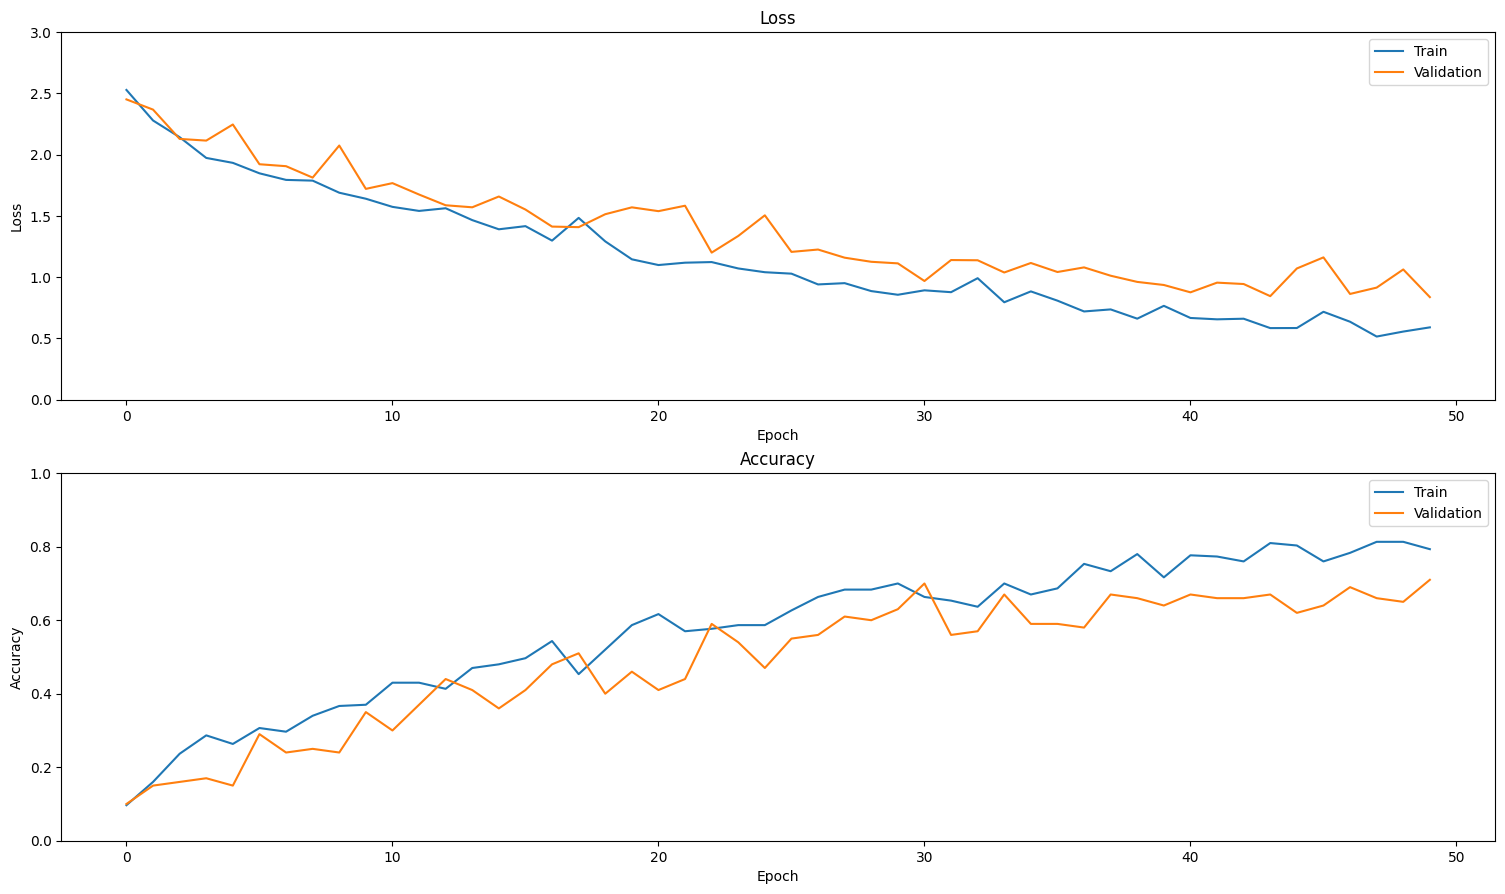

In [18]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

## Evaluate the model

Use Keras `Model.evaluate` to get the loss and accuracy on the test dataset. 

Note: The example model in this tutorial uses a subset of the UCF101 dataset to keep training time reasonable. The accuracy and loss can be improved with further hyperparameter tuning or more training data. 

In [19]:
model.evaluate(test_ds, return_dict=True)

      1/Unknown - 1s 823ms/step - loss: 0.6259 - accuracy: 0.8750

      2/Unknown - 1s 661ms/step - loss: 0.4198 - accuracy: 0.9375

      3/Unknown - 2s 687ms/step - loss: 0.3503 - accuracy: 0.9583

      4/Unknown - 3s 719ms/step - loss: 0.4468 - accuracy: 0.8750

      5/Unknown - 4s 809ms/step - loss: 0.4974 - accuracy: 0.8250

      6/Unknown - 5s 859ms/step - loss: 0.4692 - accuracy: 0.8542

      7/Unknown - 6s 876ms/step - loss: 0.4802 - accuracy: 0.8393

      8/Unknown - 7s 897ms/step - loss: 0.5084 - accuracy: 0.8125

      9/Unknown - 8s 906ms/step - loss: 0.5075 - accuracy: 0.8194

     10/Unknown - 9s 891ms/step - loss: 0.6595 - accuracy: 0.7625

     11/Unknown - 10s 912ms/step - loss: 0.7805 - accuracy: 0.6932

     12/Unknown - 11s 930ms/step - loss: 0.8301 - accuracy: 0.6667

     13/Unknown - 12s 899ms/step - loss: 0.8413 - accuracy: 0.6700

13/13 [==============================] - 12s 901ms/step - loss: 0.8413 - accuracy: 0.6700


{'loss': 0.8412802219390869, 'accuracy': 0.6700000166893005}

To visualize model performance further, use a [confusion matrix](https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix). The confusion matrix allows you to assess the performance of the classification model beyond accuracy. In order to build the confusion matrix for this multi-class classification problem, get the actual values in the test set and the predicted values. 

In [20]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [21]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)

In [22]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())

      1/Unknown - 2s 2s/step

      2/Unknown - 3s 1s/step

      3/Unknown - 4s 1s/step

      4/Unknown - 5s 995ms/step

      5/Unknown - 6s 982ms/step

      6/Unknown - 7s 968ms/step

      7/Unknown - 8s 956ms/step

      8/Unknown - 9s 977ms/step

      9/Unknown - 10s 976ms/step

     10/Unknown - 11s 977ms/step

     11/Unknown - 12s 961ms/step

     12/Unknown - 13s 966ms/step

     13/Unknown - 13s 959ms/step

     14/Unknown - 14s 953ms/step

     15/Unknown - 15s 953ms/step

     16/Unknown - 16s 951ms/step

     17/Unknown - 17s 952ms/step

     18/Unknown - 18s 951ms/step

     19/Unknown - 19s 957ms/step

     20/Unknown - 20s 954ms/step

     21/Unknown - 21s 950ms/step

     22/Unknown - 22s 945ms/step

     23/Unknown - 23s 947ms/step

     24/Unknown - 24s 950ms/step

     25/Unknown - 25s 954ms/step

     26/Unknown - 26s 956ms/step

     27/Unknown - 27s 956ms/step

     28/Unknown - 28s 956ms/step

     29/Unknown - 29s 950ms/step

     30/Unknown - 30s 954ms/step

     31/Unknown - 31s 954ms/step

     32/Unknown - 31s 950ms/step

     33/Unknown - 32s 950ms/step

     34/Unknown - 33s 954ms/step

     35/Unknown - 34s 952ms/step

     36/Unknown - 35s 950ms/step

     37/Unknown - 36s 951ms/step

     38/Unknown - 37s 938ms/step

38/38 [==============================] - 37s 939ms/step


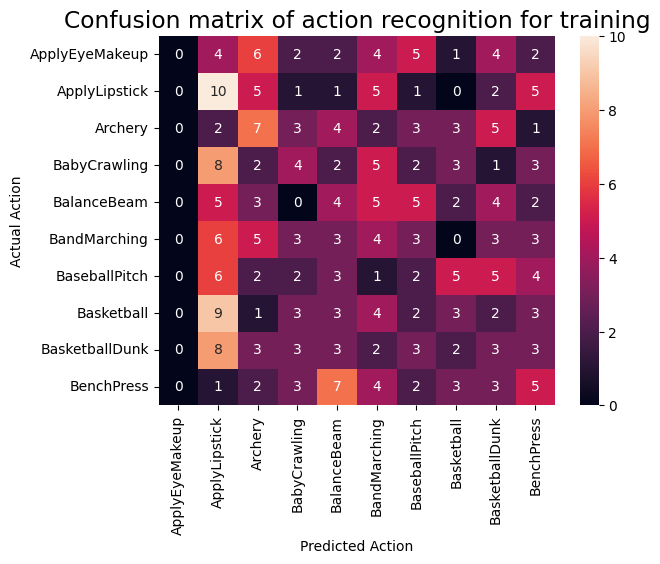

In [23]:
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

      1/Unknown - 1s 830ms/step

      2/Unknown - 1s 669ms/step

      3/Unknown - 2s 679ms/step

      4/Unknown - 3s 716ms/step

      5/Unknown - 4s 789ms/step

      6/Unknown - 5s 839ms/step

      7/Unknown - 6s 858ms/step

      8/Unknown - 7s 892ms/step

      9/Unknown - 8s 899ms/step

     10/Unknown - 9s 880ms/step

     11/Unknown - 10s 899ms/step

     12/Unknown - 11s 919ms/step

     13/Unknown - 12s 891ms/step

13/13 [==============================] - 12s 893ms/step


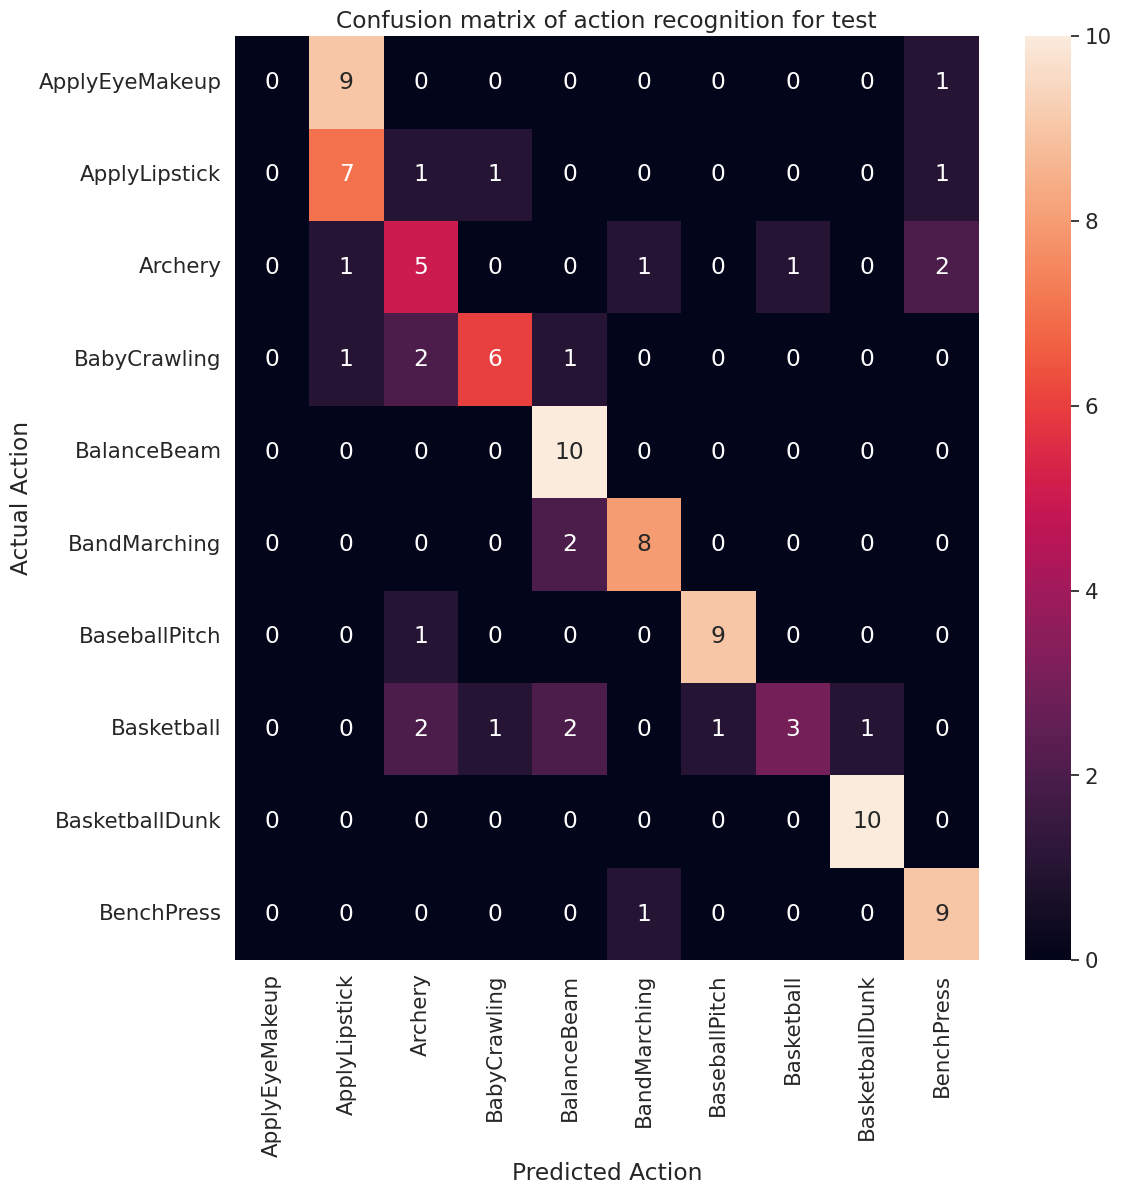

In [24]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

The precision and recall values for each class can also be calculated using a confusion matrix.

In [25]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [26]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

/tmpfs/tmp/ipykernel_73117/791028922.py:25: RuntimeWarning: invalid value encountered in scalar divide
  precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision


In [27]:
precision

{'ApplyEyeMakeup': nan,
 'ApplyLipstick': 0.3888888888888889,
 'Archery': 0.45454545454545453,
 'BabyCrawling': 0.75,
 'BalanceBeam': 0.6666666666666666,
 'BandMarching': 0.8,
 'BaseballPitch': 0.9,
 'Basketball': 0.75,
 'BasketballDunk': 0.9090909090909091,
 'BenchPress': 0.6923076923076923}

In [28]:
recall

{'ApplyEyeMakeup': 0.0,
 'ApplyLipstick': 0.7,
 'Archery': 0.5,
 'BabyCrawling': 0.6,
 'BalanceBeam': 1.0,
 'BandMarching': 0.8,
 'BaseballPitch': 0.9,
 'Basketball': 0.3,
 'BasketballDunk': 1.0,
 'BenchPress': 0.9}

## Next steps

To learn more about working with video data in TensorFlow, check out the following tutorials:

* [Load video data](https://www.tensorflow.org/tutorials/load_data/video)
* [MoViNet for streaming action recognition](https://www.tensorflow.org/hub/tutorials/movinet)
* [Transfer learning for video classification with MoViNet](https://www.tensorflow.org/tutorials/video/transfer_learning_with_movinet)